# Plot TNG RPS plots
## Written by Eric Rohr

In [1]:
### import modules
import illustris_python as il
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.patheffects as pe
import matplotlib.transforms as transforms
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import gaussian_filter
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
import os
import time
import h5py
import rohr_utils as ru 
import random
import six
random.seed(1)
%matplotlib notebook 

plt.style.use('fullpage.mplstyle')

zs, times = ru.return_zs_costimes()
times /= 1.0e9 # [Gyr]
scales = 1. / (1.+ zs)

In [2]:
### set global variables and plotting kwargs
mass_binwidth = 0.25
time_binwidth = 0.5

NGaussSmooth = 1000

figsizewidth  = 6.902 # the textwidth in inches of MNRAS
figsizeratio = 9. / 16.
figsizeheight = figsizewidth * figsizeratio

figsizewidth_fullpage = figsizewidth
figsizeheight_fullpage = figsizewidth_fullpage * figsizeratio
figsizewidth_column = (244. / 508.) * figsizewidth
figsizeheight_column = figsizewidth_column * figsizeratio

gal_boundary = 0.15

hist_kwargs         = dict(histtype='step', ls='-')
sc_kwargs           = dict(s=4**2, alpha=1.0, zorder=1.01, marker=r"$\rm{{{0:s}}}$".format('\u25EF'), linewidths=0.75)
plot_kwargs         = dict(fillstyle='none', ms=3, mew=0.75)
vline_kwargs        = dict(marker='None', ls='-', zorder=1, alpha=0.5, lw=1.0)
median_kwargs       = vline_kwargs.copy()
median_kwargs['lw'] = 2.0
text_kwargs         = dict()
axislabel_kwargs    = dict()
legend_kwargs       = dict()
one_one_kwargs      = dict(ls='-', marker='None', c='k', zorder=1.0, lw=2.5)
gal_boundary_kwargs = dict(marker='None', ls='--', c='k', zorder=0.9)

Mstarz0_key = 'Subhalo_Mstar_Rgal_z0'
M200cz0_key = 'HostGroup_M_Crit200_z0'
muz0_key    = 'muz0'
MCGasz0_key = 'SubhaloColdGasMass_z0'
MHGasz0_key = 'SubhaloHotGasMass_z0'
MTGasz0_key = 'SubhaloGasMass_z0'

Mstarz0_label   = r'$M_{\star}^{\rm sat}(z=0)\, [{\rm M_\odot}]$'
M200cz0_label   = r'$M_{\rm 200c}^{\rm host}(z=0)\, [{\rm M_\odot}]$'
muz0_label      = r'$\mu \equiv M_{\star}^{\rm sat} / M_{\rm 200c}^{\rm host} (z=0)$'
muz0_label_words = r'Mass Ratio $[\mu(z=0)]$'
MCGasz0_label   = r'$M_{\rm ColdGas}^{\rm sat}(z=0)\, [{\rm M_\odot}]$'
MHGasz0_label   = r'$M_{\rm HotGas}^{\rm sat}(z=0)\, [{\rm M_\odot}]$'
MTGasz0_label   = r'$M_{\rm TotGas}^{\rm sat}(z=0)\, [{\rm M_\odot}]$'
Nbranches_label = r'Number of Galaxies' 

tau0_RPS_tot_key = 'CosmicTime_tau_RPS_tot0'
tau90_RPS_tot_key = 'CosmicTime_tau_RPS_tot90'
tau100_RPS_tot_key = 'CosmicTime_tau_RPS_tot100'
tstrip_RPS_tot_key = 'Tstrip_tau_RPS_tot_tau0-tau100'

tau0_RPS_tot_label = r'Cosmic Time at Infall [$\tau_0$] [Gyr]'
tau90_RPS_tot_label = r'Cosmic Time at $\tau_{90}$ [RPS tot] [Gyr]'
tau100_RPS_tot_label = r'Cosmic Time at $\tau_{100}$ [Gyr]'
tstrip_RPS_tot_label = r'$\tau_{\rm RPS} \equiv \tau_{100} - \tau_{0}$ [Gyr]'

tau0_label_alt = r'RPS onset [$\tau_0$] [Gyr]'
tau100_label_alt = r'RPS end [$\tau_{100}$] [Gyr]'

tau0_key = tau0_RPS_tot_key
infall_key = tau0_key
tau0_label = tau0_RPS_tot_label
infall_label = tau0_label
tau100_key = tau100_RPS_tot_key
tau100_label = tau100_RPS_tot_label
tstrip_key = tstrip_RPS_tot_key
tstrip_label = tstrip_RPS_tot_label
tstrip_label_long = r'Total RPS Duration [$\tau_{\rm RPS} \equiv \tau_{100} - \tau_{0}$] [Gyr]'

tau0_RPS_est_key = 'CosmicTime_tau_RPS_est0'
tau90_RPS_est_key = 'CosmicTime_tau_RPS_est90'
tau100_RPS_est_key = 'CosmicTime_tau_RPS_est100'
tstrip_RPS_est_key = 'Tstrip_tau_RPS_est_tau0-tau100'

tau0_RPS_est_label = r'Cosmic Time at $\tau_0$ [RPS est] [Gyr]'
tau90_RPS_est_label = r'Cosmic Time at $\tau_{90}$ [RPS est] [Gyr]'
tau100_RPS_est_label = r'Cosmic Time at $\tau_{100}$ [RPS est] [Gyr]'
tstrip_RPS_est_label = r'$\tau_{\rm RPS}$ [RPS est] [Gyr]'

tau0_RPS_sRPS_key = 'CosmicTime_tau_RPS_sRPS0'
tau100_RPS_sRPS_key = 'CosmicTime_tau_RPS_sRPS100'
tstrip_RPS_sRPS_key = 'Tstrip_tau_RPS_sRPS_tau0-tau100'

tau0_RPS_sRPS_label = r'Cosmic Time at $\tau_0$ [RPS sRPS] [Gyr]'
tau100_RPS_sRPS_label = r'Cosmic Time at $\tau_{100}$ [RPS sRPS] [Gyr]'
tstrip_RPS_sRPS_label = r'$\tau_{\rm RPS}$ [RPS sRPS] [Gyr]'

d0_RPS_tot_key = 'HostCentricDistance_norm_tau_RPS_tot0'
d0_RPS_tot_label = r'Distance to $z=0$ Host at infall $[R_{\rm 200c}^{\rm host}({\rm infall})]$'

fgas_infall_key = 'SubhaloColdGasFraction_tau_RPS_tot0'
fgas_infall_label = r'$f_{\rm ColdGas}(\tau_0)\equiv M_{\rm ColdGas}^{\rm sat}(\tau_0) / M_{\star}^{\rm sat}(\tau_0)$'
SCGM_infall_key = 'SubhaloColdGasMass_tau_RPS_tot0'
SCGM_infall_label = r'$M_{\rm ColdGas}^{\rm sat}(\tau_0)$'

Napopass_tau100_key = 'Napopass_tau_RPS_tot100'
Napopass_tau100_label = r'Number of Orbits'

direc_list = ['../Figures/Tracers/TNG50-1/SummaryPlots/']
direc_PP = '../Figures/Tracers/TNG50-1/PaperPlots/'
direc_list = [direc_PP]


In [3]:
# define plotting labels and kwargs for each taudcit_key, gasz0_key combination

jel_key = 'jellyfish'
non_key = 'nonjellyf'
ins_key = 'inspected'
gen_key = 'z0satellites'
taudict_keys = [jel_key, non_key, ins_key, gen_key]

jel_label = 'Jellyfish'
non_label = 'Non-Jellyfish'
ins_label = 'Inspected'
gen_label = r'$z=0$ Satellites'
taudict_labels = [jel_label, non_label, ins_label]
taudict_labels_dict = {jel_key:jel_label, non_key:non_label, ins_key:ins_label, gen_key:gen_label}

tot_key = 'tot'
gas_key = 'gas'
nogas_key = 'nogas'
gasz0_keys = [tot_key, gas_key, nogas_key]

tot_label = 'All'
gas_label = r'$M_{\rm ColdGas}^{\rm sat}(z=0) > 0$'
nogas_label = r'$M_{\rm ColdGas}^{\rm sat}(z=0) = 0$'
gasz0_labels = [tot_label, gas_label, nogas_label]
gasz0_labels_dict = {tot_key:tot_label, gas_key:gas_label, nogas_key:nogas_label}

### define some general plotting parameters for each taudict_key, gasz0_key combination
### general colorscheme:
### jellyfish: green (for green valley galaxies, and images are typically green, blue and yellow)
### nonjellyf: purple (could be starforming and blue or quiescent and red)
### inspected: black 
### gasz0: blue, because they still have gas and are likely star forming
### nogasz0: red, because they have no gas and are quenched
### tot: the same color as standard

histkwargs_jel = dict(**hist_kwargs, color='tab:green', lw=2.5, zorder=2.2)
histkwargs_non = dict(**hist_kwargs, color='tab:purple', lw=2.0, zorder=2.1)
histkwargs_ins = dict(**hist_kwargs, color='tab:gray', lw=3.0, zorder=2.0)
histkwargs_gen = dict(**hist_kwargs, color='silver', lw=3.5, zorder=1.9)
histkwargs_gen['histtype'] = 'bar'
histkwargs_dict_temp = {jel_key:histkwargs_jel, non_key:histkwargs_non, ins_key:histkwargs_ins, gen_key:histkwargs_gen}

histkwargs_dict = {}
for taudict_key in taudict_keys:
    histkwargs_dict[taudict_key] = {}
    for gasz0_key in gasz0_keys:
        histkwargs_dict[taudict_key][gasz0_key] = histkwargs_dict_temp[taudict_key].copy()
    histkwargs_dict[taudict_key][gas_key]['color'] = 'tab:blue'
    histkwargs_dict[taudict_key][nogas_key]['color'] = 'tab:red'


cmaps_dict_temp = {jel_key:mpl.cm.get_cmap('Greens'),
                   non_key:mpl.cm.get_cmap('Purples'),
                   ins_key:mpl.cm.get_cmap('Greys'),
                   gen_key:mpl.cm.get_cmap('Greys')}
cmaps_dict = {}
for taudict_key in taudict_keys:
    cmaps_dict[taudict_key] = {}
    for gasz0_key in gasz0_keys:
        cmaps_dict[taudict_key][gasz0_key] = cmaps_dict_temp[taudict_key].copy()
    cmaps_dict[taudict_key][gas_key] = mpl.cm.get_cmap('Blues')
    cmaps_dict[taudict_key][nogas_key] = mpl.cm.get_cmap('Reds')
    
    
## define histogram kwargs for binning tstrip by M200cz0, Mstarz0, or tau0_infall ###
### NB -- must have two sets of histogram kwargs for the two definitions of tstrip ###
sim = 'TNG50-1'
M200cz0_bins = [11.5, 12.5, 13.5, 14.3] 
Mstarz0_bins = [8.0, 9.0, 10.0, 11.0]
SCGM_infall_bins = [9.0, 9.5, 10., 10.5]
tau0_bins = [5.0, 7.5, 10.0, 12.5]
Norbit_bins = [0, 1, 2, 4]

tstrip_histkwargs_dict = {}
histkwargs_list_key = 'histkwargs_list'

# M200cz0
tstrip_histkwargs_dict[M200cz0_key] = dict(key=M200cz0_key, label=M200cz0_label,
                                           savelabel=r'm200cz0', bins=M200cz0_bins)

histkwargs_list    = [{}] * (len(M200cz0_bins) - 1)
histkwargs_list[0] = dict(**hist_kwargs, color='navy', lw=1.5, zorder=1.05)
histkwargs_list[1] = dict(**hist_kwargs, color='darkviolet', lw=2.5, zorder=1.15)
histkwargs_list[2] = dict(**hist_kwargs, color='darkorange', lw=3.5, zorder=1.25)
tstrip_histkwargs_dict[M200cz0_key][histkwargs_list_key] = histkwargs_list
       
# SCGM(infall)
histkwargs_list    = [{}] * (len(SCGM_infall_bins) - 1)
tstrip_histkwargs_dict[SCGM_infall_key] = dict(key=SCGM_infall_key, label=SCGM_infall_label,
                                               savelabel=r'SCGMinfall', bins=SCGM_infall_bins)
histkwargs_list[0] = dict(**hist_kwargs, color='darkslategray', lw=2.0)
histkwargs_list[1] = dict(**hist_kwargs, color='seagreen', lw=1.5)
histkwargs_list[2] = dict(**hist_kwargs, color='wheat', lw=1.0)
tstrip_histkwargs_dict[SCGM_infall_key][histkwargs_list_key] = histkwargs_list

# Mstarz0
histkwargs_list = [{}] * (len(Mstarz0_bins) - 1)

tstrip_histkwargs_dict[Mstarz0_key] = dict(key=Mstarz0_key, label=Mstarz0_label,
                                           savelabel=r'mstarz0', bins=Mstarz0_bins)

histkwargs_list[0] = dict(**hist_kwargs, color='slateblue', lw=2.0)
histkwargs_list[1] = dict(**hist_kwargs, color='teal', lw=1.5)
histkwargs_list[2] = dict(**hist_kwargs, color='yellowgreen', lw=1.0)
tstrip_histkwargs_dict[Mstarz0_key][histkwargs_list_key] = histkwargs_list
      
# tau0_infall 
histkwargs_list  = [{}] * (len(tau0_bins) - 1)

tstrip_histkwargs_dict[tau0_key] = dict(key=tau0_key, label=tau0_label,
                                        savelabel='infalltime', bins=tau0_bins)

histkwargs_list[0] = dict(**hist_kwargs, color='royalblue', lw=2.0)
histkwargs_list[1] = dict(**hist_kwargs, color='slategray', lw=1.5)
histkwargs_list[2] = dict(**hist_kwargs, color='goldenrod', lw=1.0)
tstrip_histkwargs_dict[tau0_key][histkwargs_list_key] = histkwargs_list

# Nubmer of completed orbits (== Number of apocenter passes)
tstrip_histkwargs_dict[Napopass_tau100_key] = {histkwargs_list_key:histkwargs_list.copy()}
tstrip_histkwargs_dict[Napopass_tau100_key]['bins'] = Norbit_bins
tstrip_histkwargs_dict[Napopass_tau100_key]['savelabel'] = 'Norbit'
tstrip_histkwargs_dict[Napopass_tau100_key]['label'] = Napopass_tau100_label
       
# add these dictionaries to the class
tstrip_histbins_dict = {tstrip_key:tstrip_histkwargs_dict}


In [4]:
class TNGSim:
    
    def __init__(self, sim=sim, zooniverse=True, taudict_key=jel_key, gasz0_key=tot_key,
                 tstrip_histbins_dict=tstrip_histbins_dict):
        """
        Initialize the TNGsim class.
        sim == 'TNG50-1' 
        taudict_key == jel_key, non_key, or ins_key
        gasz0_key == tot_key, gas_key, nogas_key
        M200cz0_bins, Mstarz0_bins should each be length 4, including all bin edges
        """ 
        self.sim  = sim
        self.zooniverse = zooniverse
        self.taudict_key = taudict_key
        self.gasz0_key = gasz0_key
        self.M200cz0_bins= M200cz0_bins
        self.Mstarz0_bins = Mstarz0_bins
        
        self.sim_label = sim[:-2]
        
        self.taudict_label = taudict_labels_dict[taudict_key]
        
        self.gasz0_label = gasz0_labels_dict[gasz0_key]
                       
        # load the tau dictionary 
        self.tau_dict = load_taudict(self, zooniverse=zooniverse, key=taudict_key, gasz0_key=gasz0_key)
        
        self.histkwargs = histkwargs_dict[taudict_key][gasz0_key]
        self.cmap = cmaps_dict[taudict_key][gasz0_key]
        self.plotkwargs = dict(**plot_kwargs, color=self.histkwargs['color'])
        
        sckwargs_dict = {}
        sckwargs_dict[M200cz0_key] = dict(**sc_kwargs, cmap='plasma',
                                          norm=mpl.colors.LogNorm(vmin=10.**min(M200cz0_bins), vmax=10.**(max(M200cz0_bins))))
        sckwargs_dict[Mstarz0_key] = dict(**sc_kwargs, cmap='viridis',
                                          norm=mpl.colors.LogNorm(vmin=10.**(min(Mstarz0_bins)), vmax=10.**(max(Mstarz0_bins))))
        sckwargs_dict[muz0_key]    = dict(**sc_kwargs, cmap='cubehelix_r',
                                          norm=mpl.colors.LogNorm(vmin=10.**(-5.5), vmax=10.**(-2.5)))
        self.sckwargs_dict = sckwargs_dict
        
        self.tstrip_histbins_dict = tstrip_histbins_dict
        
        self.save_label = self.sim + '_' + taudict_key + '_' + gasz0_key
        self.plot_label = self.sim_label + ' ' + self.taudict_label + ' ' + self.gasz0_label
        
        return

def load_taudict(Sim, zooniverse=True, key=jel_key, gasz0_key=tot_key):

    result = {}
    fname = return_taudict_fname(Sim.sim, zooniverse=zooniverse, key=key, gasz0_key=gasz0_key)
    with h5py.File('../Output/%s_subfindGRP/'%Sim.sim + fname, 'a') as f:
        group = f['Group']
        for dset_key in group.keys():
            result[dset_key] = group[dset_key][:]
        f.close()
        
    return result
    
    
def return_taudict_fname(sim='TNG50-1', zooniverse=True, key=jel_key, gasz0_key=tot_key):
    
    if zooniverse:
        fname = 'zooniverse_%s_%s_clean_tau'%(sim, key)
    else:
        fname = 'subfind_%s_clean_tau'%sim

    if gasz0_key == nogas_key:
        fname += '_nogasz0.hdf5'
    elif gasz0_key == gas_key:
        fname += '_gasz0.hdf5'
    elif gasz0_key == tot_key:
        fname += '.hdf5'
    else:
        print('Warning, gasz0_key %s not recognized. Using tot_key instead.'%(gasz0_key))
        fname += '.hdf5'
                         
    return fname
        
    
def add_redshift_sincez2(ax, label=True):
    """
    For a given x axis, add redshift since z=2 to the top x-axis. 
    Optionally label the axis + tick marks.
    Returns ax
    """
    ticks_SnapNum = [33, 40, 50, 59, 67, 78, 84, 91, 99]
    ticks_costime = times[ticks_SnapNum]
    ticks_labels = ['2', '1.5', '1', '0.7', '0.5', '0.3', '0.2', '0.1', '0']

    xlolim = ru.floor_to_value(times[np.argmin(abs(zs - 2.5))], 0.1)
    xhilim = ru.ceil_to_value(times[np.argmin(abs(zs - 0.0))], 0.1)
    xhilim = 14.1

    ax.set_xlim(xlolim, xhilim)

    redshift_ax = ax.twiny()
    redshift_ax.set_xlim(ax.get_xlim())
    redshift_ax.set_xticks(ticks_costime)
    redshift_ax.tick_params(axis='both', which='minor', top=False)
    if label:
        redshift_ax.set_xlabel(r'Redshift', **axislabel_kwargs)
        redshift_ax.set_xticklabels(ticks_labels)
    else:
        redshift_ax.set_xticklabels([])
        
    return ax



In [5]:
sim = 'TNG50-1'
TNG50_dict = {}
for taudict_key in taudict_keys[:-1]:
    TNG50_dict[taudict_key] = {}
    for gasz0_key in gasz0_keys:
        TNG50_dict[taudict_key][gasz0_key] = TNGSim(sim=sim, zooniverse=True, taudict_key=taudict_key, gasz0_key=gasz0_key, tstrip_histbins_dict=tstrip_histbins_dict)



In [6]:
TNG50_gen = TNGSim(sim=sim, zooniverse=False, taudict_key=gen_key)
TNG50_dict[gen_key] = TNG50_gen

In [7]:
### 1D histogram plots binned by taudict_keys (jellyfish, nonjellyf, inspected) ###
def plot_tracers_mass_distributions_z0(Sims, savefig=False):
    """
    Plot the 1D histograms for 6 panels defined below. Could be generalized...
    Sims should be a list of TNGSim classes, starting with the broadest possible sample (i.e., inspected, tot)
    """

    x_keys   = [Mstarz0_key, M200cz0_key, muz0_key, MCGasz0_key, MHGasz0_key, MTGasz0_key]
    x_labels = [Mstarz0_label, M200cz0_label, muz0_label, MCGasz0_label, MHGasz0_label, MTGasz0_label]
    
    fig, axs = plt.subplots(2, 3, sharey='row')
    axs[0,0].set_ylabel(Nbranches_label, **axislabel_kwargs)
    axs[1,0].set_ylabel(Nbranches_label, **axislabel_kwargs)
    
    axs, legend_handels = plot_1Dhistograms(Sims, axs, x_keys, x_labels, y_step=0.15)
    
    fig.legend(handles=legend_handels, ncol=len(Sims), bbox_to_anchor=(0.5, 1.05), loc='lower center', bbox_transform=axs[0,1].transAxes,
               title=Sims[0].sim_label, title_fontsize='large', **legend_kwargs)
    
    if (savefig):
        save_label = ''
        for Sim in Sims:
            save_label += Sim.save_label
            if Sim != Sims[-1]:
                save_label += '_'
        fname = '%s_massdistributions_z0.pdf'%save_label
        for direc in direc_list:
            fig.savefig(direc + fname, bbox_inches='tight')

    return fig, axs

def plot_1Dhistograms(Sims, axs, x_keys, x_labels,
                      x_text=0.05, y_text=0.95, y_step=0.1, ha='left', va='top',
                      plot_mask=True):
    """
    fill the panels for 1D histograms and return fig, ax, and legend_handels
    Also adds the number of points with x <= 0. 
    """
    if isinstance(x_keys, six.string_types):
        x_keys = [x_keys]
    if isinstance(x_labels, six.string_types):
        x_labels = [x_labels]
    
    if len(axs.flat) != len(x_keys) or len(axs.flat) != len(x_labels):
        print('Incorrect number of axs, x_keys, or x_labels. Retunrning')
        return
    
    for ax_i, ax in enumerate(axs.flat):
        x_key   = x_keys[ax_i]
        x_label = x_labels[ax_i]
        ax.set_xlabel(x_label, **axislabel_kwargs)
        ax.set_yscale('log')

        ax = plot_1Dhist_panel(Sims, ax, x_key, plot_mask=plot_mask) 
        
    # generate legend handels 
    legend_handels = add_histlegend(Sims)
    
    return axs, legend_handels
 
def plot_1Dhist_panel(Sims, ax, x_key,
                      plot_mask=True):
    """
    Calculate the 1D histogram and add to an existing axis.
    Loop over the taudict_keys and add each to the same axis.
    For the x values <= 0, there's the option either to plot them 
    at 1.0e-2 * min(x), or to omit them entirely. 
    Returns the ax and the number of points where x <= 0
    """
    
    ### use the inspected branches to set the bins ###
    x = Sims[0].tau_dict[x_key].copy()
    
    # log bins (for mass quantities) or linear bins (for time quantities)
    if ('T' in x_key) or ('tau' in x_key):
        x_loval = 0.1
        mask = x <= x_loval
        min_plot = 0.
        x[mask] = min_plot
        binwidth  = time_binwidth
        bins, bincents = ru.returnbins(x, binwidth)
    elif ('M' in x_key) or ('mu' in x_key):
        x_loval = 1.0e-7
        mask = x <= x_loval
        min_plot = x[~mask].min() * 1.0e-2
        x[mask] = min_plot
        binwidth = mass_binwidth
        bins, bincents = ru.returnlogbins(x, binwidth) 
        ax.set_xscale('log')
    del x
        
    for Sim in Sims:
        # load dataset and validate
        x = Sim.tau_dict[x_key].copy()
        mask = x <= x_loval
        
        if plot_mask:
            x[mask] = min_plot
        else:
            x = x[~mask]
            
        label = Sim.gasz0_key + ' (%d)'%len(x)
        histkwargs = Sim.histkwargs

        ax.hist(x, bins, label=label, **histkwargs)
    # finish loop over Sims
            
    return ax


def add_histlegend(Sims):
    """
    generates the legend handles for the histogram plots, including the
    total number of points contained in the histogram
    """
    result = []
    for Sim in Sims:
        histkwargs = Sim.histkwargs
        label = Sim.taudict_label + ' (%d)'%(Sim.tau_dict[M200cz0_key].size)
        result.append(Patch(facecolor='None', edgecolor=histkwargs['color'],
                            lw=histkwargs['lw'], label=label))
    return result



<IPython.core.display.Javascript object>


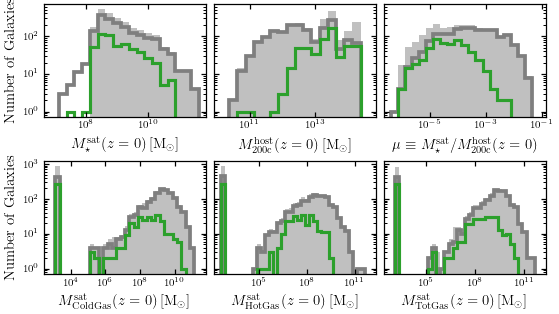

In [8]:
Sims = [TNG50_dict[ins_key][tot_key],
        TNG50_dict[jel_key][tot_key],
        TNG50_dict[gen_key]]

savefig=False

fig, axs = plot_tracers_mass_distributions_z0(Sims, savefig=savefig)

<IPython.core.display.Javascript object>


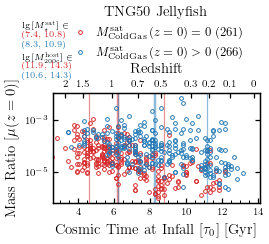

In [9]:
def plot_muz0_infalltimes(Sims, savefig=False):
    """
    Plots muz0 vs infall time [tau_0] for each Sim in Sims
    Sims should be a list of Sim classes. 
    Optionally saves the figure.
    Returns fig, ax
    """

    x_key = infall_key
    x_label = infall_label
    y_key = muz0_key
    y_label = muz0_label_words

    fig, ax = plt.subplots(figsize=(figsizewidth_column, figsizewidth_column / 1.1))
    ax.set_yscale('log')
    ax.set_ylabel(y_label, **axislabel_kwargs)
    ax.set_xlabel(x_label, **axislabel_kwargs)
    ax = add_redshift_sincez2(ax, label=True)
    
    percentiles = [16, 50, 84]

    for Sim in Sims:
        tau_dict = Sim.tau_dict

        x = tau_dict[x_key]
        y = tau_dict[y_key]

        mask = (x > 0) & (y > 0)

        x_plot = x[mask]
        y_plot = y[mask]

        ax.plot(x_plot, y_plot, label=(Sim.gasz0_label + ' (%d)'%x_plot.size), **Sim.plotkwargs)
                
        for percentile in percentiles:
            val = np.percentile(x_plot, percentile)
            if percentile == 50:
                kwargs = median_kwargs
            else:
                kwargs = vline_kwargs
            ax.axvline(val, color=Sim.plotkwargs['color'], **kwargs)

    leg_kwargs = dict(ncol=1, bbox_to_anchor=(0.5, 1.25), loc='lower center', bbox_transform=ax.transAxes,
                      title=Sims[0].sim_label + ' ' + jel_label , title_fontsize='medium', fontsize='small')

    ax.legend(**leg_kwargs)   
    
    # axs[1]: state the Mstar and M200c ranges for each sample
    textkwargs = dict(ha='left', va='top', ma='left', transform=ax.transAxes, fontsize='xx-small', **text_kwargs)
    xval = -0.15
    yval = 1.65
    ystep = 0.09
    ymstar = yval
    ym200c = ymstar - ystep * 3.1
    for i, Sim in enumerate(Sims):
        if i == 0:
            #ax.text(xval, yval, r'at $z=0:$', **textkwargs)
            ax.text(xval, ymstar, r'$\lg[M_{\star}^{\rm sat}] \in$', **textkwargs)
            ax.text(xval, ym200c, r'$\lg[M_{\rm 200c}^{\rm host}] \in$', **textkwargs)
        c = Sim.plotkwargs['color']
        mstarlolim = ru.floor_to_value(np.log10(Sim.tau_dict[Mstarz0_key].min()), 0.1)
        mstarhilim = ru.ceil_to_value(np.log10(Sim.tau_dict[Mstarz0_key].max()), 0.1)
        m200clolim = ru.floor_to_value(np.log10(Sim.tau_dict[M200cz0_key].min()), 0.1)
        m200chilim = ru.ceil_to_value(np.log10(Sim.tau_dict[M200cz0_key].max()), 0.1)
        ax.text(xval, ymstar - ystep*(i + 1), r'$(%.1f, %.1f)$'%(mstarlolim, mstarhilim), c=c, **textkwargs)
        ax.text(xval, ym200c - ystep*(i + 1), r'$(%.1f, %.1f)$'%(m200clolim, m200chilim), c=c, **textkwargs)
        
    if (savefig):
        save_label = ''
        for Sim in Sims:
            save_label += Sim.save_label
            if Sim != Sims[-1]:
                save_label += '_'
        fname = '%s_muz0_infalltime.pdf'%save_label
        for direc in direc_list:
            fig.savefig(direc + fname, bbox_inches='tight')

    return fig, ax

Sims = [TNG50_dict[jel_key][nogas_key],
        TNG50_dict[jel_key][gas_key]]

fig, ax = plot_muz0_infalltimes(Sims, savefig=savefig)


In [13]:
def plot_time_distributions(Sims,
                            x_keys=[tau0_key, tau100_key, tstrip_key],
                            x_labels=[tau0_label_alt, tau100_label_alt, tstrip_label],
                            savefig=False, legend=True):
    """
    Plot 1d histogram distributions for the given x quantities
    Default is tau0, tau100, tauRPS for the standard definition.
    """
    
    if len(x_keys) != len(x_labels):
        print('Wrong number of x_keys or x_labels.')
        return
    
    fig, axs = plt.subplots(1, len(x_keys), sharey=True, figsize=(figsizewidth, figsizewidth/2.5))
    axs[0].set_ylabel(Nbranches_label, **axislabel_kwargs)
        
    if 'Tstrip' in x_keys[0]:
        x_text = 0.95
        ha = 'right'
        save_key = 'tstrip'
    elif 'T' in x_keys[0]:
        x_text = 0.05
        ha = 'left'
        save_key = 'taus'
        
    axs, _ = plot_1Dhistograms(Sims, axs, x_keys, x_labels,
                               y_step=0.10, x_text=x_text, ha=ha, plot_mask=False)
        
    axs[0] = add_redshift_sincez2(axs[0])
    axs[1] = add_redshift_sincez2(axs[1])
    
    ### add some extra info and text
    # axs[0]: clarify tau0 == infall time
    text = r'$\tau_0 \equiv$ infall time'
    textkwargs = dict(ha='left', va='top', transform=axs[0].transAxes, **text_kwargs)
    text = axs[0].text(0.05, 0.95, text, **textkwargs)
    
    # axs[1]: state the Mstar and M200c ranges for each sample
    textkwargs = dict(ha='left', va='top', ma='left', transform=axs[1].transAxes, **text_kwargs)
    xval = 0.05
    yval = 0.95
    ystep = 0.11
    ymstar = yval - ystep
    ym200c = ymstar - ystep * 3
    for i, Sim in enumerate(Sims):
        if i == 0:
            axs[1].text(xval, yval, r'at $z=0:$', **textkwargs)
            axs[1].text(xval, ymstar, r'$\lg[M_{\star}^{\rm sat}] \in$', **textkwargs)
            axs[1].text(xval, ym200c, r'$\lg[M_{\rm 200c}^{\rm host}] \in$', **textkwargs)
        c = Sim.plotkwargs['color']
        mstarlolim = ru.floor_to_value(np.log10(Sim.tau_dict[Mstarz0_key].min()), 0.1)
        mstarhilim = ru.ceil_to_value(np.log10(Sim.tau_dict[Mstarz0_key].max()), 0.1)
        m200clolim = ru.floor_to_value(np.log10(Sim.tau_dict[M200cz0_key].min()), 0.1)
        m200chilim = ru.ceil_to_value(np.log10(Sim.tau_dict[M200cz0_key].max()), 0.1)
        axs[1].text(xval, ymstar - ystep*(i + 1), r'$(%.1f, %.1f)$'%(mstarlolim, mstarhilim), c=c, **textkwargs)
        axs[1].text(xval, ym200c - ystep*(i + 1), r'$(%.1f, %.1f)$'%(m200clolim, m200chilim), c=c, **textkwargs)
        
    ### attempt to get the minor tick marks to show up for the y axis
    ax = axs[0]
    locmin = mpl.ticker.LogLocator(base=10.0,subs=(0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=3)
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
        
    if legend:
        legend_handels = add_histlegend_gasz0(Sims)
        fig.legend(handles=legend_handels, ncol=2, bbox_to_anchor=(0.5, 1.15), loc='lower center', bbox_transform=axs[1].transAxes,
                   title=Sims[0].sim_label + ' ' + Sims[0].taudict_label, title_fontsize='large', **legend_kwargs)
    
    if (savefig):
        save_label = ''
        for Sim in Sims:
            save_label += Sim.save_label
            if Sim != Sims[-1]:
                save_label += '_'
        fname = '%s_tau_distributions.pdf'%save_label
        for direc in direc_list:
            fig.savefig(direc + fname, bbox_inches='tight')
            
    return fig, axs

def add_histlegend_gasz0(Sims):
    """
    generates the legend handles for the histogram plots, including the
    total number of points contained in the histogram
    """
    result = []
    for Sim in Sims:
        histkwargs = Sim.histkwargs
        label = Sim.gasz0_label + ' (%d)'%(Sim.tau_dict[M200cz0_key].size)
        result.append(Patch(facecolor='None', edgecolor=histkwargs['color'],
                            lw=histkwargs['lw'], label=label))
    return result


<IPython.core.display.Javascript object>


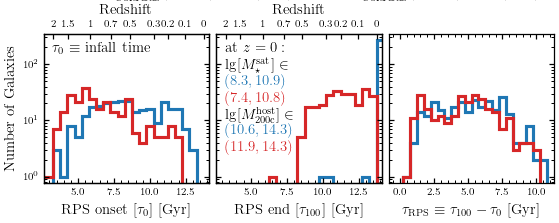

In [14]:
Sims = [TNG50_dict[jel_key][gas_key],
        TNG50_dict[jel_key][nogas_key]]

fig, axs = plot_time_distributions(Sims, savefig=savefig)

In [15]:
### plot tstrip histograms binned by various parameters ### 
def plot_tstrip_RPS_multipanel(Sim, m200cz0_bin_i=2, savefig=False):
    """
    Create the multipanel figure for tstrip
    top panel is tstrip binned by m200cz0
    bottom panels take one bin of m200cz0 and show
    the same results using the infall time definition,
    and the other two panels further bin by mstarz0 and infall time.
    Returns the fig, and plt.gca could be used to the axes
    """
    
    def rewrite_legend(ax):
        """
        find the existing legend on ax, update properties, and rewrite
        """
        
        leg     = ax.get_legend()
        handles = leg.get_patches()
        texts   = leg.get_texts()
        title   = leg.get_title().get_text()
        labels  = []
        for text in texts:
            labels.append(text.get_text())

        if M200cz0_label in title:
            title = r'$\tau_{\rm RPS}$ calculated via'
            labels = [r'RPS sRPS',
                      r'RPS tot']
        elif Mstarz0_label in title:
            title = r'$\lg[M_\star^{\rm sat}(z=0)]\in$'
        elif tau0_label in title:
            title = r'Infall Time [Gyr] $\in$'
        elif fgas_infall_label in title:
            title = r'$\lg[f_{\rm ColdGas}(\tau_0)] \in$'
        elif SCGM_infall_label in title:
            title = r'$\lg[M_{\rm ColdGas}^{\rm sat}(\tau_0)] \in$'
        elif Napopass_tau100_label in title:
            title = r'$N_{\rm orbits}(\tau_{100}) \in$'
        else:
            print('rewrite legend not supported. returning')
            return
        
        leg.set_visible(False)
        ax.legend(handles, labels, title=title, fontsize='x-small', title_fontsize='x-small')
        
        return ax
    
    text_kwargs_panel = dict(ha='right', va='top', ma='right', fontsize='x-small')

    x_key   = tstrip_key
    bin_key = M200cz0_key
    x_label = tstrip_label_long
    
    x_vals   = Sim.tau_dict[x_key]
    bin_vals = np.log10(Sim.tau_dict[bin_key])
        
    bins          = Sim.tstrip_histbins_dict[x_key][bin_key]['bins']
    bin_label     = Sim.tstrip_histbins_dict[x_key][bin_key]['label']
    bin_savelabel = Sim.tstrip_histbins_dict[x_key][bin_key]['savelabel']
    
    figsizeheight = figsizewidth / 1.5
    fig = plt.figure(constrained_layout=True, figsize=(figsizewidth, figsizeheight))
    
    gs = GridSpec(2, 3, figure=fig)
    
    # first axis: M200c(z=0) bins -- use all three colunmns of the first row
    ax1 = fig.add_subplot(gs[0,:])
    
    ax1 = plot_binnedhist_panel(Sim, ax1, x_key, bin_key, add_legend=True)
    
    # for the bottom row, we only use one of the M200cz0 bins
    bins_plot   = bins[m200cz0_bin_i:m200cz0_bin_i+2]
    bin_indices = ((bin_vals >= bins_plot[0]) & (bin_vals < bins_plot[1]))
    
    # second axis: tstrip definition comparison -- first column
    ax2 = fig.add_subplot(gs[1,0])
    
    bin_key = SCGM_infall_key
    
    ax2 = plot_binnedhist_panel(Sim, ax2, x_key, bin_key,
                                preset_indices=bin_indices, add_legend=True)
    ax2 = rewrite_legend(ax2)
    
    textkwargs = dict(transform=ax2.transAxes, **text_kwargs_panel, **text_kwargs)
    ax2.text(0.95, 0.60, r'%s '%bin_label, **textkwargs)
    ax2.text(0.95, 0.50, r'$\in [%.1f, %.1f)$'%(bins_plot[0], bins_plot[1]), **textkwargs)
    
    # third axis: Mstarz0 -- second column
    ax3 = fig.add_subplot(gs[1,1], sharey=ax2)
    
    bin_key = Mstarz0_key
    
    ax3 = plot_binnedhist_panel(Sim, ax3, x_key, bin_key,
                                preset_indices=bin_indices, add_legend=True)
    ax3 = rewrite_legend(ax3)
        
    textkwargs = dict(transform=ax3.transAxes, **text_kwargs_panel, **text_kwargs)
    ax3.text(0.95, 0.60, r'%s'%bin_label, **textkwargs)
    ax3.text(0.95, 0.50, r'$\in [%.1f, %.1f)$'%(bins_plot[0], bins_plot[1]), **textkwargs)

    # fourth axis: tau0_infall -- third column
    ax4 = fig.add_subplot(gs[1,2], sharey=ax3)
    #ax4.tick_params(labelleft=False)
    
    bin_key = Napopass_tau100_key
    
    ax4 = plot_binnedhist_panel(Sim, ax4, x_key, bin_key,
                                preset_indices=bin_indices, add_legend=True)
    
    ax4 = rewrite_legend(ax4)

    textkwargs = dict(transform=ax4.transAxes, **text_kwargs_panel, **text_kwargs)
    ax4.text(0.95, 0.60, r'%s'%bin_label, **textkwargs)
    ax4.text(0.95, 0.50, r'$\in [%.1f, %.1f)$'%(bins_plot[0], bins_plot[1]), **textkwargs)
    
    fig.text(0.5, -0.01, x_label, va='center', ha='center', fontsize='large')
    fig.text(-0.02, 0.5, Nbranches_label, rotation='vertical', va='center', ha='center', fontsize='large')
    ax1.set_title(r'%s'%Sim.plot_label)
    
    if (savefig):
        bin_key = M200cz0_key
        fname = '%s_%s_multipanel_%s_%.1f-%.1f.pdf'%(Sim.save_label,
                                                     tstrip_key,
                                                     bin_key,
                                                     bins_plot[0],
                                                     bins_plot[1])
        for direc in direc_list:
            fig.savefig(direc + fname, bbox_inches='tight')

    return fig


def plot_binnedhist_panel(Sim, ax, x_key, bin_key, 
                          preset_indices=None, use_preset_bins=True, add_legend=False):
    """
    fill an ax with histograms of tstrip (x_key), binned by some other parameter bin_key.
    Note that x_key should be one of the t_strip keys.
    preset_indices slices x before binning by bin_key.
    use_preset_bins uses the bins defined in Sim.tstrip_histbins_dict[x_key][bin_key]['bins'].
    If False, then uses [0, 33, 67, 100] percentiles. 
    Optionally add the legend as well.
    Returns the ax.
    """
    
    x_vals   = Sim.tau_dict[x_key][preset_indices]
    bin_vals = Sim.tau_dict[bin_key][preset_indices]
    indices  = ((x_vals >= 0) & (bin_vals >= 0))
    x_vals   = x_vals[indices]
    
    bin_label = Sim.tstrip_histbins_dict[x_key][bin_key]['label']
    # linear or log binning for bin_vals? 
    if ('T' in bin_key) or (Napopass_tau100_key in bin_key):
        bin_vals = bin_vals[indices]
        legend_title = r'%s $\in$'%bin_label
    elif ('M' in bin_key) or ('GasFraction' in bin_key):
        bin_vals = np.log10(bin_vals[indices])
        legend_title = r'$\log_{10}\big[$%s$\big] \in$'%bin_label
    else:
        print('bin_key %s not supported. returning'%bin_key)
        return
    
    # assuming linear binning for t_strip spanning all time 
    x_binwidth         = time_binwidth
    x_bins, x_bincents = ru.returnbins([0.01, 13.99], x_binwidth)       

    if (use_preset_bins):
        bins = Sim.tstrip_histbins_dict[x_key][bin_key]['bins']
    else:
        bins = np.percentile(bin_vals, [0, 33, 67, 100])
        bins[0]  -= 0.01
        bins[-1] += 0.01 
    bin_indices = np.digitize(bin_vals, bins)
    
    histkwargs_list = Sim.tstrip_histbins_dict[x_key][bin_key]['histkwargs_list']
    
    for bin_i in range(len(bins)-1):

        histkwargs = histkwargs_list[bin_i]
                        
        plot_indices = bin_indices == (bin_i + 1)
        
        x_plot = x_vals[plot_indices]
        Nbin   = len(x_plot)
        
        # if there are no data, then ignore and continue 
        if Nbin == 0:
            continue
        
        labeltext = r'$[%.1f, %.1f)\ (%d)$'%(bins[bin_i],
                                             bins[bin_i+1], Nbin)    

        ax.hist(x_plot, x_bins, label=labeltext, **histkwargs)
        
        # add  a vertical line at median
        ax.axvline(np.median(x_plot), color=histkwargs['color'], **median_kwargs)
    # finish loop over bins
    
    if (add_legend):
        ax.legend(title=legend_title, **legend_kwargs)
        
    return ax


<IPython.core.display.Javascript object>


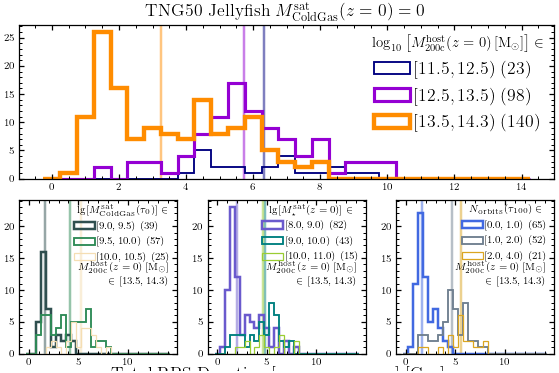

In [16]:
Sim = TNG50_dict[jel_key][nogas_key]
fig = plot_tstrip_RPS_multipanel(Sim, m200cz0_bin_i=2, savefig=savefig)

In [25]:
# load input file into a dictionary
def load_grpdict(sim, key):
    # key == 'jellyfish', 'nonjellyf' or 'inspected'; otherwise returns KeyError
    result = {}
    infname = 'zooniverse_%s_%s_branches_clean.hdf5'%(sim, jel_key)
    with h5py.File('../Output/%s_subfindGRP/'%sim + infname, 'r') as f:
        for group_key in f.keys():
            result[group_key] = {}
            for dset_key in f[group_key].keys():
                result[group_key][dset_key] = f[group_key][dset_key][:]
        f.close()
    
    return result

Time_key = 'CosmicTime'
SCGM_key = 'SubhaloColdGasMass'
RPS_key = 'SubhaloColdGasTracer_StripTot'
SFR_key = 'SubhaloSFR'
HCDn_key = 'HostCentricDistance_norm'
HCDp_key = 'HostCentricDistance_phys'
RPS_int_tot_key = 'RPS_int_tot'
sRPS_key = 'sRPS'
sSFR_key = 'sSFR'

Time_label = 'Cosmic Time [Gyr]'
SCGM_label = r'$M_{\rm ColdGas}^{\rm subhalo}$' '\n' r'$[{\rm M_\odot}]$'
RPS_label = r'RPS + Outflows' '\n' r'$[{\rm M_\odot\, yr^{-1}}]$'
sRPS_label = r'RPS+O / $M_{\rm ColdGas}^{\rm subhalo}$' '\n' r'$[{\rm yr^{-1}}]$'
HCDn_label = r'Distance to $z=0$ Host [$R_{\rm 200c}(t)$]'
HCDp_label = r'Distance to $z=0$ Host [pkpc]'

flag_keys = ['central_flags', 'preprocessed_flags', 'memberlifof_flags']
labels = ['Central', 'PreProcessed', r'In $z=0$ Host']
markers = ['^', 's', 'o']

tau_RPS_tot_key = 'tau_RPS_tot'
tau_RPS_est_key = 'tau_RPS_est'
tau_RPS_sRPS_key = 'tau_RPS_sRPS'
tau_medpeak_key = 'tau_medpeak'
quench_key = 'quench'

cmap = cm.get_cmap('YlOrRd')

thin_gray_line_kwargs = dict(c='tab:gray', ls='-', marker='None', lw=1, zorder=0.1)
sc_kwargs = dict(cmap=cmap, s=6**2, vmin=-0.1, vmax=3.0)
jelly_kwargs = dict(marker='.', c='k', ms=2, mew=1, fillstyle='none', zorder=2.3)
tau_kwargs = dict(c='k', lw=2, ls='-', marker='None', zorder=3)
dist_plot_kwargs = dict(c='tab:gray', ls='-', marker='None', lw=1, zorder=0.1)

tau_text_kwargs = dict(ha='right', va='top', rotation=90, fontsize='medium', zorder=3)
axislabel_kwargs = dict()

tau_keys = [tau_RPS_tot_key,
            tau_RPS_est_key,
            tau_RPS_sRPS_key,
            tau_medpeak_key,
            quench_key]

tau_labels = ['RPS tot',
              'RPS est',
              'RPS sRPS',
              'peak SCGM',
              '']

tauvals_dict = {}
tauvals_dict[tau_RPS_tot_key] = np.array([0, 100])
tauvals_dict[tau_RPS_est_key] = np.array([0, 100])
tauvals_dict[tau_RPS_sRPS_key] = np.array([0, 100])
tauvals_dict[tau_medpeak_key] = np.array([10, 90])
tauvals_dict[quench_key] = ['']

tau_labels_dict = {}
tau_labels_dict[tau_RPS_tot_key] = ['infall', r'$\tau_{100}$']
tau_labels_dict[quench_key] = ['quench']

tau_kwargs = dict(ls='-', marker='None', zorder=3)
tau_kwargs_dict = {}
tau_kwargs_dict[tau_RPS_tot_key] = dict(**tau_kwargs, lw=4.5, c='black')
tau_kwargs_dict[tau_RPS_est_key] = dict(**tau_kwargs, lw=3, c='tab:purple')
tau_kwargs_dict[tau_RPS_sRPS_key] = dict(**tau_kwargs, lw=1.5, c='tab:olive')
tau_kwargs_dict[tau_medpeak_key] = dict(**tau_kwargs, lw=1.0, c='tab:blue')
tau_kwargs_dict[tau_medpeak_key]['ls'] = (0, (1, 0.5))
tau_kwargs_dict[quench_key] = dict(**tau_kwargs, lw=1, c='tab:red')

tau_text_kwargs = dict(ha='right', va='top', rotation=90, fontsize='medium', zorder=3)

xlolim = ru.floor_to_value(times[np.argmin(abs(zs - 2.0))], 0.1)
xhilim = ru.ceil_to_value(times[np.argmin(abs(zs - 0.0))], 0.1)

def plot_SCGM_evolution_sincez2(grp_key, grp_dict, tau_dict,
                                savefig=False, clf=False):
    """
    Meant only for branches that have tau_0 at z <= 2 and reach tau_100
    """
    group = grp_dict[grp_key]
    taudict_index = int(grp_key) == tau_dict['SubfindID']
    
    fig, ax = plt.subplots()
        
    x_key = Time_key
    y_key = SCGM_key
    c_key = HCDn_key
    dist_key = HCDp_key
    
    ylolim = 1.1e4
    yhilim = 3.9e11

    ax.set_yscale('log')
    ax.set_ylabel(SCGM_label, **axislabel_kwargs)
    ax.set_xlabel(Time_label, **axislabel_kwargs)
    ax.set_ylim(ylolim, yhilim)
    ax.set_xlim(xlolim, xhilim)

    # add second x axis for redshift
    ax = add_redshift_sincez2(ax, label=True)
        
    # load data for the group
    group = grp_dict[grp_key]
    SnapNum = group['SnapNum']
    x = group[x_key]
    y = group[y_key]
    # replace y values below the ylim with the ylim
    y[y < ylolim] = ylolim
    c = group[c_key]
    
    # add a second y axis for the distance to the host
    dist_ax = ax.twinx()
    dist_c = dist_plot_kwargs['c']
    dist_ylolim = 9.0e0
    dist_yhilim = 9.9e3
    dist_ax.set_ylim(dist_ylolim, dist_yhilim)
    dist_ax.set_yscale('log')
    dist_ax.spines['right'].set_color(dist_c)
    dist_ax.tick_params(axis='y', which='both', color=dist_c, labelcolor=dist_c)
    dist_ax.set_ylabel(HCDp_label, color=dist_c)
    dist_y = group[dist_key]
    dist_ax.plot(x, dist_y, **dist_plot_kwargs)
    
    # add markers where there are pericenter passages
    peri_indices = np.where((group['Nperipass'][:-1] - group['Nperipass'][1:]) == 1)[0]
    dist_ax.plot(x[peri_indices], dist_y[peri_indices], marker='+', color='black')
    apo_indices = np.where((group['Napopass'][:-1] - group['Napopass'][1:]) == 1)[0]
    dist_ax.plot(x[apo_indices], dist_y[apo_indices], marker='x', color='black')

    flag_keys = ['central_flags', 'preprocessed_flags', 'memberlifof_flags']
    labels = ['Central', 'PreProcessed', r'Satellite']
    markers = ['^', 's', 'o']
            
    done_indices  = group['ins_flags'] == 1
    
    # plot data for the different flags
    ax, _ = add_grp_dset(ax, group, y_key, ylolim=ylolim)
    
    # add tau markers
    tau_keys = [tau_RPS_tot_key, quench_key]
    yval = 0.85
    for tau_i, tau_key in enumerate(tau_keys):
        ax = add_tau_ticks(ax, group, tau_key, tau_dict, taudict_index,
                            yval=yval, tau_labels_dict=tau_labels_dict)
        
    # add extra important info at infall, tau0, z0  
    M200c_host_z0 = tau_dict[M200cz0_key][taudict_index][0]
    SubhaloMstar_z0 = tau_dict[Mstarz0_key][taudict_index][0]
    tau0 = tau_dict[tau0_RPS_tot_key][taudict_index]
    tau100 = tau_dict[tau100_RPS_tot_key][taudict_index]
    tauRPS = tau_dict[tstrip_RPS_tot_key][taudict_index]
    
    text_kwargs = dict(ha='right', va='bottom', fontsize='medium', transform=ax.transAxes, zorder=3)

    text = (r'\begin{align*}' +
            r'\tau_0 = %.1f\, [{\rm Gyr}],\ \tau_{100} = %.1f\, [{\rm Gyr}] &\\'%(tau0, tau100) + 
            r'M_{\rm 200c}^{\rm Host}(z=0) = %s\, [{\rm M_\odot}] &\\'%(ru.latex_float(M200c_host_z0, 2)) +
            r'M_{\star}^{\rm sat}(z=0) = %s\, [{\rm M_\odot}] &\\'%(ru.latex_float(SubhaloMstar_z0, 2)) +
            r'\tau_{\rm RPS} = %.2f\, [{\rm Gyr}] &'%(tauRPS) + 
            r'\end{align*}')
    text = ax.text(0.99, 0.01, text, **text_kwargs)
    text.set_path_effects([pe.Stroke(foreground='white', linewidth=1.5),
                           pe.Normal()])
    
    # add legend
    snap = SnapNum[0]
    subfindID = grp_key
    ax.legend(loc=(0.025, 0.05), title='TNG50 snap 99 \n subfindID %d'%(int(subfindID)), fontsize='small')
               
    # ensure that the distance axis is behind the primary axis and that we can still see both axes
    ax.set_zorder(dist_ax.get_zorder()+1)
    ax.set_frame_on(False)
    
    fname = '%s_%03d_subfindID%s_SCGM-evolution.pdf'%(sim, snap, subfindID)
    
    #fig.savefig(direc + fname, bbox_inches='tight')
    #fig.savefig(direc_ol + fname, bbox_inches='tight')
    
    return fig, ax


def plot_SCGM_tracer_evolution_multipanel(grp_key, grp_dict, tau_dict,
                                          savefig=False, clf=False):
    """
    Plot multiple panels of the subhalo cold gas mass evolution with tracer particles.
    """
    group = grp_dict[grp_key]
    taudict_index = int(grp_key) == tau_dict['SubfindID']

    # start figure -- add labels and limits
    fig, axs = plt.subplots(3, 1, sharex=True, figsize=(7,6))

    x_key = Time_key
    x_label = Time_label
    axs[-1].set_xlabel(x_label, **axislabel_kwargs)
    axs[-1].set_xlim(xlolim, xhilim)

    # add second x axis for redshift
    for ax in axs:
        if ax == axs[0]:
            label = True
        else:
            label = False
        add_redshift_sincez2(ax, label=label)
        
    # add tau markers
    y0 = 0.80
    ystep = 0.025
    for tau_i, tau_key in enumerate(tau_keys):
        if tau_i < 3:
            yval = y0 + ystep * tau_i
        else:
            yval = 0.85
        for ax in axs:
            _ = add_tau_ticks(ax, group, tau_key, tau_dict, taudict_index,
                              yval=yval)
        
    # begin plotting
    subhalo_indices = group['SubfindID'] != -1
    x = group[x_key][subhalo_indices]

    # begin axis 0: SCGM vs time; integral of RPS + outflows vs time
    ylolim = 7.0e6
    yhilim = 3.9e11

    ax = axs[0]
    
    ax.set_yscale('log')
    ax.set_ylabel(SCGM_label, **axislabel_kwargs)
    ax.set_ylim(ylolim, yhilim)

    ax, sc = add_grp_dset(ax, group, SCGM_key, ylolim=ylolim)

    # add thin line for the integgral of RPS + outflows
    RPS_int_tot = group[RPS_int_tot_key][subhalo_indices]
    plot_indices = RPS_int_tot != -1
    ax.plot(x[plot_indices], RPS_int_tot[plot_indices], **thin_gray_line_kwargs)

    # add colorbar
    cbar = fig.colorbar(sc, ax=axs, extend='max')
    cbar.set_label(HCDn_label, **axislabel_kwargs)

    # add legend
    ax.legend(loc='lower left', ncol=2, title='%s snap %d subfindID %d'%(sim, 99, int(grp_key)), 
              fontsize='small')

    # begin axis 1: RPS + outflows vs time
    ax = axs[1]
    yhilim = 3.0e2
    ylolim = 9.0e-3
    ax.set_yscale('log')
    ax.set_ylim(ylolim, yhilim)
    ax.set_ylabel(RPS_label, **axislabel_kwargs)
    ax, _ = add_grp_dset(ax, group, RPS_key, ylolim=ylolim)

    # add the line for SFR
    SFR = group[SFR_key][subhalo_indices]
    ax.plot(x, SFR, **thin_gray_line_kwargs)

    # begin axis 2: RPS + outflows / MColdGas vs time
    ax = axs[2]
    yhilim = 9.0e-8
    ylolim = 1.1e-12
    tH_inv = 7.246e-11
    ax.set_yscale('log')
    ax.set_ylim(ylolim, yhilim)
    ax.set_ylabel(sRPS_label, **axislabel_kwargs)
    ax, _ = add_grp_dset(ax, group, sRPS_key, ylolim=ylolim)

    # add the line for sSFR
    sSFR = group[sSFR_key][subhalo_indices]
    ax.plot(x, sSFR, **thin_gray_line_kwargs)

    # add a line at tH_inv
    ax.plot(ax.get_xlim(), [tH_inv, tH_inv], ls='--', marker='None', c='black', lw=2)
    
    if savefig: 
        outdirec = '../Figures/Tracers/%s/'%sim
        fname = '%s_snap-099_subfindID-%s_SCGM-tracer-evolution_multipanel.pdf'%(sim, grp_key)
        fig.savefig(outdirec + fname, bbox_inches='tight')
    if clf:
        plt.close(fig)
    
    return fig, axs

def add_grp_dset(ax, group, y_key, x_key=Time_key, c_key=HCDn_key, ylolim=None):
    """
    plot the scatter with different markers depending on FoF membership
    must be called after defining all the kwargs, etc. 
    returns ax, sc (the scatter collection, so one can add a colorbar)
    """

    flag_keys = ['central_flags', 'preprocessed_flags', 'memberlifof_flags']
    labels = ['Central', 'PreProcessed', r'In $z=0$ Host']
    markers = ['^', 's', 'o']

    # load data for the group
    subhalo_indices = np.where(group['SubfindID'] != -1)[0]
    # if using RPS from tracers, then ignore the earliest datum point
    if 'Tracer' in y_key or 'RPS' in y_key:
        subhalo_indices = subhalo_indices[:-1]
    SnapNum = group['SnapNum'][subhalo_indices]
    x = group[x_key][subhalo_indices]
    y = group[y_key][subhalo_indices]
    c = group[c_key][subhalo_indices]
    
    if ylolim is not None:
        y[y < ylolim] = ylolim
                
    jel_indices = group['jel_flags'][subhalo_indices] == 1
    ax.plot(x[jel_indices], y[jel_indices], **jelly_kwargs)

    ins_indices = group['ins_flags'][subhalo_indices] == 1

    # plot data for the different flags
    for flag_index, flag_key in enumerate(flag_keys):
        marker = markers[flag_index]
        label = labels[flag_index]
        flags = group[flag_key][subhalo_indices]
        plot_indices = flags == 1
        
        # if there are no points to plot, then continue (so it's not in the legend)
        test = x[plot_indices] > xlolim
        if len(test[test]) == 0:
            continue
        
        # add blank points for the legend
        ax.scatter([], [], c='black', marker=marker, **sc_kwargs, label=label)

        # add outlines for the points that were inspected 
        ax.scatter(x[plot_indices & ins_indices], y[plot_indices & ins_indices], c=c[plot_indices & ins_indices],
                   marker=marker, edgecolors='black', zorder=2.1, **sc_kwargs)
        
        # plot the actual data 
        sc = ax.scatter(x[plot_indices & ~ins_indices], y[plot_indices & ~ins_indices],
                        c=c[plot_indices & ~ins_indices], marker=marker, **sc_kwargs) 
        
    return ax, sc


def add_tau_ticks(ax, group, tau_key, tau_dict, taudict_index,
                  yval=0.85, tau_labels_dict=False):
    """
    Add tick marks at the relevant tau values 
    must be called after defining tauvals_dict
    returns axs
    """
    tau_vals = tauvals_dict[tau_key]
    
    for tau_val_i, tau_val in enumerate(tau_vals):
        key = 'CosmicTime_' + tau_key + str(tau_val)
        xval = tau_dict[key][taudict_index]
        
        if xval > xlolim:
            ax.plot([xval, xval], [yval, 1.0], **tau_kwargs_dict[tau_key],
                    transform=transforms.blended_transform_factory(ax.transData, ax.transAxes))
            if tau_labels_dict:
                text = tau_labels_dict[tau_key][tau_val_i]
                ax.text(xval-0.025, 0.98, text, c=tau_kwargs_dict[tau_key]['c'], **tau_text_kwargs,
                        transform=transforms.blended_transform_factory(ax.transData, ax.transAxes))
                                  
    return ax



In [26]:
sim = 'TNG50-1'
grp_dict = load_grpdict(sim, jel_key)
grp_dict_keys = np.array(list(grp_dict.keys()))

tau_dict = TNG50_dict[jel_key][nogas_key].tau_dict

grp_key = '%08d'%(33)

<IPython.core.display.Javascript object>


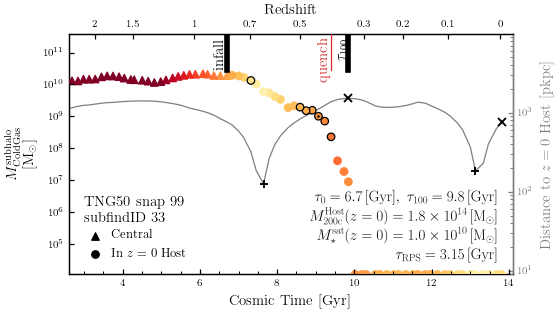

In [27]:
fig, ax = plot_SCGM_evolution_sincez2(grp_key, grp_dict, tau_dict)


<IPython.core.display.Javascript object>


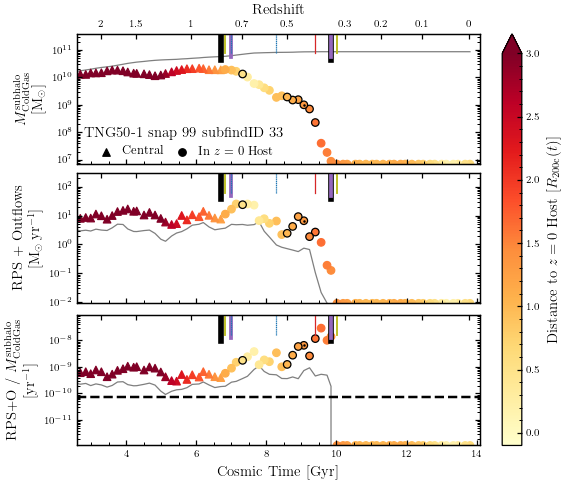

In [28]:
fig, axs = plot_SCGM_tracer_evolution_multipanel(grp_key, grp_dict, tau_dict, savefig=savefig)


<IPython.core.display.Javascript object>


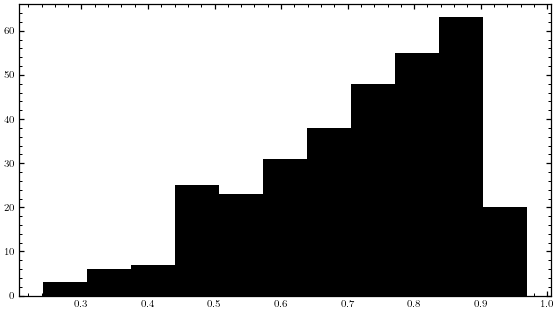

0.7443498783240277 0.5503724936949979 0.870668970060904


In [29]:
tau_dict = TNG50_dict[jel_key][tot_key].tau_dict
SCGM_infall = tau_dict['SubhaloColdGasMass_tau_RPS_tot0']
STGM_infall = tau_dict['SubhaloGasMass_tau_RPS_tot0']
Mstar_infall = tau_dict['Subhalo_Mstar_Rgal_tau_RPS_tot0']
mask = (SCGM_infall != -1) & (Mstar_infall > 1.0e8) & (Mstar_infall < 1.0e9)

cgas_frac = SCGM_infall[mask] / STGM_infall[mask]
plt.figure()
plt.hist(cgas_frac)
print(np.median(cgas_frac), np.percentile(cgas_frac, 16), np.percentile(cgas_frac, 84))

<IPython.core.display.Javascript object>


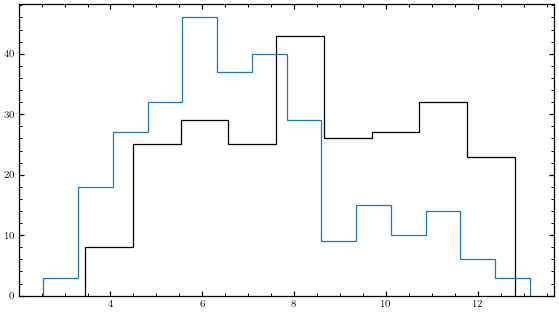

(array([ 3., 18., 27., 32., 46., 37., 40., 29.,  9., 15., 10., 14.,  6.,
         3.]),
 array([ 2.54036831,  3.29717149,  4.05397466,  4.81077784,  5.56758102,
         6.32438419,  7.08118737,  7.83799055,  8.59479372,  9.3515969 ,
        10.10840008, 10.86520326, 11.62200643, 12.37880961, 13.13561279]),
 [<matplotlib.patches.Polygon at 0x150412093730>])

In [30]:
infall_times = tau_dict['CosmicTime_tau_RPS_tot0']
M200cz0 = tau_dict[M200cz0_key]

mask1 = (infall_times != -1) & (M200cz0 >= 10.**(13.5))
mask2 = (infall_times != -1) & (M200cz0 < 10.**(13.5))

plt.figure()
plt.hist(infall_times[mask1], histtype='step')
plt.hist(infall_times[mask2], histtype='step')

In [65]:
x_key = Time_key
x_key_norm = tau0_RPS_tot_key

y_key = HCDn_key 

c_key = RPS_int_tot_key

y_binwidth = 0.20 # [r/r200c]
y_bins = np.arange(-y_binwidth/2.0, 4.0 + y_binwidth/2.0, y_binwidth)
x_binwidth = 0.15 # Gyr
x_max = 7.0 # gyr
x_min = -x_binwidth/2.0 # Gyr
x_bins = np.arange(x_min, x_max + x_binwidth/2.0, x_binwidth)

RPS_frac = 0.5

hist2d_kwargs = dict(origin='lower', cmap='viridis', aspect='auto',
                     norm=mpl.colors.LogNorm(vmin=1.0e-3, vmax=1.5e-1),
                     extent=(x_bins.min(), x_bins.max(), y_bins.min(), y_bins.max()))

fill_between_kwargs = dict(color='tab:gray', alpha=0.2)

cbar_label = r'RPS / Total RPS'
cbar_kwargs = dict(extend='both', label=cbar_label)

Tsinceinfall_label = r'Time Since Infall [Gyr]'

extent = [x_bins.min(), x_bins.max(), y_bins.min(), y_bins.max()]
levels = [0.005]

def calc_fracRPSloss(taudict_index, tau_dict, grp_dict, 
                     norm=True, peakRPS=True):
    """
    For a given galaxy in the tau_dict, calculate the 
    fractional RPS loss at each snapshot after infall.
    Give this value in a 2D array of host-centric distance vs
    time since infall.
    """
    
    result = np.zeros([y_bins.size-1, x_bins.size-1], dtype=float)
    if peakRPS:
        result_frac = result.copy()
        min_vals = [-1, -1, -1, -1]
        min_bins = [-1, -1, -1, -1]
        full_result = result, result_frac, min_vals, min_bins
    else:
        full_result = result
    
    subfindID = tau_dict['SubfindID'][taudict_index]
    grp_key = '%08d'%subfindID
    group = grp_dict[grp_key]
    
    subfind_indices = group['SubfindID'] != -1

    x_result = group[x_key][subfind_indices] - tau_dict[x_key_norm][taudict_index]
    indices = x_result >= 0
    infall_index = np.where(x_result == 0)[0]
        
    if infall_index.size != 1:
        print('grp_key %s has no infall index'%(grp_key))
        return full_result
    
    infall_index = infall_index[0]
    x = x_result[indices]

    c = group[c_key][subfind_indices][indices] - group[c_key][subfind_indices][1:infall_index+2]
    if norm:
        c_norm = c.sum()
        if c_norm == 0:
            print('grp_key %s has c_norm = 0'%(grp_key))
            return full_result 
        weights = c / c_norm
    else:
        weights = c
        
    y = group[y_key][subfind_indices][:infall_index+1]
    
    result[:,:] = np.histogram2d(y, x, bins=[y_bins, x_bins], weights=weights)[0]
    
    if not peakRPS:
        return result
    else:
        vals = weights[::-1]
        x_calc = x[::-1]
        y_calc = y[::-1]

        min_length = x_calc.max() - x_calc.min()
        for start_i, start in enumerate(x_calc):
            cumsum = np.cumsum(vals[start_i:])
            where = np.where(cumsum >= RPS_frac)[0]
            if where.size == 0:
                break
            end_i = where.min() + start_i + 1
            end = x_calc[end_i]
            length = x_calc[end_i] - start
            if length < min_length:
                min_length = length
                min_start_i = start_i
                min_end_i = end_i

        x_frac = x_calc[min_start_i:min_end_i]
        y_frac = y_calc[min_start_i:min_end_i]
        vals_frac = vals[min_start_i:min_end_i]

        result_frac[:,:] = np.histogram2d(y_frac, x_frac, bins=[y_bins, x_bins], weights=vals_frac)[0]

        x_min_frac = x_frac.min()
        x_max_frac = x_frac.max()
        y_min_frac = y_frac.min()
        y_max_frac = y_frac.max()

        x_min_i = np.digitize(x_min_frac, x_bins)
        x_max_i = np.digitize(x_max_frac, x_bins)
        y_min_i = np.digitize(y_min_frac, y_bins)
        y_max_i = np.digitize(y_max_frac, y_bins)

        if x_min_i == 0:
            x_min_bin = x_bins[y_min_i]
        else:
            x_min_bin = x_bins[x_min_i - 1]
        if x_max_i == x_bins.size:
            x_max_bin = x_bins[x_max_i - 1]
        else:
            x_max_bin = x_bins[x_max_i]
        if y_min_i == 0:
            y_min_bin = y_bins[y_min_i]
        else:
            y_min_bin = y_bins[y_min_i - 1]
        if y_max_i == y_bins.size:
            y_max_bin = y_bins[y_max_i - 1]
        else:
            y_max_bin = y_bins[y_max_i]

        min_vals = [x_min_frac, x_max_frac, y_min_frac, y_max_frac]
        min_bins = [x_min_bin, x_max_bin, y_min_bin, y_max_bin]

        return result, result_frac, min_vals, min_bins

def plot_fracRPSloss_halo(m200cz0_lolim=1.0e11, m200cz0_hilim=1.0e15,
                          tau_dict=TNG50_dict[jel_key][tot_key].tau_dict, grp_dict=grp_dict,
                          plot_profiles_flag=True):
    """
    write docstring here
    """
    
    m200cz0 = tau_dict[M200cz0_key]
    m200cz0_unique = np.unique(m200cz0)
    if m200cz0_lolim == m200cz0_hilim:    
        taudict_indices = np.where(m200cz0 == m200cz0_lolim)[0]
        nhalos = 1
    else:
        taudict_indices = np.where((m200cz0 >= m200cz0_lolim) & (m200cz0 < m200cz0_hilim))[0]
        nahlos = np.where((m200cz0_unique >= m200cz0_lolim) & (m200cz0_unique < m200cz0_hilim))[0]

    if taudict_indices.size == 0:
        print('taudict_indices.size == 0. Returning')
        return
        
    result = np.zeros([taudict_indices.size, y_bins.size-1, x_bins.size-1], dtype=float)

    for i, taudict_index in enumerate(taudict_indices):
        result[i,:,:] = calc_fracRPSloss(taudict_index, tau_dict, grp_dict, 
                                                     norm=False, peakRPS=False)
    hist = np.sum(result, axis=0)
    
    fig, ax = plt.subplots()
    h = ax.imshow(hist, origin='lower', norm=mpl.colors.LogNorm(), aspect='auto',
                  extent=(x_bins.min(), x_bins.max(), y_bins.min(), y_bins.max()))

    cbar = fig.colorbar(h, ax=ax)
    cbar.set_label(r'Total RPS [${\rm M_{\odot}}]$')
    ax.set_ylabel(HCDn_label)
    ax.set_xlabel(Tsinceinfall_label)

    title = (r'TNG50, $\log\left[M_{\rm 200c}^{\rm host} / {\rm M_\odot}\right] \in [%.1f, %.1f)\ (%d)$'%(np.log10(m200cz0_lolim), np.log10(m200cz0_hilim), nhalos) 
             + '\n total number of jellyfish: %d'%(taudict_indices.size))

    ax.set_title(title)

    if plot_profiles_flag:
        plot_profiles(hist, title, taudict_index)
    
    return fig, ax

def plot_profiles(hist, title, taudict_index):
    hist_time = np.sum(hist, axis=0)
    x_plot = (x_bins[1:] + x_bins[:-1]) / 2.
    fig, ax = plt.subplots()
    ax.plot(x_plot, hist_time)
    ax.set_yscale('log')
    ax.set_xlabel('time since infall')
    ax.set_ylabel(r'total amount of gas stripped')
    ax.set_title(title)

    hist_dist = np.sum(hist, axis=1)
    x_plot = (y_bins[1:] + y_bins[:-1]) / 2.
    fig, ax = plt.subplots()
    ax.plot(x_plot, hist_dist)
    ax.set_yscale('log')
    ax.set_xlabel('host centric distance [r200c]')
    ax.set_ylabel(r'total amount of gas stripped')
    ax.set_title(title)
    
    R200c = tau_dict['HostGroup_R_Crit200_z0'][taudict_index]
    x_plot[0] = y_bins[1] / 2.
    y_bins_phys  = y_bins * R200c
    vol_shells = (4./3.) * np.pi * ((y_bins_phys[2:])**3 - (y_bins_phys[1:-1])**3)
    vol_shells = np.insert(vol_shells, 0, (4./3.) * np.pi * (y_bins_phys[1])**3)
    dens_shells = hist_dist / vol_shells
    fig, ax = plt.subplots()
    ax.plot(x_plot, dens_shells)
    ax.set_yscale('log')
    ax.set_xlabel('host centric distance [r200c]')
    ax.set_ylabel(r'density of RPSed cold gas')
    ax.set_title(title)

    tot_gas = np.log10(np.sum(hist_dist))
    print('Total amount of deposited gas is %.2f log[Msun]'%(tot_gas))
    
    return

        
def plot_fracRPSloss_subhalo(subfindID, tau_dict, savefig=False,
                             labels=True, ax=None):
    """
    plot the fractional RPS loss as a 2d hist as functions of
    host centric distance and time since infall.
    """
    
    taudict_index = np.where(subfindID == tau_dict['SubfindID'])

    result = calc_fracRPSloss(taudict_index, tau_dict, grp_dict)
    hist2d = result[0]
    hist_frac = result[1]
    min_vals = result[2]
    min_bins = result[3]
    
    if not ax:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
        
    h = ax.imshow(hist2d, **hist2d_kwargs)
        
    ax.fill_between([min_bins[0], min_bins[1]], min_bins[2], min_bins[3], **fill_between_kwargs)
    
    title = r'TNG50, $z=0$, subfindID %d'%(subfindID)
    if labels:
        cbar = fig.colorbar(h, ax=ax, **cbar_kwargs)        
        ax.set_ylabel(HCDn_label)
        ax.set_xlabel(Tsinceinfall_label)
        ax.set_title(title)
    
    if savefig:
        fname = 'TNG50-1_snap-099_subfindID-%08d_fractionalRPSloss.pdf'%(subfindID)
        fig.savefig(direc_PP + fname, bbox_inches='tight')
        
    if not labels:
        return fig, ax, h
    
    return fig, ax


def plot_fracRPSloss_stack(Sim, savefig=False,
                           ax=None):
    """
    plot the stacked fractional RPS loss as a 2d hist.
    """

    if not ax:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
        
    tau_dict = Sim.tau_dict
        
    stacked_result, stacked_result_frac, x_min_vals, x_max_vals, y_min_vals, y_max_vals = calc_stacked_fracRPS(tau_dict)

    h = ax.imshow(stacked_result, **hist2d_kwargs)
    ax.contour(stacked_result_frac, extent=extent,
              colors='tab:gray', levels=levels)
    
    ax.set_title(Sim.plot_label)
    cbar = fig.colorbar(h, ax=ax, **cbar_kwargs)        
    ax.set_ylabel(HCDn_label)
    ax.set_xlabel(Tsinceinfall_label)

    if savefig:
        fname = 'TNG50_nogas_jellyfish_fractionalRPSloss.pdf'
        fig.savefig(direc_PP + fname, bbox_inches='tight')
    
    return fig, ax

def calc_stacked_fracRPS(tau_dict):
    """
    doc string goes here
    """
    SubfindID = tau_dict['SubfindID']
    hist2Ds = np.zeros([SubfindID.size, y_bins.size-1, x_bins.size-1])
    hist2Ds_frac = hist2Ds.copy()
    x_min_vals = np.zeros(SubfindID.size, dtype=float)
    x_max_vals = x_min_vals.copy()
    y_min_vals = x_min_vals.copy()
    y_max_vals = x_min_vals.copy()
    x_min_bins = x_min_vals.copy()
    x_max_bins = x_min_vals.copy()
    y_min_bins = x_min_vals.copy()
    y_max_bins = x_min_vals.copy()

    for taudict_index, _ in enumerate(SubfindID):
        result = calc_fracRPSloss(taudict_index, tau_dict, grp_dict)

        hist2Ds[taudict_index,:,:] = result[0]
        hist2Ds_frac[taudict_index,:,:] = result[1]
        min_vals = result[2]
        min_bins = result[3]

        x_min_vals[taudict_index] = min_vals[0]
        x_max_vals[taudict_index] = min_vals[1]
        y_min_vals[taudict_index] = min_vals[2]
        y_max_vals[taudict_index] = min_vals[3]


    stacked_result = np.ma.median(np.ma.masked_equal(hist2Ds,0),axis=0).data
    stacked_result_frac = np.ma.median(np.ma.masked_equal(hist2Ds_frac,0),axis=0).data
    
    return stacked_result, stacked_result_frac, x_min_vals, x_max_vals, y_min_vals, y_max_vals

<IPython.core.display.Javascript object>


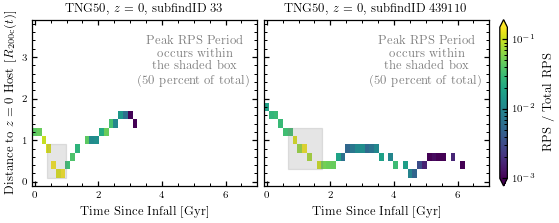

Text(3.25, 3.5, 'Peak RPS Period \n occurs within \n the shaded box \n (50 percent of total)')

In [62]:
tau_dict = TNG50_dict[jel_key][nogas_key].tau_dict

title_kwargs = dict(fontsize='small')
text_kwargs = dict(ha='left', va='top', ma='center', color='tab:gray', fontsize='small')
text = 'Peak RPS Period \n occurs within \n the shaded box \n (50 percent of total)'

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(figsizewidth, figsizewidth/2.5))

ax = axs[0]
ax.set_ylabel(HCDn_label, **title_kwargs)
ax.set_xlabel(Tsinceinfall_label, **title_kwargs)

subfindID = 33
fig, ax, _ = plot_fracRPSloss_subhalo(subfindID, tau_dict, savefig=False, ax=ax, labels=False)
title = r'TNG50, $z=0$, subfindID %d'%(subfindID)
ax.set_title(title, **title_kwargs)
ax.text(3.25, 3.5, text, **text_kwargs)


ax = axs[1]
subfindID = 439110
title = r'TNG50, $z=0$, subfindID %d'%(subfindID)
ax.set_xlabel(Tsinceinfall_label, **title_kwargs)
fig, ax, h = plot_fracRPSloss_subhalo(subfindID, tau_dict, savefig=False, labels=False, ax=ax)
cbar = fig.colorbar(h, ax=ax, **cbar_kwargs)
cbar.set_label(cbar_label, fontsize='small')
ax.set_title(title, **title_kwargs)
ax.text(3.25, 3.5, text, **text_kwargs)

#fig.savefig(direc_PP + 'fig9a.pdf', bbox_inches='tight')

<IPython.core.display.Javascript object>


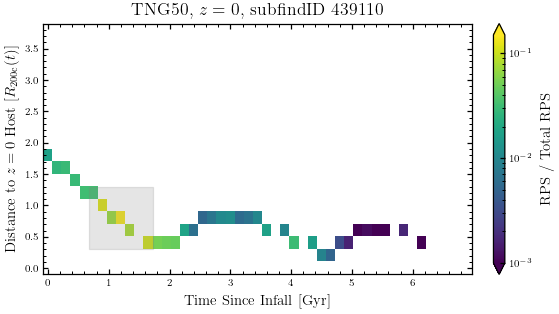

In [33]:

tau_dict = TNG50_dict[jel_key][nogas_key].tau_dict
subfindID = 439110

fig, ax = plot_fracRPSloss_subhalo(subfindID, tau_dict, savefig=False)



<IPython.core.display.Javascript object>


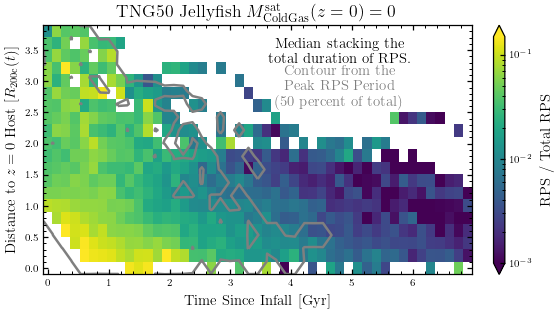

grp_key 00000327 has no infall index
grp_key 00167546 has no infall index
grp_key 00167553 has no infall index
grp_key 00198258 has no infall index
grp_key 00275670 has no infall index
grp_key 00282873 has no infall index
grp_key 00301010 has no infall index


Text(4.8, 3.275, 'Contour from the \n Peak RPS Period \n (50 percent of total)')

In [34]:
Sim = TNG50_dict[jel_key][nogas_key]
fig, ax = plot_fracRPSloss_stack(Sim)
text = 'Median stacking the \n total duration of RPS.'
ax.text(4.8, 3.7, text, ha='center', va='top', ma='center')
text = 'Contour from the \n Peak RPS Period \n (50 percent of total)'
ax.text(4.8, 3.275, text, ha='center', va='top', ma='center', color='tab:gray')
#fig.savefig(direc_PP + 'fig9b.pdf', bbox_inches='tight')

grp_key 00000327 has no infall index
grp_key 00167546 has no infall index
grp_key 00167553 has no infall index
grp_key 00198258 has no infall index
grp_key 00275670 has no infall index
grp_key 00282873 has no infall index
grp_key 00301010 has no infall index


<IPython.core.display.Javascript object>


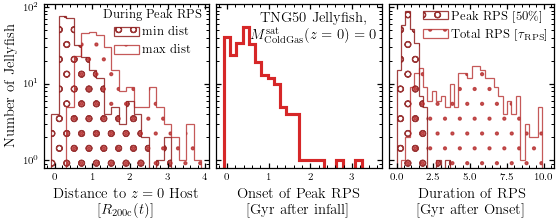

Text(0.5, 0, 'Duration of RPS \n [Gyr after Onset]')

In [35]:
Sim = TNG50_dict[jel_key][nogas_key]
tau_dict = Sim.tau_dict
stacked_result, stacked_result_frac, x_min_vals, x_max_vals, y_min_vals, y_max_vals = calc_stacked_fracRPS(tau_dict)

mask = x_min_vals != -1

peakRPS_len = x_max_vals[mask] - x_min_vals[mask]

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(figsizewidth, figsizewidth / 2.5))
axs[0].set_ylabel(r'Number of Jellyfish')
#axs[0].set_yscale('log')

histkwargs_ymins = {**hist_kwargs, 'hatch':'o', 'color':'maroon', 'alpha':0.75, 'label':r'min dist'}
histkwargs_ymaxs = {**hist_kwargs, 'hatch':'.', 'color':'firebrick', 'alpha':0.75, 'label':r'max dist'}

ax = axs[0]
ax.hist(y_min_vals[mask], bins=y_bins, **histkwargs_ymins)
ax.hist(y_max_vals[mask], bins=y_bins, **histkwargs_ymaxs)
ax.legend(fontsize='small', title='During Peak RPS', title_fontsize='small')
ax.set_xlabel(r'Distance to $z=0$ Host' + '\n' + r'$[R_{\rm 200c}(t)]$')
ax.set_yscale('log')

ax = axs[1]
binwidth = 0.15
bin_start = -binwidth/2.0
bin_end = x_min_vals[mask].max() + binwidth/2.0
bins = np.arange(bin_start, bin_end, binwidth)
ax.hist(x_min_vals[mask], bins=bins, **Sim.histkwargs)
ax.set_xlabel('Onset of Peak RPS \n [Gyr after infall]')
text = 'TNG50 Jellyfish, \n' + r'$M_{\rm ColdGas}^{\rm sat}(z=0) = 0$'
ax.text(0.975, 0.95, text, va='top', ha='right', ma='center', transform=ax.transAxes)

ax = axs[2]
binwidth = 0.30
bin_start = 0.0
bin_end = 10.5
bins = np.arange(bin_start, bin_end, binwidth)
histkwargs_peakRPS = histkwargs_ymins.copy()
histkwargs_peakRPS['label'] = 'Peak RPS [50\%]'
ax.hist(peakRPS_len, bins=bins, **histkwargs_peakRPS)

totalRPS = tau_dict[tstrip_key][mask]
histkwargs_totalRPS = histkwargs_ymaxs.copy()
histkwargs_totalRPS['label'] = r'Total RPS [$\tau_{\rm RPS}$]'
ax.hist(totalRPS, bins=bins, **histkwargs_totalRPS)
ax.legend(fontsize='small')
ax.set_xlabel('Duration of RPS \n [Gyr after Onset]')
#fig.savefig(direc_PP + 'fig9c.pdf', bbox_inches='tight')

<IPython.core.display.Javascript object>


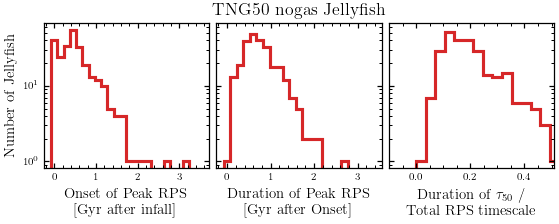

In [36]:
percentage = 0.50

min_starts = x_min_vals
min_lens = x_max_vals - x_min_vals

mask = min_starts != -1

starts = min_starts[mask]
tstrip50 = min_lens[mask]

tstrip50_norm = tstrip50 / tau_dict['Tstrip_tau_RPS_tot_tau0-tau100'][mask]

tau_val = int(round(percentage * 100))

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(figsizewidth, figsizewidth / 2.5))
axs[1].set_title('TNG50 nogas Jellyfish')

hist_kwargs = Sim.histkwargs

y_label = 'Number of Jellyfish'
axs[0].set_ylabel(y_label)
axs[0].set_xlabel('Onset of Peak RPS \n [Gyr after infall]')
binwidth = 0.15
bin_start = -binwidth/2.0
bin_end = starts.max() + binwidth/2.0
bins = np.arange(bin_start, bin_end, binwidth)
axs[0].hist(starts, bins=bins, **hist_kwargs)
axs[0].set_yscale('log')

binwidth = 0.15
bin_start = -binwidth/2.0
bin_end = tstrip50.max() + binwidth/2.0 + binwidth*1.0e-3
bins = np.arange(bin_start, bin_end, binwidth)
axs[1].hist(tstrip50, bins=bins, **hist_kwargs)
axs[1].set_xlabel('Duration of Peak RPS \n [Gyr after Onset]')
#axs[1].set_xlim(-0.1, 5.1)

axs[2].hist(tstrip50_norm, **hist_kwargs)
axs[2].set_xlabel(r'Duration of $\tau_{%d}$ / '%(tau_val) + '\n Total RPS timescale')
axs[2].set_xlim(-0.1, 0.51)

fname = 'TNG50_nogas_cleaned_jellyfish_tau%d_RPS_hists.pdf'%(tau_val)
#fig.savefig(direc_PP + fname, bbox_inches='tight')


<IPython.core.display.Javascript object>


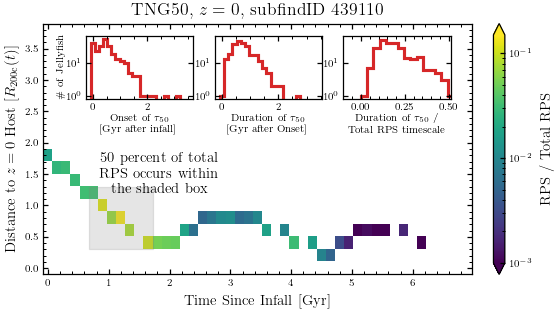

In [37]:
subfindID = 439110
fig, ax = plot_fracRPSloss_subhalo(subfindID, tau_dict, savefig=False)
ax.text(0.845, 1.15, '50 percent of total \n RPS occurs within \n the shaded box', ha='left', va='bottom', ma='center')

y_label = '\# of Jellyfish'
x_label = r'Onset of $\tau_{%d}$'%(tau_val) + '\n [Gyr after infall]'
axins1 = ax.inset_axes([0.1, 0.7, 0.25, 0.25], transform=ax.transAxes)
axins1.set_xlabel(x_label, fontsize='x-small', labelpad=1)
axins1.set_ylabel(y_label, fontsize='x-small', labelpad=1)
#axins1.set_xlabel(x_label)
binwidth = 0.15
bin_start = -binwidth/2.0
bin_end = starts.max() + binwidth/2.0
bins = np.arange(bin_start, bin_end, binwidth)
axins1.hist(starts, bins=bins, **hist_kwargs)
axins1.set_yscale('log')

axins2 = ax.inset_axes([0.4, 0.7, 0.25, 0.25], transform=ax.transAxes, sharey=axins1)

binwidth = 0.15
bin_start = -binwidth/2.0
bin_end = tstrip50.max() + binwidth/2.0 + binwidth*1.0e-3
bins = np.arange(bin_start, bin_end, binwidth)
axins2.hist(tstrip50, bins=bins, **hist_kwargs)
axins2.set_xlabel(r'Duration of $\tau_{%d}$'%(tau_val) + '\n [Gyr after Onset]',
                 fontsize='x-small', labelpad=1)

axins3 = ax.inset_axes([0.7, 0.7, 0.25, 0.25], transform=ax.transAxes, sharey=axins1)

axins3.hist(tstrip50_norm, **hist_kwargs)
axins3.set_xlabel(r'Duration of $\tau_{%d}$ / '%(tau_val) + '\n Total RPS timescale',
                 fontsize='x-small', labelpad=1)
axins3.set_xlim(-0.1, 0.51)
fname = 'fig9b.pdf'
#fig.savefig(direc_PP + fname, bbox_inches='tight')


<IPython.core.display.Javascript object>


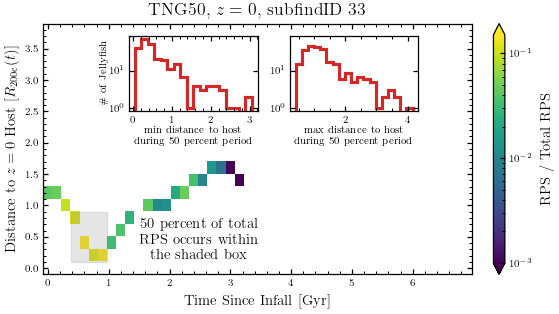

In [38]:


subfindID = 33

fig, ax = plot_fracRPSloss_subhalo(subfindID, tau_dict, savefig=False)
ax.text(1.5, 0.8, '50 percent of total \n RPS occurs within \n the shaded box', ha='left', va='top', ma='center')

y_label = '\# of Jellyfish'
x_label = 'min distance to host \n during 50 percent period'
axins1 = ax.inset_axes([0.2, 0.65, 0.3, 0.3], transform=ax.transAxes)
axins1.set_xlabel(x_label, fontsize='x-small', labelpad=1)
axins1.set_ylabel(y_label, fontsize='x-small', labelpad=1)
#axins1.set_xlabel(x_label)
axins1.hist(y_min_vals[mask], **hist_kwargs)
axins1.set_yscale('log')


axins2 = ax.inset_axes([0.575, 0.65, 0.3, 0.3], transform=ax.transAxes, sharey=axins1)

x_label = 'max distance to host \n during 50 percent period'
axins2.hist(y_max_vals[mask], **hist_kwargs)
axins2.set_xlabel(x_label,
                 fontsize='x-small', labelpad=1)

fname = 'fig9a.pdf'
#fig.savefig(direc_PP + fname, bbox_inches='tight')



grp_key 00000327 has no infall index


<IPython.core.display.Javascript object>


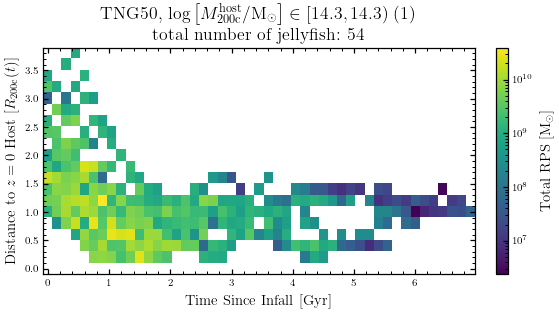

<IPython.core.display.Javascript object>


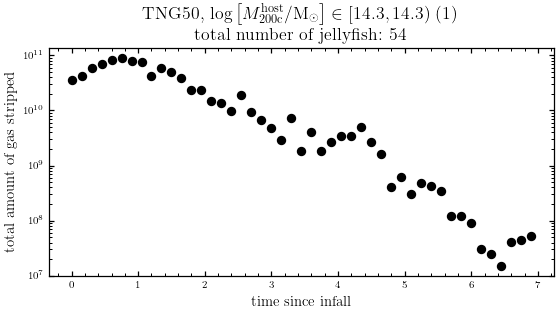

/tmp/ipykernel_67845/1993144348.py:197: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


<IPython.core.display.Javascript object>


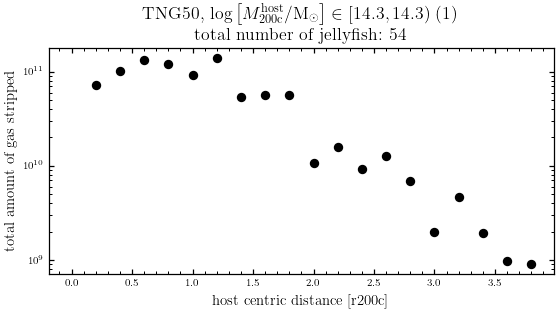

<IPython.core.display.Javascript object>


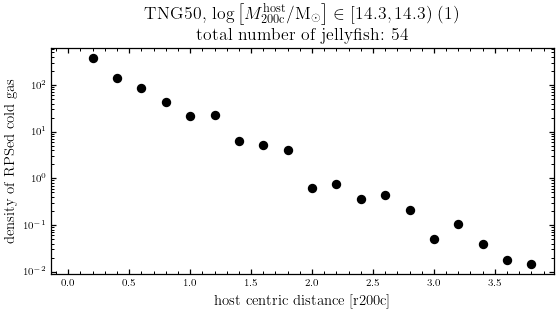

Total amount of deposited gas is 11.95 log[Msun]


In [66]:
tau_dict = TNG50_dict[jel_key][tot_key].tau_dict
M200cz0 = tau_dict[M200cz0_key]
M200cz0_unique = np.unique(M200cz0)[::-1]
halomass = M200cz0_unique[0]

fig, ax = plot_fracRPSloss_halo(m200cz0_lolim=halomass, m200cz0_hilim=halomass,
                          tau_dict=TNG50_dict[jel_key][tot_key].tau_dict, grp_dict=grp_dict,
                          plot_profiles_flag=True)


<IPython.core.display.Javascript object>


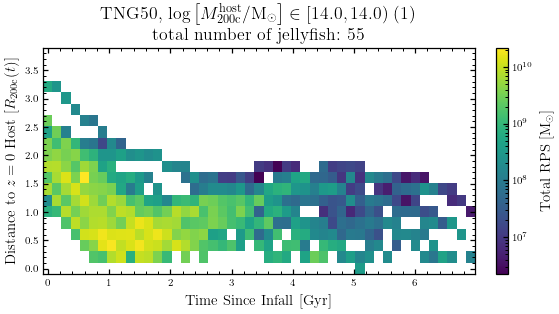

<IPython.core.display.Javascript object>


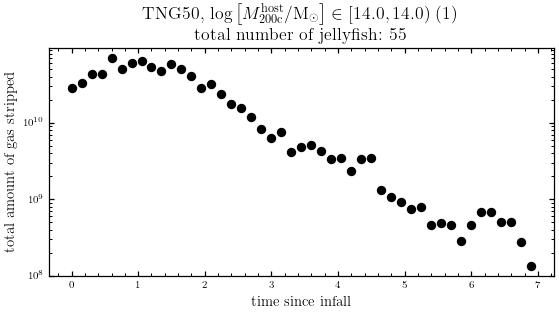

/tmp/ipykernel_67845/3993961537.py:192: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


<IPython.core.display.Javascript object>


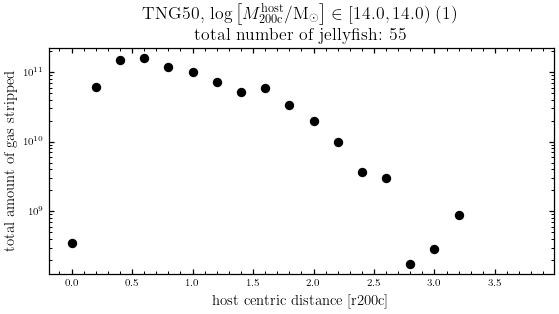

Total amount of deposited gas is 11.93 log[Msun]


In [42]:
halomass = M200cz0_unique[1]

fig, ax = plot_fracRPSloss_halo(m200cz0_lolim=halomass, m200cz0_hilim=halomass,
                          tau_dict=TNG50_dict[jel_key][tot_key].tau_dict, grp_dict=grp_dict,
                          plot_profiles=True)

In [ ]:
### define some global binning and plotting parameters + useful keys and their labels ### 
global jel_key, non_key, ins_key, taudict_keys
global mass_binwdith, time_binwidth, figsizewidth, NGaussSmooth, gal_boundary
global hist_kwargs, sc_kwargs, text_kwargs, axislabel_kwargs, legend_kwargs, median_kwargs, one_one_kwargs, gal_boundary_kwargs
global Mstarz0_key, M200cz0_key, muz0_key, MCGasz0_key, MHGasz0_key, MTGasz0_key
global Mstarz0_label, M200cz0_label, muz0_label, MCgasz0_label, MHgasz0_label, MTGasz0_label, Nbranches_label
global tau0_infall_key, tau90_infall_key, tstrip_infall_key, tau0_medpeak_key, tau90_medpeak_key, tstrip_medpeak_key, tstrip_key
global tau0_infall_label, tau90_infall_label, tstrip_infall_label, tau0_medpeak_label, tau90_medpeak_label, tstrip_medpeak_label
global quenchtime_key, quenchtimescale_key, quenchtime_label, quenchtimescale_label
global d90_infall_key, d90_medpeak_key, min_d_tau90_infall_key, min_d_tau90_medpeak_key, d90_key, min_d_tau90_key
global d90_infall_label, d90_medpeak_label, min_d_tau90_infall_key, min_d_tau90_medpeak_key, d90_label, min_d_tau90_label
global Nperipass_tau90_infall_key, Nperipass_tau90_medpeak_key, Nperipass_tau90_key
global direc_ol, direc_MPCDF, direc_list 

jel_key = 'jellyfish'
non_key = 'nonjellyf'
ins_key = 'inspected'
taudict_keys = [jel_key, non_key, ins_key]

mass_binwidth = 0.25
time_binwidth = 0.50 

NGaussSmooth = 1000

figsizewidth  = 6.902 # the textwidth in inches of MNRAS
figsizeratio = 9. / 16.
figsizeheight = figsizewidth * figsizeratio

figsizewidth_fullpage = figsizewidth
figsizeheight_fullpage = figsizewidth_fullpage * figsizeratio
figsizewidth_column = (244. / 508.) * figsizewidth
figsizeheight_column = figsizewidth_column * figsizeratio

gal_boundary = 0.15

hist_kwargs         = dict(histtype='step', ls='-')
sc_kwargs           = dict(s=4**2, alpha=1.0, zorder=1.01, marker = r"$\rm{{{0:s}}}$".format('\u25EF'), linewidths=0.75)
text_kwargs         = dict()
axislabel_kwargs    = dict()
legend_kwargs       = dict()
median_kwargs       = dict()
one_one_kwargs      = dict(ls='-', marker='None', c='k', zorder=1.0, lw=2.5)
gal_boundary_kwargs = dict(marker='None', ls='--', c='k', zorder=0.9)

Mstarz0_key = 'Subhalo_Mstar_Rgal_z0'
M200cz0_key = 'HostGroup_M_Crit200_z0'
muz0_key    = 'muz0'
MCGasz0_key = 'SubhaloColdGasMass_z0'
MHGasz0_key = 'SubhaloHotGasMass_z0'
MTGasz0_key = 'SubhaloGasMass_z0'

Mstarz0_label   = r'$M_{\star}^{\rm sat}(z=0)\, [{\rm M_\odot}]$'
M200cz0_label   = r'$M_{\rm 200c}^{\rm host}(z=0)\, [{\rm M_\odot}]$'
muz0_label      = r'$\mu \equiv M_{\star}^{\rm sat} / M_{\rm 200c}^{\rm host} (z=0)$'
MCGasz0_label   = r'$M_{\rm ColdGas}^{\rm sat}(z=0)\, [{\rm M_\odot}]$'
MHGasz0_label   = r'$M_{\rm HotGas}^{\rm sat}(z=0)\, [{\rm M_\odot}]$'
MTGasz0_label   = r'$M_{\rm TotGas}^{\rm sat}(z=0)\, [{\rm M_\odot}]$'
Nbranches_label = r'Number of Branches' 

tau0_infall_key    = 'CosmicTime_tau_infall0'
tau90_infall_key   = 'CosmicTime_tau_infall90'
tstrip_infall_key  = 'Tstrip_tau_infall_tau0-tau90'
tau0_medpeak_key   = 'CosmicTime_tau_medpeak0'
tau90_medpeak_key  = 'CosmicTime_tau_medpeak90'
tstrip_medpeak_key = 'Tstrip_tau_medpeak_tau10-tau90'
tstrip_key         = tstrip_medpeak_key

tau0_infall_label    = r'Cosmic Time at Infall [Gyr]'
tau90_infall_label   = r'Cosmic Time at $\tau_{90}$ [infall] [Gyr]'
tstrip_infall_label  = r'$\tau_{90} - \tau_{10}$ [infall] [Gyr]'
tau0_medpeak_label   = r'Cosmic Time at Peak $M_{\rm ColdGas}^{\rm sat}$ [Gyr]'
tau90_medpeak_label  = r'Cosmic Time at $\tau_{90}$ [peak $M_{\rm ColdGas}^{\rm sat}$] [Gyr]'
tstrip_medpeak_label = r'$\tau_{90} - \tau_{10}$ via Peak $M_{\rm ColdGas}^{\rm sat}$ [Gyr]'
tstrip_label         = r'Cold Gas Loss Timescale [$\tau_{90} - \tau_{10}$] [Gyr]'

tau0_RPS_est_key = 'CosmicTime_tau_RPS_est0'
tau90_RPS_est_key = 'CosmicTime_tau_RPS_est90'
tau100_RPS_est_key = 'CosmicTime_tau_RPS_est100'
tau0_RPS_tot_key = 'CosmicTime_tau_RPS_tot0'
tau90_RPS_tot_key = 'CosmicTime_tau_RPS_tot90'
tau100_RPS_tot_key = 'CosmicTime_tau_RPS_tot100'
tau0_RPS_sRPS_key = 'CosmicTime_tau_RPS_sRPS0'
tau100_RPS_sRPS_key = 'CosmicTime_tau_RPS_sRPS100'
tstrip_RPS_est_key = 'Tstrip_tau_RPS_est_tau0-tau100'
tstrip_RPS_tot_key = 'Tstrip_tau_RPS_tot_tau0-tau100'
tstrip_RPS_sRPS_key = 'Tstrip_tau_RPS_sRPS_tau0-tau100'

tau0_RPS_tot_label = r'Cosmic Time at Infall [$\tau_0$] [Gyr]'
tau90_RPS_tot_label = r'Cosmic Time at $\tau_{90}$ [RPS tot] [Gyr]'
tau100_RPS_tot_label = r'Cosmic Time at $\tau_{100}$ [RPS tot] [Gyr]'
tstrip_RPS_tot_label = r'$\tau_{\rm RPS}$ [RPS tot] [Gyr]'

tau0_RPS_est_label = r'Cosmic Time at $\tau_0$ [RPS est] [Gyr]'
tau90_RPS_est_label = r'Cosmic Time at $\tau_{90}$ [RPS est] [Gyr]'
tau100_RPS_est_label = r'Cosmic Time at $\tau_{100}$ [RPS est] [Gyr]'
tstrip_RPS_est_label = r'$\tau_{\rm RPS}$ [RPS est] [Gyr]'

tau0_RPS_sRPS_label = r'Cosmic Time at $\tau_0$ [RPS sRPS] [Gyr]'
tau100_RPS_sRPS_label = r'Cosmic Time at $\tau_{100}$ [RPS sRPS] [Gyr]'
tstrip_RPS_sRPS_label = r'$\tau_{\rm RPS}$ [RPS sRPS] [Gyr]'

d0_RPS_tot_key = 'HostCentricDistance_norm_tau_RPS_tot0'
d0_RPS_tot_label = r'$d_{\rm sat}^{\rm host}(\tau_0)\, [R_{\rm 200c}^{\rm host}(\tau_0)]$'

quenchtime_key              = 'CosmicTime_quench'
quenchtimescale_infall_key  = 'Tquench_tau_infall'
quenchtimescale_medpeak_key = 'Tquench_tau_medpeak'
quenchtime_label            = 'Cosmic Time at Last Quenching [Gyr]'
quenchtimescale_label       = 'Time of Last Quenching - Infall [Gyr]'
d90_infall_key              = 'HostCentricDistance_norm_tau_infall90'
d90_medpeak_key             = 'HostCentricDistance_norm_tau_medpeak90'
min_d_tau90_infall_key      = 'min_HostCentricDistance_norm_tau_infall90'
min_d_tau90_medpeak_key     = 'min_HostCentricDistance_norm_tau_medpeak90'
d90_key                     = d90_medpeak_key
min_d_tau90_key             = min_d_tau90_medpeak_key

d90_infall_label          = r'$d_{\rm sat}^{\rm host}(\tau_{90})\, [R_{\rm 200c}^{\rm host}(\tau_{90})]$'
d90_medpeak_label         = d90_infall_label
min_d_tau90_infall_label  = r'min $d_{\rm sat}^{\rm host}(\leq \tau_{90})\, [R_{\rm 200c}^{\rm host}(t_{{\rm min}\, d})]$'
min_d_tau90_medpeak_label = min_d_tau90_infall_label
d90_label                 = d90_medpeak_label
min_d_tau90_label         = min_d_tau90_medpeak_label

Nperipass_tau90_infall_key  = 'Nperipass_tau_infall90'
Nperipass_tau90_medpeak_key = 'Nperipass_tau_medpeak90'
Nperipass_tau90_key         = Nperipass_tau90_medpeak_key

direc_ol    = '/Users/rohr/Dropbox/Apps/Overleaf/Rohretal_TNG_WhenAndWhereRPSOccurs/figures/'
direc_MPCDF = '/Users/rohr/MPCDFDataShare/Rohr_Pillepich/Figures/JellyfishEvolution/Figures/'
direc_list  = [direc_MPCDF]

direc_list = ['../Figures/Tracers/TNG50-1/SummaryPlots/']
direc_PP = '../Figures/Tracers/TNG50-1/PaperPlots/'

fgas_infall_key = 'SubhaloColdGasFraction_tau_RPS_tot0'
fgas_infall_label = r'$f_{\rm ColdGas}(\tau_0)\equiv M_{\rm ColdGas}^{\rm sat}(\tau_0) / M_{\star}^{\rm sat}(\tau_0)$'
SCGM_infall_key = 'SubhaloColdGasMass_tau_RPS_tot0'
SCGM_infall_label = r'$M_{\rm ColdGas}^{\rm sat}(\tau_0)$'
Mstar_infall_key = 'Subhalo_Mstar_Rgal_tau_RPS_tot0'


In [ ]:
fgas_infall_key = 'SubhaloColdGasFraction_tau_RPS_tot0'
fgas_infall_label = r'$f_{\rm ColdGas}(\tau_0)\equiv M_{\rm ColdGas}^{\rm sat}(\tau_0) / M_{\star}^{\rm sat}(\tau_0)$'
SCGM_infall_key = 'SubhaloColdGasMass_tau_RPS_tot0'
SCGM_infall_label = r'$M_{\rm ColdGas}^{\rm sat}(\tau_0)$'
Mstar_infall_key = 'Subhalo_Mstar_Rgal_tau_RPS_tot0'

In [ ]:
class TNGSim:
    
    def __init__(self, sim, taudict_keys, M200cz0_bins, Mstarz0_bins,
                 tot=True, gas=False, nogas=False):
        
        # sim should be 'TNG50-1' or 'TNG100-1'
        
        # if keys is a string, replace with a list
        if isinstance(taudict_keys, six.string_types):
            keys = [keys]
            
        self.sim  = sim
        self.taudict_keys = taudict_keys.copy()
        self.tot = tot
        self.gas = gas
        self.nogas = nogas
        
        self.sim_label = sim[:-2]
        if gas:
            self.sim_label += ' gas'
        elif nogas:
            self.sim_label += ' nogas'
                       
        # repeat for the tau dictionaries
        tau_dict = {}
        for taudict_key in taudict_keys:
            tau_dict[taudict_key] = self.load_taudict(taudict_key, tot=tot, gas=gas, nogas=nogas)
                    
        self.tau_dict = tau_dict
        
        tau_dict_keys = {}
        for key in tau_dict.keys():
            tau_dict_keys[key] = np.array(list(tau_dict[key].keys()))
        self.tau_dict_keys = tau_dict_keys    
        
        #### define some bins and kwargs for plotting ###
        # only works if jellyfish, nonjellyf, and inspected keys are used in this order!!!
        if ('jellyfish' not in self.taudict_keys[0]) or ('nonjellyf' not in self.taudict_keys[1]) or ('inspected' not in self.taudict_keys[2]):
            print('Error with the input keys', taudict_keys)
            print('Here are self.taudict_keys', self.taudict_keys)
            return
        
        self.jel_key = jel_key
        self.non_key = non_key
        self.ins_key = ins_key
        
        labels_dict = {}
        labels_dict[jel_key] = 'Jellyfish'
        labels_dict[non_key] = 'Non-Jelly'
        labels_dict[ins_key] = 'Inspected'
        self.labels_dict = labels_dict
        
        histkwargs_dict = {}
        histkwargs_dict[jel_key] = dict(**hist_kwargs, color='tab:blue', lw=2.5, zorder=2.2)
        histkwargs_dict[non_key] = dict(**hist_kwargs, color='tab:orange', lw=2.0, zorder=2.1)
        histkwargs_dict[ins_key] = dict(**hist_kwargs, color='tab:gray', lw=3.0, zorder=2.0)
        self.histkwargs_dict = histkwargs_dict
        
        cmaps_dict = {}
        cmaps_dict[jel_key] = mpl.cm.get_cmap('Blues')
        cmaps_dict[non_key] = mpl.cm.get_cmap('Oranges')
        cmaps_dict[ins_key] = mpl.cm.get_cmap('Greys')
        self.cmaps_dict = cmaps_dict
        
        sckwargs_dict = {}
        sckwargs_dict[M200cz0_key] = dict(**sc_kwargs, cmap='plasma',
                                          norm=mpl.colors.LogNorm(vmin=10.**min(M200cz0_bins), vmax=10.**(max(M200cz0_bins))))
        sckwargs_dict[Mstarz0_key] = dict(**sc_kwargs, cmap='viridis',
                                          norm=mpl.colors.LogNorm(vmin=10.**(min(Mstarz0_bins)), vmax=10.**(max(Mstarz0_bins))))
        sckwargs_dict[muz0_key]    = dict(**sc_kwargs, cmap='cubehelix_r',
                                          norm=mpl.colors.LogNorm(vmin=10.**(-5.5), vmax=10.**(-2.5)))
        self.sckwargs_dict = sckwargs_dict
        
        ### define histogram kwargs for binning tstrip by M200cz0, Mstarz0, or tau0_infall ###
        ### NB -- must have two sets of histogram kwargs for the two definitions of tstrip ###
        tstrip_infall_dict = {}
        tstrip_medpeak_dict = {}
        histkwargs_list_key = 'histkwargs_list'
        
        # M200cz0
        # medpeak definition
        tstrip_medpeak_dict[M200cz0_key] = dict(key=M200cz0_key, label=M200cz0_label,
                                                savelabel=r'm200cz0', bins=M200cz0_bins)
        
        histkwargs_list    = [{}] * (len(M200cz0_bins) - 1)
        histkwargs_list[0] = dict(**hist_kwargs, color='navy', lw=1.5, zorder=1.05)
        histkwargs_list[1] = dict(**hist_kwargs, color='darkviolet', lw=2.5, zorder=1.15)
        histkwargs_list[2] = dict(**hist_kwargs, color='darkorange', lw=3.5, zorder=1.25)
        tstrip_medpeak_dict[M200cz0_key][histkwargs_list_key] = histkwargs_list
        
        # infall definition
        tstrip_infall_dict[M200cz0_key] = dict(key=M200cz0_key, label=M200cz0_label,
                                               savelabel=r'm200cz0', bins=M200cz0_bins)

        histkwargs_list    = [{}] * (len(M200cz0_bins) - 1)
        histkwargs_list[0] = dict(**hist_kwargs, color='mediumblue', lw=1.0, zorder=1.01)
        histkwargs_list[1] = dict(**hist_kwargs, color='mediumorchid', lw=2.0, zorder=1.09)
        histkwargs_list[2] = dict(**hist_kwargs, color='lightsalmon', lw=3.0, zorder=1.19)
        for i, _ in enumerate(histkwargs_list):
            histkwargs_list[i]['ls'] = '--'
        tstrip_infall_dict[M200cz0_key][histkwargs_list_key] = histkwargs_list
        
        # fgas(tau_0) -- medpeak definition
        fgas_infall_bins = [0.0, 0.5, 1.0, 1.5]
        histkwargs_list = [{}] * (len(fgas_infall_bins) - 1)
        
        tstrip_medpeak_dict[fgas_infall_key] = dict(key=fgas_infall_key, label=fgas_infall_label,
                                                savelabel=r'fgasinfall', bins=fgas_infall_bins)
        
        histkwargs_list[0] = dict(**hist_kwargs, color='darkslategray', lw=2.0)
        histkwargs_list[1] = dict(**hist_kwargs, color='seagreen', lw=1.5)
        histkwargs_list[2] = dict(**hist_kwargs, color='wheat', lw=1.0)
        tstrip_medpeak_dict[fgas_infall_key][histkwargs_list_key] = histkwargs_list

        # SCGM(infall)
        SCGM_infall_bins = [9.0, 9.5, 10., 10.5]
        tstrip_medpeak_dict[SCGM_infall_key] = dict(key=SCGM_infall_key, label=SCGM_infall_label,
                                                    savelabel=r'SCGMinfall', bins=SCGM_infall_bins)
        tstrip_medpeak_dict[SCGM_infall_key][histkwargs_list_key] = histkwargs_list
        
        
        # Mstarz0 -- medpeak definition
        histkwargs_list = [{}] * (len(Mstarz0_bins) - 1)
        
        tstrip_medpeak_dict[Mstarz0_key] = dict(key=Mstarz0_key, label=Mstarz0_label,
                                                savelabel=r'mstarz0', bins=Mstarz0_bins)
        
        histkwargs_list[0] = dict(**hist_kwargs, color='slateblue', lw=2.0)
        histkwargs_list[1] = dict(**hist_kwargs, color='teal', lw=1.5)
        histkwargs_list[2] = dict(**hist_kwargs, color='yellowgreen', lw=1.0)
        tstrip_medpeak_dict[Mstarz0_key][histkwargs_list_key] = histkwargs_list
        
        # infall defintion 
        tstrip_infall_dict[Mstarz0_key] = dict(key=Mstarz0_key, label=Mstarz0_label,
                                               savelabel=r'mstarz0', bins=Mstarz0_bins)
        tstrip_infall_dict[Mstarz0_key][histkwargs_list_key] = histkwargs_list
        
        # tau0_infall -- only infall definition 
        tau0_infall_bins = [5.0, 7.5, 10.0, 12.5]
        histkwargs_list  = [{}] * (len(tau0_infall_bins) - 1)
        
        tstrip_medpeak_dict[tau0_infall_key] = dict(key=tau0_infall_key, label=tau0_infall_label,
                                                    savelabel='infalltime', bins=tau0_infall_bins)
        
        histkwargs_list[0] = dict(**hist_kwargs, color='royalblue', lw=2.0)
        histkwargs_list[1] = dict(**hist_kwargs, color='slategray', lw=1.5)
        histkwargs_list[2] = dict(**hist_kwargs, color='goldenrod', lw=1.0)
        tstrip_medpeak_dict[tau0_infall_key][histkwargs_list_key] = histkwargs_list
        
        tstrip_infall_dict[tau0_infall_key] = dict(key=tau0_infall_key, label=tau0_infall_label,
                                                   savelabel='infalltime', bins=tau0_infall_bins)
        tstrip_infall_dict[tau0_infall_key][histkwargs_list_key] = histkwargs_list
        
        # add these dictionaries to the class
        tstrip_histbins_dict = {tstrip_RPS_tot_key:tstrip_medpeak_dict, tstrip_RPS_sRPS_key:tstrip_infall_dict}
                                
        self.tstrip_histbins_dict = tstrip_histbins_dict

    
        return
    
    
    def load_taudict(self, key, tot=True, nogas=False, gas=False):

        result = {}
        fname = return_taudict_fname(self.sim, key, tot=tot, nogas=nogas, gas=gas)
        with h5py.File('../Output/%s_subfindGRP/'%self.sim + fname, 'a') as f:
            group = f['Group']
            for dset_key in group.keys():
                result[dset_key] = group[dset_key][:]
            f.close()
            
        return result
    
    
def return_taudict_fname(sim='TNG50-1', key=jel_key, tot=True, nogas=False, gas=False):
    
    fname = 'zooniverse_%s_%s_clean_tau'%(sim, key)
    if tot:
        fname += '.hdf5'
    elif nogas:
        fname += '_nogasz0.hdf5'
    elif gas:
        fname += '_gasz0.hdf5'
        
    return fname
        
        

In [ ]:
def plot_allplots(Sim, taudict_keys, taudict_key, savefig=False, tracers=False):
    """
    Plots every plot. Make sure that the plotting functions have been defined before running.
    """

    fig, axs = plot_mass_distributions_z0(Sim, taudict_keys, savefig=savefig)

    fig, axs = plot_time_distributions(Sim, taudict_keys,
                                       [tau0_RPS_tot_key, tau0_infall_key],
                                       [tau0_RPS_tot_label, tau0_infall_label], savefig=False)

    fig, axs = plot_time_distributions(Sim, taudict_keys,
                                       [tau0_RPS_tot_key, tau0_infall_key],
                                       [tau0_RPS_tot_label, tau0_infall_label], savefig=False)

    fig, axs = plot_time_distributions(Sim, taudict_keys,
                                       [tstrip_RPS_tot_key, tstrip_infall_key],
                                       [tstrip_RPS_tot_label, tstrip_infall_label], savefig=False)    
    
    fig, ax = plot_times_2dhist(Sim, taudict_key,
                                tau0_RPS_tot_key, tau0_infall_key,
                                tau0_RPS_tot_label, tau0_infall_label, savefig=savefig)

    fig, ax = plot_times_2dhist(Sim, taudict_key,
                                tstrip_RPS_tot_key, tstrip_infall_key,
                                tstrip_RPS_tot_label, tstrip_infall_label, savefig=savefig)
    
    fig, ax = plot_infall_RPS_tot_comparison_4panel(Sim, taudict_key,
                                                    tau0_RPS_tot_key, tau0_infall_key,
                                                    tau0_RPS_tot_label, tau0_infall_label, savefig=savefig)

    fig, ax = plot_infall_RPS_tot_comparison_4panel(Sim, taudict_key,
                                                    tstrip_RPS_tot_key, tstrip_infall_key,
                                                    tstrip_RPS_tot_label, tstrip_infall_label, savefig=savefig)

    if tracers:
        tau_keys = ['RPS_est', 'RPS_tot', 'RPS_sRPS']
        for tau_key in tau_keys:
            plot_tracer_plots(Sim, taudict_key, tau_key=tau_key, savefig=savefig)
        
            # only make certain plots for the fiducial system
            if tau_key == 'RPS_tot':
                fig, ax = plot_RPS_tau_comparison(Sim, taudict_key,
                                          tau100_RPS_tot_key, tau90_RPS_tot_key,
                                          tau100_RPS_tot_label, tau90_RPS_tot_label, 
                                          tau_key=tau_key, savefig=savefig)



    result = plot_tstrip_hists(Sim, taudict_key, tstrip_key, tstrip_label,
                               [M200cz0_key, Mstarz0_key, tau0_infall_key], savefig=savefig)
    
    result = plot_tstrip_hists(Sim, taudict_key, tstrip_infall_key, tstrip_infall_label,
                               [M200cz0_key, Mstarz0_key, tau0_infall_key], savefig=savefig)    
    
    for bin_i in range(3):
        fig = plot_tstrip_multipanel(Sim, taudict_key, m200cz0_bin_i=bin_i, savefig=savefig)

    fig, ax = plot_d90_peripass_multipanel(Sim, taudict_key, savefig=savefig)
    
    return


def plot_tracer_plots(Sim, taudict_keys, taudict_key, tau_key='RPS_est', savefig=False):
    
    if tau_key == 'RPS_est':
        tau0_key = tau0_RPS_est_key
        tau0_label = tau0_RPS_est_label
        tau100_key = tau100_RPS_est_key
        tau100_label = tau100_RPS_est_label
        tstrip_key = tstrip_RPS_est_key
        tstrip_label = tstrip_RPS_est_label
    elif tau_key == 'RPS_tot':
        tau0_key = tau0_RPS_tot_key
        tau0_label = tau0_RPS_tot_label
        tau100_key = tau100_RPS_tot_key
        tau100_label = tau100_RPS_tot_label
        tstrip_key = tstrip_RPS_tot_key
        tstrip_label = tstrip_RPS_tot_label
    elif tau_key == 'RPS_sRPS':
        tau0_key = tau0_RPS_sRPS_key
        tau0_label = tau0_RPS_sRPS_label
        tau100_key = tau100_RPS_sRPS_key
        tau100_label = tau100_RPS_sRPS_label
        tstrip_key = tstrip_RPS_sRPS_key
        tstrip_label = tstrip_RPS_sRPS_label
          
    
    fig, ax = plot_time_distributions(Sim, taudict_keys,
                                      [tau0_key, tau100_key, tstrip_key],
                                      [tau0_label, tau100_label, tstrip_label],
                                      tau_key=tau_key, savefig=savefig)
        
    fig, ax = plot_RPS_tau_comparison(Sim, taudict_key,
                                      tau0_RPS_tot_key, tau0_key,
                                      tau0_RPS_tot_label, tau0_label, 
                                      tau_key=tau_key, savefig=savefig)
        
    fig, ax = plot_RPS_tau_comparison(Sim, taudict_key,
                                      tstrip_RPS_tot_key, tstrip_key,
                                      tstrip_RPS_tot_label, tstrip_label,
                                      tau_key=tau_key, savefig=savefig)
    
    fig, ax = plot_RPS_tau_comparison_4panel(Sim, taudict_key, 
                                             tau0_RPS_tot_key, tau0_key,
                                             tau0_RPS_tot_label, tau0_label,
                                             tau_key=tau_key, savefig=savefig)

    fig, ax = plot_RPS_tau_comparison_4panel(Sim, taudict_key, 
                                             tstrip_RPS_tot_key, tstrip_key,
                                             tstrip_RPS_tot_label, tstrip_label,
                                             tau_key=tau_key, savefig=savefig)

    return


def plot_RPS_tau_comparison(Sim, taudict_key, 
                            x_key, y_key,
                            x_label, y_label, tau_key='RPS_est', savefig=False):
    """
    plot tau_0 or tstrip of the various RPS clocks vs the peak MColdGas tau
    """

    fig, ax = plot_times_2dhist(Sim, taudict_key,
                                x_key, y_key,
                                x_label, y_label, savefig=False)
    if (savefig):
        if 'Tstrip' in x_key:
            save_key = 'tauRPS'
        elif 'T' in x_key:
            save_key = 'tau0'
        fname = '%s_cleaned_%s_%s_%s_contours.pdf'%(Sim.sim_label, taudict_key, save_key, tau_key)
        for direc in direc_list:
            fig.savefig(direc + fname, bbox_inches='tight')

    return fig, ax

def plot_RPS_tau_comparison_4panel(Sim, taudict_key, 
                                   x_key, y_key,
                                   x_label, y_label,
                                   tau_key='RPS_est', savefig=False):
    """
    plot tau0 or t_strip of the variious RPS clocks vs peak MColdGas tau,
    for multiple properties.
    """
    
    fig, ax = plot_tau_comparison_4panel(Sim, taudict_key,
                                                    x_key, y_key,
                                                    x_label, y_label, 
                                                    savefig=False)
    
    if (savefig):    
        if 'quench' in y_key:
            save_key = 'infalltimes'
        elif 'Tstrip' in x_key:
            save_key = 'tstrip'
        elif 'T' in x_key:
            save_key = 'infalltimes'
        fname = '%s_cleaned_%s_%s_%s_4panel.pdf'%(Sim.sim_label, taudict_key, save_key, tau_key)
        for direc in direc_list:
            fig.savefig(direc + fname, bbox_inches='tight')
        
    return fig, ax


def plot_time_distributions(Sim, taudict_keys,
                            x_keys, x_labels,
                            tau_key='RPS_tot', savefig=False,
                            legend=True):
    
    if len(x_keys) != len(x_labels):
        print('Wrong number of x_keys or x_labels.')
        return
    
    fig, axs = plt.subplots(1, len(x_keys), sharey=True, figsize=(figsizewidth, figsizewidth/2.5))
    axs[0].set_ylabel(Nbranches_label, **axislabel_kwargs)
    
    if 'Tstrip' in x_keys[0]:
        x_text = 0.95
        ha = 'right'
        save_key = 'tstrip'
    elif 'T' in x_keys[0]:
        x_text = 0.05
        ha = 'left'
        save_key = 'taus'
        
    axs, legend_handels = plot_1Dhistograms(Sim, taudict_keys, axs, x_keys, x_labels,
                                            y_step=0.10, x_text=x_text, ha=ha)
    
    if legend:
        fig.legend(handles=legend_handels, ncol=2, bbox_to_anchor=(1.01, 1.01), loc='lower center', bbox_transform=axs[0].transAxes,
                   title=Sim.sim_label, title_fontsize='large', **legend_kwargs)
    
    if (savefig):
        fname = '%s_cleaned_%s_%s.pdf'%(Sim.sim_label, save_key, tau_key)
        for direc in direc_list:
            fig.savefig(direc + fname, bbox_inches='tight')
            
    return fig, axs



### extra helper function to plot the single panels of of the multipanel figure ###
def plot_tstrip_hists(Sim, taudict_key, x_key, x_label, bin_keys,
                      preset_indices_list=None, savefig=False):
    """
    Plot the 1D histogram of x_key binned by each of the bin_keys, 
    given the simulation and taudict_key (jellyfish, nonjellyf, inspected).
    Returns the list of [fig, ax]
    """
    
    if isinstance(bin_keys, six.string_types):
        bin_keys = [bin_keys]
        
    if preset_indices_list is None:
        preset_indices_list = [None] * len(bin_keys)

    result = []
    for i, bin_key in enumerate(bin_keys):
        
        preset_indices = preset_indices_list[i]
        
        fig, ax = plt.subplots()
        ax.set_xlabel(x_label)
        ax.set_ylabel(Nbranches_label)
        ax.set_title('%s %s'%(Sim.sim_label, Sim.labels_dict[taudict_key]))
        
        ax = plot_binnedhist_panel(Sim, taudict_key, ax, x_key, bin_key,
                                   use_preset_bins=True, preset_indices=preset_indices,
                                   add_legend=True)
        result.append([fig, ax])
        
        if (savefig):    
            save_label = Sim.tstrip_histbins_dict[x_key][bin_key]['savelabel']
            fname = '%s_cleaned_%s_tstrip_%s-bins.pdf'%(Sim.sim_label, taudict_key, save_label)
            for direc in direc_list:
                fig.savefig(direc + fname, bbox_inches='tight')
    
    return result

### 1D histogram plots binned by taudict_keys (jellyfish, nonjellyf, inspected) ###
def plot_mass_distributions_z0_3panel(Sim, taudict_keys, savefig=False):
    """
    Plot the 1D histograms for 6 panels, given the simulation and samples (jellyfish, nonjellyf, inspected)
    """

    x_keys   = [Mstarz0_key, M200cz0_key, muz0_key]
    x_labels = [Mstarz0_label, M200cz0_label, muz0_label]
    
    fig, axs = plt.subplots(1, 3, sharey=True, figsize=(figsizewidth, figsizewidth/2.5))
    axs[0].set_ylabel(Nbranches_label, **axislabel_kwargs)
    
    axs, legend_handels = plot_1Dhistograms(Sim, taudict_keys, axs, x_keys, x_labels, y_step=0.15)
    
    fig.legend(handles=legend_handels, ncol=2, bbox_to_anchor=(0.5, 1.05), loc='lower center', bbox_transform=axs[1].transAxes,
               title=Sim.sim_label, title_fontsize='large', **legend_kwargs)
    
    if (savefig):
        fname = '%s_cleaned_massdistributions_z0_3panel.pdf'%Sim.sim_label
        for direc in direc_list:
            fig.savefig(direc + fname, bbox_inches='tight')

    return fig, axs


"""
for Sim in [TNG50, TNG50_nogas, TNG50_gas]:
    taudict_key = Sim.jel_key
    taudict_keys = [Sim.ins_key, Sim.jel_key]
    savefig = False
    tau_keys = ['RPS_est', 'RPS_tot', 'RPS_sRPS']
    for tau_key in tau_keys:
        plot_tracer_plots(Sim, taudict_keys, taudict_key, tau_key=tau_key, savefig=savefig)
"""


In [ ]:
### run all plots ###
def plot_allplots(Sim, taudict_keys, taudict_key, savefig=False):
    """
    Plots every plot. Make sure that the plotting functions have been defined before running.
    """

    fig, axs = plot_mass_distributions_z0(Sim, taudict_keys, savefig=savefig)

    fig, axs = plot_infalltimes_distributions(Sim, taudict_keys, savefig=savefig)

    fig, axs = plot_tstrip_distributions(Sim, taudict_keys, savefig=savefig)

    fig, ax = plot_times_2dhist(Sim, taudict_key,
                                tau0_medpeak_key, tau0_infall_key,
                                tau0_medpeak_label, tau0_infall_label, savefig=savefig)

    fig, ax = plot_times_2dhist(Sim, taudict_key,
                                tstrip_medpeak_key, tstrip_infall_key,
                                tstrip_medpeak_label, tstrip_infall_label, savefig=savefig)

    fig, ax = plot_tau_comparison_4panel(Sim, taudict_key,
                                                    tau0_medpeak_key, tau0_infall_key,
                                                    tau0_medpeak_label, tau0_infall_label, savefig=savefig)

    fig, ax = plot_tau_comparison_4panel(Sim, taudict_key,
                                                    tstrip_medpeak_key, tstrip_infall_key,
                                                    tstrip_medpeak_label, tstrip_infall_label, savefig=savefig)

    result = plot_tstrip_hists(Sim, taudict_key, tstrip_key, tstrip_label,
                               [M200cz0_key, Mstarz0_key, tau0_infall_key], savefig=savefig)
    
    result = plot_tstrip_hists(Sim, taudict_key, tstrip_infall_key, tstrip_infall_label,
                               [M200cz0_key, Mstarz0_key, tau0_infall_key], savefig=savefig)    
    
    for bin_i in range(3):
        fig = plot_tstrip_multipanel(Sim, taudict_key, m200cz0_bin_i=bin_i, savefig=savefig)

    fig, ax = plot_d90_peripass_multipanel(Sim, taudict_key, savefig=savefig)
    
    return

### 1D histogram plots binned by taudict_keys (jellyfish, nonjellyf, inspected) ###
def plot_mass_distributions_z0(Sim, taudict_keys, savefig=False):
    """
    Plot the 1D histograms for 6 panels, given the simulation and samples (jellyfish, nonjellyf, inspected)
    """

    x_keys   = [Mstarz0_key, M200cz0_key, muz0_key, MCGasz0_key, MHGasz0_key, MTGasz0_key]
    x_labels = [Mstarz0_label, M200cz0_label, muz0_label, MCGasz0_label, MHGasz0_label, MTGasz0_label]
    
    fig, axs = plt.subplots(2, 3, sharey='row')
    axs[0,0].set_ylabel(Nbranches_label, **axislabel_kwargs)
    axs[1,0].set_ylabel(Nbranches_label, **axislabel_kwargs)
    
    axs, legend_handels = plot_1Dhistograms(Sim, taudict_keys, axs, x_keys, x_labels, y_step=0.15)
    
    fig.legend(handles=legend_handels, ncol=2, bbox_to_anchor=(0.5, 1.05), loc='lower center', bbox_transform=axs[0,1].transAxes,
               title=Sim.sim_label, title_fontsize='large', **legend_kwargs)
    
    if (savefig):
        fname = '%s_cleaned_massdistributions_z0.pdf'%Sim.sim_label
        for direc in direc_list:
            fig.savefig(direc + fname, bbox_inches='tight')

    return fig, axs


def plot_1Dhistograms(Sim, taudict_keys, axs, x_keys, x_labels,
                      x_text=0.05, y_text=0.95, y_step=0.1, ha='left', va='top'):
    """
    fill the panels for 1D histograms and return fig, ax, and legend_handels
    Also adds the number of points with x <= 0. 
    """
    if isinstance(x_keys, six.string_types):
        x_keys = [x_keys]
    if isinstance(x_labels, six.string_types):
        x_labels = [x_labels]
    
    if len(axs.flat) != len(x_keys) or len(axs.flat) != len(x_labels):
        print('Incorrect number of axs, x_keys, or x_labels. Retunrning')
        return
    
    for ax_i, ax in enumerate(axs.flat):
        x_key   = x_keys[ax_i]
        x_label = x_labels[ax_i]

        ax, Ndset0 = plot_1Dhist_panel(Sim, taudict_keys, ax, x_key) 
        ax.set_xlabel(x_label, **axislabel_kwargs)
        ax.set_yscale('log')
    
        # print the number of branches with x = 0
        if np.max(Ndset0) != 0:
            textkwargs = dict(ha=ha, va=va, transform=ax.transAxes, **text_kwargs)
            ax.text(x_text, y_text, r'$N_{x=0}$:', **textkwargs)
            for taudict_i, taudict_key in enumerate(taudict_keys):
                y_plot = y_text - y_step * float(taudict_i + 1)
                ax.text(x_text, y_plot, r'$%d$'%Ndset0[taudict_i],
                        color=Sim.histkwargs_dict[taudict_key]['color'], **textkwargs)        
        
    # generate legend
    legend_handels = add_histlegend(Sim, taudict_keys)
    
    return axs, legend_handels
    
def plot_1Dhist_panel(Sim, taudict_keys, ax, x_key):
    """
    Calculate the 1D histogram and add to an existing axis.
    Loop over the taudict_keys and add each to the same axis.
    Returns the ax and the number of points where x <= 0
    """
    
    ### use the inspected branches to set the bins ###
    x = Sim.tau_dict[ins_key][x_key]
    x = x[x > 0]
    
    # log bins (for mass quantities) or linear bins (for time quantities)
    if ('T' in x_key) or ('tau' in x_key):
        binwidth  = time_binwidth
        bins, bincents = ru.returnbins(x, binwidth)
    elif ('M' in x_key) or ('mu' in x_key):
        binwidth = mass_binwidth
        ax.set_xscale('log')
        bins, bincents = ru.returnlogbins(x, binwidth)        
    del x
    
    # loop over the taudict_keys and plot the hists
    Ndset0 = np.zeros(len(taudict_keys))
    x_d = np.linspace(min(bins), max(bins), NGaussSmooth)
    for taudict_i, taudict_key in enumerate(taudict_keys):
        # load dataset and validate
        x = Sim.tau_dict[taudict_key][x_key]
        Ndset0[taudict_i] = len(x[x<= 0])
        x = x[x > 0]
        
        label = Sim.labels_dict[taudict_key] + ' (%d)'%len(x)
        histkwargs = Sim.histkwargs_dict[taudict_key]
        
        ax.hist(x, bins, label=label, **histkwargs)
                
    # finish loop over taudict_keys
    return ax, Ndset0
    
def add_histlegend(Sim, taudict_keys):
    """
    generates the legend handles for the histogram plots, including the
    total number of points contained in the histogram
    """
    result = []
    for taudict_key in taudict_keys:
        histkwargs = Sim.histkwargs_dict[taudict_key]
        label = Sim.labels_dict[taudict_key] + ' (%d)'%(Sim.tau_dict[taudict_key][M200cz0_key].size)
        result.append(Patch(facecolor='None', edgecolor=histkwargs['color'],
                            lw=histkwargs['lw'], label=label))
    return result

### helper function to plot just the infall times calculated via infall and peak cold gas mass ###
def plot_infalltimes_distributions(Sim, taudict_keys, savefig=False):
    
    fig, axs = plt.subplots(1, 2, sharey=True) 
    axs[0].set_ylabel(Nbranches_label, **axislabel_kwargs)
    
    x_keys   = [tau0_medpeak_key, tau0_infall_key]
    x_labels = [tau0_medpeak_label, tau0_infall_label]

    axs, legend_handels = plot_1Dhistograms(Sim, taudict_keys, axs, x_keys, x_labels, y_step=0.10)
    
    fig.legend(handles=legend_handels, ncol=2, bbox_to_anchor=(1.01, 1.01), loc='lower center', bbox_transform=axs[0].transAxes,
               title=Sim.sim_label, title_fontsize='large', **legend_kwargs)
    
    if (savefig):
        fname = '%s_cleaned_infalltimes.pdf'%Sim.sim_label
        for direc in direc_list:
            fig.savefig(direc + fname, bbox_inches='tight')
    
    return fig, axs

### helper function to plot just tstrip calculated via infall and peak cold gas mass ###
def plot_tstrip_distributions(Sim, taudict_keys, savefig=False):
    
    fig, axs = plt.subplots(1, 2, sharey=True)
    axs[0].set_ylabel(Nbranches_label, **axislabel_kwargs)
    
    x_keys   = [tstrip_medpeak_key, tstrip_infall_key]
    x_labels = [tstrip_medpeak_label, tstrip_infall_label]

    axs, legend_handels = plot_1Dhistograms(Sim, taudict_keys, axs, x_keys, x_labels,
                                            y_step=0.10, x_text=0.95, ha='right')
    
    fig.legend(handles=legend_handels, ncol=2, bbox_to_anchor=(1.01, 1.01), loc='lower center', bbox_transform=axs[0].transAxes,
               title=Sim.sim_label, title_fontsize='large', **legend_kwargs)
    
    if (savefig):
        fname = '%s_cleaned_tstrip.pdf'%Sim.sim_label
        for direc in direc_list:
            fig.savefig(direc + fname, bbox_inches='tight')
    
    return fig, axs

    
### plot the comparisons between infall and medpeak definitions ### 
def plot_tau_comparison_4panel(Sim, taudict_key, x_key, y_key, x_label, y_label, savefig=False):
    """
    Plot the 4 panel comparison between infall and medpeak times for tau0 or tstrip.
    Requires the simulation and taudict_key (jellyfish, nonjellyf, inspected), plus
    the keys and labels referring to tau0 or tstrip.
    Returns the fig, ax.
    """
    x_lolim = 0.0
    if 'quench' in y_key:
        x_hilim = 14.
        if 'Tquench' in y_key:
            x_hilim = 10.
        loc = 'lower right'
        fstring = 'infalltimes'
    elif 'Tstrip' in x_key:
        x_hilim = 10.
        loc = 'upper left'
        fstring = 'tstrip'
    elif 'T' in x_key:
        x_hilim = 14.
        loc = 'lower right'
        fstring = 'infalltimes'
    
    fig, axs = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(figsizewidth, figsizewidth / 1.5))
    fig.text(-0.01, 0.5, y_label, va='center', ha='center', fontsize='large', rotation='vertical')
    fig.text(0.5, -0.02, x_label, va='center', ha='center', fontsize='large', rotation='horizontal')
    axs[0,0].set_title(r'%s %s'%(Sim.sim_label, Sim.labels_dict[taudict_key]))
    axs[0,1].set_title(r'%s %s'%(Sim.sim_label, Sim.labels_dict[taudict_key]))
    axs[0,0].set_xlim(x_lolim, x_hilim)
    axs[0,0].set_ylim(axs[0,0].get_xlim())
    
    c_keys   = [Mstarz0_key, M200cz0_key, muz0_key]
    c_labels = [Mstarz0_label, M200cz0_label, muz0_label]
    
    for ax_i, ax in enumerate(axs.flat):
                        
        if ax_i == 0:
            ax = plot_2dhist_smoothed(Sim, taudict_key, ax, x_key, y_key, loc=loc)
        else:
            ax = plot_scatter_panel(Sim, taudict_key, ax, x_key, y_key, c_keys[ax_i-1], c_labels[ax_i-1], loc=loc)

        ax.plot(ax.get_xlim(), ax.get_ylim(), **one_one_kwargs)

    if (savefig):    
        fname = '%s_cleaned_%s_%s_4panel.pdf'%(Sim.sim_label, taudict_key, fstring)
        for direc in direc_list:
            fig.savefig(direc + fname, bbox_inches='tight')

    return fig, ax

def plot_2dhist_smoothed(Sim, taudict_key, ax, x_key, y_key,
                         loc='lower right'):
    """
    fill an ax with a gaussian smoothed 2d histogram of a given taudict_key (jellyfish, nonjellyf, inspected).
    requires the x the y keys for Sim.tau_dict[taudict_key], and optionally the location of the colorbar.
    Assumes equal bins for the x and y data, and plots the one to one line. used for comparing two definitions.
    returns the ax.
    """
    
    x = Sim.tau_dict[taudict_key][x_key]
    y = Sim.tau_dict[taudict_key][y_key]
    
    indices = (x > 0) & (y > 0)
    
    # log bins (for mass quantities) or linear bins (for time quantities)
    if 'Tstrip' in x_key:
        binwidth = time_binwidth
        bins, bincents = ru.returnbins([0.01, 9.99], 0.3)
    elif 'T' in x_key:
        binwidth  = time_binwidth
        bins, bincents = ru.returnbins([0.01, 13.9], 0.3)
    elif ('M' in x_key) or ('mu' in x_key):
        binwidth = mass_binwidth
        ax.set_xscale('log')
        bins, bincents = ru.returnlogbins(y, binwidth)      
        
    # generate 2D histogram and smooth values
    hist = np.histogram2d(x, y, bins=bins)
    vals = gaussian_filter(hist[0].T, 1.0)
    
    # plot contours based on percentiles of the smoothed values
    percentiles = [50, 75, 90, 97]
    levels = np.zeros(len(percentiles))
    for i, p in enumerate(percentiles):
        levels[i] = np.percentile(vals[vals > 0], p)
        
    # plot the filled contours
    ax.contour(bincents, bincents, vals, levels=levels, cmap=Sim.cmaps_dict[taudict_key], extend='both')
    cs = ax.contourf(bincents, bincents, vals, levels=levels, cmap=Sim.cmaps_dict[taudict_key], extend='both')
    
    # add the colorbar 
    cax = inset_axes(ax, width='50%', height='5%', loc=loc) 
    cbar = plt.colorbar(cs, cax=cax, orientation='horizontal')
    cbar.set_label(r'Percentiles', labelpad=5, fontsize='small')
    cax.set_xticklabels(['%d'%p for p in percentiles])
    cbar.ax.tick_params(labelsize='x-small')
    cax.minorticks_off()
    if loc == 'lower right':
        cax.xaxis.set_label_position('top')
        cax.xaxis.set_ticks_position('top')
        
    return ax

def plot_scatter_panel(Sim, taudict_key, ax, x_key, y_key, c_key, c_label,
                       loc='lower right'):
    """
    Plot the x-y scatter plot colored by c. Include the colorbar within the ax.
    Requires the simulation and the taudict_key (jellyfish, nonjellyf, inspected).
    Returns the ax.
    """
    
    x = Sim.tau_dict[taudict_key][x_key]
    y = Sim.tau_dict[taudict_key][y_key]
    c = Sim.tau_dict[taudict_key][c_key]
    
    indices = (x >= 0) & (y >= 0) & (c >= 0)
    
    order = np.argsort(Sim.tau_dict[taudict_key][M200cz0_key][indices])
    
    sc = ax.scatter(x[indices][order], y[indices][order], c=c[indices][order], **Sim.sckwargs_dict[c_key])
    
    # add colorbar
    cax = inset_axes(ax, width='50%', height='5%', loc=loc) 
    cbar = plt.colorbar(sc, cax=cax, orientation='horizontal')
    cbar.ax.tick_params(labelsize='x-small')
    cax.minorticks_off()
    labelpad = 1
    if loc == 'lower right':
        cax.xaxis.set_label_position('top')
        cax.xaxis.set_ticks_position('top')  
        labelpad = 7
    cbar.set_label(c_label, labelpad=labelpad, fontsize='small')
    
    return ax    

# extra function to plot the just the smoothed 2d histogram
def plot_times_2dhist(Sim, taudict_key, x_key, y_key, x_label, y_label, savefig=False):
    """
    Plot the smoothed 2D histogram of the infall times calculated via medpeak and infall,
    given the simulation and the taudict_key (jellyfish, nonjellyf, inspected).
    Returns the fig, ax
    """
    
    if 'Tstrip' in x_key:
        loc = 'upper left'
        save_key = 'tstrip'
    elif 'T' in x_key:
        loc = 'lower right'
        save_key = 'infalltimes'
        
    fig, ax = plt.subplots()
    ax = plot_2dhist_smoothed(Sim, taudict_key, ax, x_key, y_key,
                              loc=loc)
    
    ax.set_xlabel(x_label, **axislabel_kwargs)
    ax.set_ylabel(y_label, **axislabel_kwargs)
    ax.plot(ax.get_xlim(), ax.get_ylim(), **one_one_kwargs)
    ax.set_box_aspect(1)
    
    ax.set_title('%s %s'%(Sim.sim_label, Sim.labels_dict[taudict_key]))
    
    if (savefig):
        fname = '%s_cleaned_%s_%s_contours.pdf'%(Sim.sim_label, taudict_key, save_key)
        for direc in direc_list:
            fig.savefig(direc + fname, bbox_inches='tight')
            
    return fig, ax

### plot tstrip histograms binned by various parameters ### 
def plot_tstrip_multipanel(Sim, taudict_key, m200cz0_bin_i=2, savefig=False):
    """
    Create the multipanel figure for tstrip
    top panel is tstrip binned by m200cz0
    bottom panels take one bin of m200cz0 and show
    the same results using the infall time definition,
    and the other two panels further bin by mstarz0 and infall time.
    Returns the fig, and plt.gca could be used to the axes
    """
    
    def rewrite_legend(ax):
        """
        find the existing legend on ax, update properties, and rewrite
        """
        
        leg     = ax.get_legend()
        handles = leg.get_patches()
        texts   = leg.get_texts()
        title   = leg.get_title().get_text()
        labels  = []
        for text in texts:
            labels.append(text.get_text())

        if M200cz0_label in title:
            title = r'$\tau_0$ calculated via'
            labels = [r'infall time',
                      r'$M_{\rm ColdGas}^{\rm Sat}$']
        elif Mstarz0_label in title:
            title = r'$\lg[M_\star^{\rm sat}(z=0)]\in$'
        elif tau0_infall_label in title:
            title = r'Infall Time [Gyr] $\in$'
        else:
            print('rewrite legend not supported. returning')
            return
        
        leg.set_visible(False)
        ax.legend(handles, labels, title=title, fontsize='x-small', title_fontsize='x-small')
        
        return ax
    
    text_kwargs_panel = dict(ha='right', va='top', ma='right', fontsize='x-small')

    x_key   = tstrip_key
    bin_key = M200cz0_key
    x_label = tstrip_label
    
    x_vals   = Sim.tau_dict[taudict_key][x_key]
    bin_vals = np.log10(Sim.tau_dict[taudict_key][bin_key])
        
    bins          = Sim.tstrip_histbins_dict[x_key][bin_key]['bins']
    bin_label     = Sim.tstrip_histbins_dict[x_key][bin_key]['label']
    bin_savelabel = Sim.tstrip_histbins_dict[x_key][bin_key]['savelabel']
    
    figsizeheight = figsizewidth / 1.5
    fig = plt.figure(constrained_layout=True, figsize=(figsizewidth, figsizeheight))
    
    gs = GridSpec(2, 3, figure=fig)
    
    # first axis: M200c(z=0) bins -- use all three colunmns of the first row
    ax1 = fig.add_subplot(gs[0,:])
    
    ax1 = plot_binnedhist_panel(Sim, taudict_key, ax1, x_key, bin_key, add_legend=True)
    
    # for the bottom row, we only use one of the M200cz0 bins
    bins_plot   = bins[m200cz0_bin_i:m200cz0_bin_i+2]
    bin_indices = ((bin_vals >= bins_plot[0]) & (bin_vals < bins_plot[1]))
    
    # second axis: tstrip definition comparison -- first column
    ax2 = fig.add_subplot(gs[1,0])
    
    ax2 = plot_binnedhist_panel(Sim, taudict_key, ax2, tstrip_infall_key, bin_key,
                                preset_indices=bin_indices, add_legend=False)
    ax2 = plot_binnedhist_panel(Sim, taudict_key, ax2, x_key, bin_key,
                                preset_indices=bin_indices, add_legend=True)
    ax2 = rewrite_legend(ax2)
    
    textkwargs = dict(transform=ax2.transAxes, **text_kwargs_panel, **text_kwargs)
    ax2.text(0.95, 0.70, r'%s '%bin_label, **textkwargs)
    ax2.text(0.95, 0.60, r'$\in [%.1f, %.1f)$'%(bins_plot[0], bins_plot[1]), **textkwargs)
    
    # third axis: Mstarz0 -- second column
    ax3 = fig.add_subplot(gs[1,1])
    
    bin_key = Mstarz0_key
    
    ax3 = plot_binnedhist_panel(Sim, taudict_key, ax3, x_key, bin_key,
                                preset_indices=bin_indices, add_legend=True)
    ax3 = rewrite_legend(ax3)
        
    textkwargs = dict(transform=ax3.transAxes, **text_kwargs_panel, **text_kwargs)
    ax3.text(0.95, 0.60, r'%s'%bin_label, **textkwargs)
    ax3.text(0.95, 0.50, r'$\in [%.1f, %.1f)$'%(bins_plot[0], bins_plot[1]), **textkwargs)

    # fourth axis: tau0_infall -- third column
    ax4 = fig.add_subplot(gs[1,2], sharey=ax3)
    #ax4.tick_params(labelleft=False)
    
    bin_key = tau0_infall_key
    
    ax4 = plot_binnedhist_panel(Sim, taudict_key, ax4, x_key, bin_key,
                                preset_indices=bin_indices, add_legend=True)
    
    ax4 = rewrite_legend(ax4)

    textkwargs = dict(transform=ax4.transAxes, **text_kwargs_panel, **text_kwargs)
    ax4.text(0.95, 0.60, r'%s'%bin_label, **textkwargs)
    ax4.text(0.95, 0.50, r'$\in [%.1f, %.1f)$'%(bins_plot[0], bins_plot[1]), **textkwargs)
    
    fig.text(0.5, -0.01, x_label, va='center', ha='center', fontsize='large')
    fig.text(-0.02, 0.5, Nbranches_label, rotation='vertical', va='center', ha='center', fontsize='large')
    ax1.set_title(r'%s %s'%(Sim.sim_label, Sim.labels_dict[taudict_key]))
    
    if (savefig):
        fname = '%s_cleaned_%s_%s_multipanel_%s_%.1f-%.1f.pdf'%(Sim.sim_label,
                                                                taudict_key,
                                                                 tstrip_key,
                                                                 bin_key,
                                                                 bins_plot[0],
                                                                 bins_plot[1])
        for direc in direc_list:
            fig.savefig(direc + fname, bbox_inches='tight')

    return fig

def plot_binnedhist_panel(Sim, taudict_key, ax, x_key, bin_key, 
                          preset_indices=None, use_preset_bins=True, add_legend=False):
    """
    fill an ax with histograms of tstrip (x_key), binned by some other parameter bin_key.
    Note that x_key should be one of the t_strip keys.
    preset_indices slices x before binning by bin_key.
    use_preset_bins uses the bins defined in Sim.tstrip_histbins_dict[x_key][bin_key]['bins'].
    If False, then uses [0, 33, 67, 100] percentiles. 
    Optionally add the legend as well.
    Returns the ax.
    """
    
    x_vals   = Sim.tau_dict[taudict_key][x_key][preset_indices]
    bin_vals = Sim.tau_dict[taudict_key][bin_key][preset_indices]
    indices  = ((x_vals > 0) & (bin_vals > 0))
    x_vals   = x_vals[indices]
    
    bin_label = Sim.tstrip_histbins_dict[x_key][bin_key]['label']
    # linear or log binning for bin_vals? 
    if 'T' in bin_key:
        bin_vals = bin_vals[indices]
        legend_title = r'%s $\in$'%bin_label
    elif ('M' in bin_key) or ('GasFraction' in bin_key):
        bin_vals = np.log10(bin_vals[indices])
        legend_title = r'$\log_{10}\big[$%s$\big] \in$'%bin_label
    else:
        print('bin_key %s not supported. returning'%bin_key)
        return
    
    # assuming linear binning for t_strip spanning all time 
    x_binwidth         = time_binwidth
    x_bins, x_bincents = ru.returnbins([0.01, 13.99], x_binwidth)       

    if (use_preset_bins):
        bins = Sim.tstrip_histbins_dict[x_key][bin_key]['bins']
    else:
        bins = np.percentile(bin_vals, [0, 33, 67, 100])
        bins[0]  -= 0.01
        bins[-1] += 0.01 
    bin_indices = np.digitize(bin_vals, bins)
    
    histkwargs_list = Sim.tstrip_histbins_dict[x_key][bin_key]['histkwargs_list']
    
    for bin_i in range(len(bins)-1):

        histkwargs = histkwargs_list[bin_i]
                        
        plot_indices = bin_indices == (bin_i + 1)
        
        x_plot = x_vals[plot_indices]
        Nbin   = len(x_plot)
        
        # if there are no data, then ignore and continue 
        if Nbin == 0:
            continue
        
        labeltext = r'$[%.1f, %.1f)\ (%d)$'%(bins[bin_i],
                                             bins[bin_i+1], Nbin)    

        ax.hist(x_plot, x_bins, label=labeltext, **histkwargs)
        
        # add  a vertical line at median
        ax.vlines(np.median(x_plot), 0.0, 1.0, lw=1,
                  color=histkwargs['color'], ls=histkwargs['ls'],
                  transform=transforms.blended_transform_factory(ax.transData, ax.transAxes))
    # finish loop over bins
    
    if (add_legend):
        ax.legend(title=legend_title, **legend_kwargs)
        
    return ax

### extra helper function to plot the single panels of of the multipanel figure ###
def plot_tstrip_hists(Sim, taudict_key, x_key, x_label, bin_keys,
                      preset_indices_list=None, savefig=False):
    """
    Plot the 1D histogram of x_key binned by each of the bin_keys, 
    given the simulation and taudict_key (jellyfish, nonjellyf, inspected).
    Returns the list of [fig, ax]
    """
    
    if isinstance(bin_keys, six.string_types):
        bin_keys = [bin_keys]
        
    if preset_indices_list is None:
        preset_indices_list = [None] * len(bin_keys)

    result = []
    for i, bin_key in enumerate(bin_keys):
        
        preset_indices = preset_indices_list[i]
        
        fig, ax = plt.subplots()
        ax.set_xlabel(x_label)
        ax.set_ylabel(Nbranches_label)
        ax.set_title('%s %s'%(Sim.sim_label, Sim.labels_dict[taudict_key]))
        
        ax = plot_binnedhist_panel(Sim, taudict_key, ax, x_key, bin_key,
                                   use_preset_bins=True, preset_indices=preset_indices,
                                   add_legend=True)
        result.append([fig, ax])
        
        if (savefig):    
            save_label = Sim.tstrip_histbins_dict[x_key][bin_key]['savelabel']
            fname = '%s_cleaned_%s_tstrip_%s-bins.pdf'%(Sim.sim_label, taudict_key, save_label)
            for direc in direc_list:
                fig.savefig(direc + fname, bbox_inches='tight')
    
    return result

def plot_d90_peripass_multipanel(Sim, taudict_key, savefig=False):
    """
    Plot d90 vs tstrip for Nperipass = 0 in first panel,
    d90 vs min(d) for Nperipass >= 1 in second panel, 
    given the simulation and taudict_key (jellyfish, nonjellyf, inspected)
    uses the fidicual tstrip calculation.
    returns the fig, ax
    """

    y_key = d90_key
    c_key = M200cz0_key
    m_key = Nperipass_tau90_key

    y_label = d90_label
    c_label = M200cz0_label

    m_bins = [0, 1]

    y = Sim.tau_dict[taudict_key][y_key]
    c = Sim.tau_dict[taudict_key][c_key]
    m = Sim.tau_dict[taudict_key][m_key]

    m_indices = np.digitize(m, m_bins) - 1
    m_markers = ['o', '^']
    m_labels  = [r' = 0', r'\geq 0']

    x_keys   = [tstrip_key, min_d_tau90_key]
    x_labels = [tstrip_medpeak_label, min_d_tau90_label]

    fig, axs = plt.subplots(1, len(x_keys), sharey=True,
                           figsize=(figsizewidth, figsizewidth / 2.5))

    axs[0].set_ylabel(y_label, **axislabel_kwargs)
    axs[0].set_ylim(3e-2, 7.0e0)
    axs[0].set_xlim(-0.49, 10.49)
    axs[0].set_yscale('log')
    axs[0].plot(axs[0].get_xlim(), [gal_boundary, gal_boundary], **gal_boundary_kwargs)

    axs[1].set_xlim(axs[1].get_ylim())
    axs[1].set_xscale('log')
    axs[1].plot([gal_boundary, gal_boundary], axs[1].get_ylim(), **gal_boundary_kwargs)
    axs[1].plot(axs[1].get_xlim(), axs[1].get_ylim(), **one_one_kwargs)

    fig.text(0.49, 1.02, '%s %s'%(Sim.sim_label, Sim.labels_dict[taudict_key]),
             ha='center', va='bottom', fontsize='large', **text_kwargs)

    for ax_i, ax in enumerate(axs):    
    
        #m_marker = m_markers[ax_i]
        m_label  = m_labels[ax_i]
        x_key    = x_keys[ax_i]
        x_label  = x_labels[ax_i]

        ax.set_xlabel(x_label)

        x       = Sim.tau_dict[taudict_key][x_key]
        indices = ((m_indices == ax_i) & (x > 0))
        
        sc = ax.scatter(x[indices], y[indices], c=c[indices], #marker=m_marker, 
                        **Sim.sckwargs_dict[c_key])
        
        if ax_i == (len(axs) - 1):
            cbar    = fig.colorbar(sc, ax=ax)
            cbar.set_label(c_label, **axislabel_kwargs)

        # print the number points in the panel, and the N_d90 < gal_boundary:    
        if ax_i == 0:
            text_str = r'N_{d_{\rm sat}^{\rm host}(\tau_{90}) < %.2f R_{\rm 200c}^{\rm host}} = %d &'%(gal_boundary, len(y[indices][y[indices] < gal_boundary])) 
        else:
            text_str = r'N_{{\rm min}\, d_{\rm sat}^{\rm host} < %.2f R_{\rm 200c}^{\rm host}} = %d &'%(gal_boundary,
                                                                                                           len(x[indices][x[indices] < gal_boundary]))
        text = (r'\begin{align*}' +
                r'N_{N_{\rm peri} %s} = %d &\\'%(m_label, len(x[indices])) +
                text_str + 
                r'\end{align*}')

        textkwargs = dict(ha='right', va='bottom', fontsize='medium', transform=ax.transAxes, zorder=3, **text_kwargs)
        text = ax.text(0.95, 0.05, text, **textkwargs)
    # finish loop over axes
    
    if (savefig):
        fname = '%s_cleaned_%s_d90_%s-mindnorm_m200cz0.pdf'%(Sim.sim_label, taudict_key, tstrip_key)
        for direc in direc_list:
            fig.savefig(direc + fname, bbox_inches='tight')
    
    return fig, ax


In [ ]:
sim = 'TNG50-1'
keys = ['jellyfish',
        'nonjellyf',
        'inspected'] 

M200cz0_bins = [11.5, 12.5, 13.5, 14.3] 
Mstarz0_bins = [8.0, 9.0, 10.0, 11.0]

TNG50 = TNGSim(sim, taudict_keys, M200cz0_bins, Mstarz0_bins)
TNG50_gas = TNGSim(sim, taudict_keys, M200cz0_bins, Mstarz0_bins,
                   tot=False, gas=True, nogas=False)
TNG50_nogas = TNGSim(sim, taudict_keys, M200cz0_bins, Mstarz0_bins,
                     tot=False, gas=False, nogas=True)

tau_dict = TNG50_nogas.tau_dict[jel_key]

SCGM_infall = tau_dict[SCGM_infall_key]
Mstar_infall = tau_dict[Mstar_infall_key]

indices = (SCGM_infall != -1) & (Mstar_infall != -1)

fgas_infall = SCGM_infall / Mstar_infall
fgas_infall[~indices] = -1

tau_dict[fgas_infall_key] = fgas_infall

In [ ]:
### 1D histogram plots binned by taudict_keys (jellyfish, nonjellyf, inspected) ###
def plot_tracers_mass_distributions_z0(Sim, taudict_keys, savefig=False):
    """
    Plot the 1D histograms for 6 panels, given the simulation and samples (jellyfish, nonjellyf, inspected)
    """

    x_keys   = [Mstarz0_key, M200cz0_key, muz0_key, MCGasz0_key, MHGasz0_key, MTGasz0_key]
    x_labels = [Mstarz0_label, M200cz0_label, muz0_label, MCGasz0_label, MHGasz0_label, MTGasz0_label]
    
    fig, axs = plt.subplots(2, 3, sharey='row')
    axs[0,0].set_ylabel(Nbranches_label, **axislabel_kwargs)
    axs[1,0].set_ylabel(Nbranches_label, **axislabel_kwargs)
    
    axs, legend_handels = plot_1Dhistograms(Sim, taudict_keys, axs, x_keys, x_labels, y_step=0.15)
    
    fig.legend(handles=legend_handels, ncol=2, bbox_to_anchor=(0.5, 1.05), loc='lower center', bbox_transform=axs[0,1].transAxes,
               title=Sim.sim_label, title_fontsize='large', **legend_kwargs)
    
    if (savefig):
        fname = '%s_cleaned_massdistributions_z0.pdf'%Sim.sim_label
        for direc in direc_list:
            fig.savefig(direc + fname, bbox_inches='tight')

    return fig, axs


In [ ]:
Sim = TNG50
taudict_keys = [jel_key, ins_key]
fig, ax = plot_tracers_mass_distributions_z0(Sim, taudict_keys, savefig=False)
fname = 'TNG50_jellyfish-inspected_cleaned_mass_distributions_z0_6panel.pdf'
#fig.savefig(direc_PP + fname, bbox_inches='tight')

In [ ]:
def rewrite_legend(ax, new_labels=[None], **kwargs):
    """
    find the existing legend on ax, update properties, and rewrite
    """
    
    leg     = ax.get_legend()
    handles = leg.get_lines()

    leg.set_visible(False)
    
    if len(new_labels) != len(handles):
        print('Unequal number of labels and handles. Returning')
        print('len(new_labels) = %d. len(handles) = %d'%(len(new_labels), len(handles)))
        return ax
    
    ax.legend(handles, new_labels, **kwargs)
    
    return ax

x_key = tau0_RPS_tot_key
x_label = tau0_RPS_tot_label
y_key = muz0_key
y_label = muz0_label
taudict_key = jel_key

fig, ax = plt.subplots()
ax.set_yscale('log')

Sims = [TNG50_nogas, TNG50_gas]
for Sim in Sims:
    tau_dict = Sim.tau_dict[taudict_key]

    x = tau_dict[x_key]
    y = tau_dict[y_key]

    mask = (x > 0) & (y > 0)

    x_plot = x[mask]
    y_plot = y[mask]

    ax.plot(x_plot, y_plot, label=(Sim.sim_label + ' (%d)'%x_plot.size), fillstyle='none')
    
leg_kwargs = dict(ncol=2, bbox_to_anchor=(0.5, 1.05), loc='lower center', bbox_transform=ax.transAxes,
                  title='TNG50 Jellyfish', title_fontsize='large')

ax.legend(**leg_kwargs)

ax.set_ylabel(y_label)
ax.set_xlabel(x_label)

ax = rewrite_legend(ax, new_labels=[r'no gas at $z=0$', r'with gas at $z=0$'], **leg_kwargs)

fname = 'TNG50_jellyfish_cleaned_nogas-gas_muz0_infalltime.pdf'
#fig.savefig(direc_PP + fname, bbox_inches='tight')


In [ ]:
### TNG50 no gas jellyfish Tstrip histograms in bins of M200c
Sim = TNG50_nogas
taudict_key = jel_key
tstrip_key = tstrip_RPS_tot_key
tstrip_label = tstrip_RPS_tot_label
savefig = False
result = plot_tstrip_hists(Sim, taudict_key, tstrip_key, tstrip_label,
                            [M200cz0_key, Mstarz0_key, tau0_infall_key], savefig=savefig)

In [ ]:
### plot tstrip histograms binned by various parameters ### 
def plot_tstrip_RPS_multipanel(Sim, taudict_key, m200cz0_bin_i=2, savefig=False):
    """
    Create the multipanel figure for tstrip
    top panel is tstrip binned by m200cz0
    bottom panels take one bin of m200cz0 and show
    the same results using the infall time definition,
    and the other two panels further bin by mstarz0 and infall time.
    Returns the fig, and plt.gca could be used to the axes
    """
    
    def rewrite_legend(ax):
        """
        find the existing legend on ax, update properties, and rewrite
        """
        
        leg     = ax.get_legend()
        handles = leg.get_patches()
        texts   = leg.get_texts()
        title   = leg.get_title().get_text()
        labels  = []
        for text in texts:
            labels.append(text.get_text())

        if M200cz0_label in title:
            title = r'$\tau_{\rm RPS}$ calculated via'
            labels = [r'RPS sRPS',
                      r'RPS tot']
        elif Mstarz0_label in title:
            title = r'$\lg[M_\star^{\rm sat}(z=0)]\in$'
        elif tau0_infall_label in title:
            title = r'Infall Time [Gyr] $\in$'
        elif fgas_infall_label in title:
            title = r'$\lg[f_{\rm ColdGas}(\tau_0)] \in$'
        elif SCGM_infall_label in title:
            title = r'$\lg[M_{\rm ColdGas}^{\rm sat}(\tau_0)] \in$'
        else:
            print('rewrite legend not supported. returning')
            return
        
        leg.set_visible(False)
        ax.legend(handles, labels, title=title, fontsize='x-small', title_fontsize='x-small')
        
        return ax
    
    text_kwargs_panel = dict(ha='right', va='top', ma='right', fontsize='x-small')

    x_key   = tstrip_RPS_tot_key
    bin_key = M200cz0_key
    x_label = tstrip_RPS_tot_label
    
    x_vals   = Sim.tau_dict[taudict_key][x_key]
    bin_vals = np.log10(Sim.tau_dict[taudict_key][bin_key])
        
    bins          = Sim.tstrip_histbins_dict[x_key][bin_key]['bins']
    bin_label     = Sim.tstrip_histbins_dict[x_key][bin_key]['label']
    bin_savelabel = Sim.tstrip_histbins_dict[x_key][bin_key]['savelabel']
    
    figsizeheight = figsizewidth / 1.5
    fig = plt.figure(constrained_layout=True, figsize=(figsizewidth, figsizeheight))
    
    gs = GridSpec(2, 3, figure=fig)
    
    # first axis: M200c(z=0) bins -- use all three colunmns of the first row
    ax1 = fig.add_subplot(gs[0,:])
    
    ax1 = plot_binnedhist_panel(Sim, taudict_key, ax1, x_key, bin_key, add_legend=True)
    
    # for the bottom row, we only use one of the M200cz0 bins
    bins_plot   = bins[m200cz0_bin_i:m200cz0_bin_i+2]
    bin_indices = ((bin_vals >= bins_plot[0]) & (bin_vals < bins_plot[1]))
    
    # second axis: tstrip definition comparison -- first column
    ax2 = fig.add_subplot(gs[1,0])
    
    bin_key = fgas_infall_key
    #bin_key = SCGM_infall_key
    
    ax2 = plot_binnedhist_panel(Sim, taudict_key, ax2, x_key, bin_key,
                                preset_indices=bin_indices, add_legend=True)
    ax2 = rewrite_legend(ax2)
    
    textkwargs = dict(transform=ax2.transAxes, **text_kwargs_panel, **text_kwargs)
    ax2.text(0.95, 0.60, r'%s '%bin_label, **textkwargs)
    ax2.text(0.95, 0.50, r'$\in [%.1f, %.1f)$'%(bins_plot[0], bins_plot[1]), **textkwargs)
    
    # third axis: Mstarz0 -- second column
    ax3 = fig.add_subplot(gs[1,1])
    
    bin_key = Mstarz0_key
    
    ax3 = plot_binnedhist_panel(Sim, taudict_key, ax3, x_key, bin_key,
                                preset_indices=bin_indices, add_legend=True)
    ax3 = rewrite_legend(ax3)
        
    textkwargs = dict(transform=ax3.transAxes, **text_kwargs_panel, **text_kwargs)
    ax3.text(0.95, 0.60, r'%s'%bin_label, **textkwargs)
    ax3.text(0.95, 0.50, r'$\in [%.1f, %.1f)$'%(bins_plot[0], bins_plot[1]), **textkwargs)

    # fourth axis: tau0_infall -- third column
    ax4 = fig.add_subplot(gs[1,2], sharey=ax3)
    #ax4.tick_params(labelleft=False)
    
    bin_key = tau0_infall_key
    
    ax4 = plot_binnedhist_panel(Sim, taudict_key, ax4, x_key, bin_key,
                                preset_indices=bin_indices, add_legend=True)
    
    ax4 = rewrite_legend(ax4)

    textkwargs = dict(transform=ax4.transAxes, **text_kwargs_panel, **text_kwargs)
    ax4.text(0.95, 0.60, r'%s'%bin_label, **textkwargs)
    ax4.text(0.95, 0.50, r'$\in [%.1f, %.1f)$'%(bins_plot[0], bins_plot[1]), **textkwargs)
    
    fig.text(0.5, -0.01, x_label, va='center', ha='center', fontsize='large')
    fig.text(-0.02, 0.5, Nbranches_label, rotation='vertical', va='center', ha='center', fontsize='large')
    ax1.set_title(r'%s %s'%(Sim.sim_label, Sim.labels_dict[taudict_key]))
    
    if (savefig):
        fname = '%s_cleaned_%s_%s_multipanel_%s_%.1f-%.1f.pdf'%(Sim.sim_label,
                                                                taudict_key,
                                                                 tstrip_key,
                                                                 bin_key,
                                                                 bins_plot[0],
                                                                 bins_plot[1])
        direc = direc_PP
        #fig.savefig(direc + fname, bbox_inches='tight')

    return fig


Sim = TNG50_nogas
taudict_key = jel_key

fig = plot_tstrip_RPS_multipanel(Sim, taudict_key, m200cz0_bin_i=2, savefig=False)
direc = direc_PP
fname = 'TNG50_jellyfish_cleaned_nogas_multipanel_m200cz0-13.5-14.3.pdf'
#fig.savefig(direc + fname, bbox_inches='tight')

In [ ]:
Sim = TNG50_nogas
taudict_key = Sim.jel_key
taudict_keys = [Sim.jel_key]
savefig = False
tau_key = ['RPS_tot']
tau0_key = tau0_RPS_tot_key
tau0_label = r'$\tau_0$ [Gyr]'
tau100_key = tau100_RPS_tot_key
tau100_label = r'$\tau_{100}$ [Gyr]'
tstrip_key = tstrip_RPS_tot_key
tstrip_label = r'$\tau_{\rm RPS} \equiv \tau_{100} - \tau_0$ [Gyr]'

fig, ax = plot_time_distributions(Sim, taudict_keys,
                                      [tau0_key, tau100_key, tstrip_key],
                                      [tau0_label, tau100_label, tstrip_label],
                                      tau_key=tau_key, savefig=savefig,
                                legend=False)

ax[0].set_yscale('linear')
ax[1].set_title('TNG50 nogas jellyfish')

fname = 'TNG50_jellyfish-cleaned_nogas_tau_RPS_tot_distributions.pdf'
#fig.savefig(direc_PP + fname, bbox_inches='tight')

In [ ]:
# load input file into a dictionary
def load_dict(sim, key):
    # key == 'jellyfish', 'nonjellyf' or 'inspected'; otherwise returns KeyError
    result = {}
    infname = 'zooniverse_%s_%s_branches_clean.hdf5'%(sim, jel_key)
    with h5py.File('../Output/%s_subfindGRP/'%sim + infname, 'r') as f:
        for group_key in f.keys():
            result[group_key] = {}
            for dset_key in f[group_key].keys():
                result[group_key][dset_key] = f[group_key][dset_key][:]
        f.close()
    
    return result

SCGM_key = 'SubhaloColdGasMass'
RPS_key = 'SubhaloColdGasTracer_StripTot'
SFR_key = 'SubhaloSFR'
HCDn_key = 'HostCentricDistance_norm'
RPS_int_tot_key = 'RPS_int_tot'
sRPS_key = 'sRPS'
sSFR_key = 'sSFR'

flag_keys = ['central_flags', 'preprocessed_flags', 'memberlifof_flags']
labels = ['Central', 'PreProcessed', r'In $z=0$ Host']
markers = ['^', 's', 'o']

tau_RPS_tot_key = 'tau_RPS_tot'
tau_RPS_est_key = 'tau_RPS_est'
tau_RPS_sRPS_key = 'tau_RPS_sRPS'
tau_medpeak_key = 'tau_medpeak'
quench_key = 'quench'

cmap = cm.get_cmap('YlOrRd')

thin_gray_line_kwargs = dict(c='tab:gray', ls='-', marker='None', lw=1, zorder=0.1)
sc_kwargs = dict(cmap=cmap, s=6**2, vmin=-0.1, vmax=3.0)
jelly_kwargs = dict(marker='.', c='k', ms=2, mew=1, fillstyle='none', zorder=2.3)
tau_kwargs = dict(c='k', lw=2, ls='-', marker='None', zorder=3)

tau_text_kwargs = dict(ha='right', va='top', rotation=90, fontsize='medium', zorder=3)
axislabel_kwargs = dict()

tau_keys = [tau_RPS_tot_key,
            tau_RPS_est_key,
            tau_RPS_sRPS_key,
            tau_medpeak_key,
            quench_key]

tau_labels = ['RPS tot',
              'RPS est',
              'RPS sRPS',
              'peak SCGM',
              '']

tauvals_dict = {}
tauvals_dict[tau_RPS_tot_key] = np.array([0, 100])
tauvals_dict[tau_RPS_est_key] = np.array([0, 100])
tauvals_dict[tau_RPS_sRPS_key] = np.array([0, 100])
tauvals_dict[tau_medpeak_key] = np.array([10, 90])
tauvals_dict[quench_key] = ['']

#tau_kwargs = dict(c='k', lw=2, ls='-', marker='None', zorder=3)
tau_kwargs = dict(ls='-', marker='None', zorder=3)
tau_kwargs_dict = {}
tau_kwargs_dict[tau_RPS_tot_key] = dict(**tau_kwargs, lw=4.5, c='black')
tau_kwargs_dict[tau_RPS_est_key] = dict(**tau_kwargs, lw=3, c='tab:purple')
tau_kwargs_dict[tau_RPS_sRPS_key] = dict(**tau_kwargs, lw=1.5, c='tab:olive')
tau_kwargs_dict[tau_medpeak_key] = dict(**tau_kwargs, lw=1.0, c='tab:blue')
tau_kwargs_dict[tau_medpeak_key]['ls'] = (0, (1, 0.5))
tau_kwargs_dict[quench_key] = dict(**tau_kwargs, lw=1, c='tab:red')

xlolim = ru.floor_to_value(times[np.argmin(abs(zs - 2.0))], 0.1)
xhilim = ru.ceil_to_value(times[np.argmin(abs(zs - 0.0))], 0.1)

def plot_SCGM_tracer_evolution_multipanel(grp_key, grp_dict, tau_dict):
    """
    Plot multiple panels of the subhalo cold gas mass evolution with tracer particles.
    """
    group = grp_dict[grp_key]
    taudict_index = int(grp_key) == tau_dict['SubfindID']

    # start figure -- add labels and limits
    fig, axs = plt.subplots(3, 1, sharex=True, figsize=(7,6))

    x_key = 'CosmicTime'
    axs[-1].set_xlabel(r'Cosmic Time [Gyr]', **axislabel_kwargs)
    axs[-1].set_xlim(xlolim, xhilim)

    # add second x axis for redshift
    # we want to add tickmarks at specified redshifts: z = 10, 5, 2, 1, 0.5, 0.2, 0.1
    # so we can use the SnapNum corresponding to these redshifts, and use these
    # to retrieve the cosmic time at these snapshots, giving cosmic time -> redshift
    ticks_SnapNum = [33, 40, 50, 59, 67, 78, 84, 91]
    ticks_costime = times[ticks_SnapNum]
    ticks_labels = ['2', '1.5', '1', '0.7', '0.5', '0.3', '0.2', '0.1']
    for axis in axs:
        redshift_ax = axis.twiny()
        redshift_ax.set_xlim(axis.get_xlim())
        redshift_ax.set_xticks(ticks_costime)
        redshift_ax.tick_params(axis='both', which='minor', top=False)
        if axis == axs[0]:
            redshift_ax.set_xlabel(r'Redshift', **axislabel_kwargs)
            redshift_ax.set_xticklabels(ticks_labels)
        else:
            redshift_ax.set_xticklabels([])

    # begin plotting
    subhalo_indices = group['SubfindID'] != -1
    x = group[x_key][subhalo_indices]

    # begin axis 0: SCGM vs time; integral of RPS + outflows vs time
    ylolim = 7.0e6
    yhilim = 3.9e11

    ax = axs[0]

    ax.set_yscale('log')
    ax.set_ylabel(r'$M_{\rm ColdGas}^{\rm subhalo}$' '\n' r'$[{\rm M_\odot}]$')
    ax.set_ylim(ylolim, yhilim)

    ax, sc = add_grp_dset(ax, group, SCGM_key, ylolim=ylolim)

    # add thin line for the integgral of RPS + outflows
    RPS_int_tot = group[RPS_int_tot_key][subhalo_indices]
    plot_indices = RPS_int_tot != -1
    ax.plot(x[plot_indices], RPS_int_tot[plot_indices], **thin_gray_line_kwargs)

    # add colorbar
    cbar = fig.colorbar(sc, ax=axs, extend='max')
    cbar.set_label(r'Distance to $z=0$ Host [$R_{\rm 200c}(t)$]', **axislabel_kwargs)

    # add legend
    ax.legend(loc='lower left', ncol=2, title='%s snap %d subfindID %d'%(sim, 99, int(grp_key)))

    # add tau markers
    y0 = 0.80
    ystep = 0.025
    for tau_i, tau_key in enumerate(tau_keys):
        tau_label = tau_labels[tau_i]
        if tau_i < 3:
            yval = y0 + ystep * tau_i
        else:
            yval = 0.85
        _ = add_tau_ticks(axs, group, tau_key, tau_dict, taudict_index,
                          yval=yval, tau_label=tau_label)

    # begin axis 1: RPS + outflows vs time
    ax = axs[1]
    yhilim = 3.0e2
    ylolim = 9.0e-3
    ax.set_yscale('log')
    ax.set_ylim(ylolim, yhilim)
    ax.set_ylabel(r'RPS + Outflows' '\n' r'$[{\rm M_\odot\, yr^{-1}}]$', **axislabel_kwargs)
    ax, _ = add_grp_dset(ax, group, RPS_key, ylolim=ylolim)

    # add the line for SFR
    SFR = group[SFR_key][subhalo_indices]
    ax.plot(x, SFR, **thin_gray_line_kwargs)

    # begin axis 2: RPS + outflows / MColdGas vs time
    ax = axs[2]
    yhilim = 9.0e-8
    ylolim = 1.1e-12
    tH_inv = 7.246e-11
    ax.set_yscale('log')
    ax.set_ylim(ylolim, yhilim)
    ax.set_ylabel(r'RPS+O / $M_{\rm ColdGas}^{\rm subhalo}$' '\n' r'$[{\rm yr^{-1}}]$', **axislabel_kwargs)
    ax, _ = add_grp_dset(ax, group, sRPS_key, ylolim=ylolim)

    # add the line for sSFR
    sSFR = group[sSFR_key][subhalo_indices]
    ax.plot(x, sSFR, **thin_gray_line_kwargs)

    # add a line at tH_inv
    ax.plot(ax.get_xlim(), [tH_inv, tH_inv], ls='--', marker='None', c='black', lw=2)
    
    outdirec = '../Figures/Tracers/%s/'%sim
    fname = '%s_snap-099_subfindID-%s_SCGM-tracer-evolution_multipanel.pdf'%(sim, grp_key)
    #fig.savefig(outdirec + fname, bbox_inches='tight')
    #plt.close(fig)
    
    return 

def add_grp_dset(ax, group, y_key, x_key='CosmicTime', c_key='HostCentricDistance_norm', ylolim=None):
    """
    plot the scatter with different markers depending on FoF membership
    must be called after defining all the kwargs, etc. 
    returns ax, sc (the scatter collection, so one can add a colorbar)
    """

    flag_keys = ['central_flags', 'preprocessed_flags', 'memberlifof_flags']
    labels = ['Central', 'PreProcessed', r'In $z=0$ Host']
    markers = ['^', 's', 'o']

    # load data for the group
    subhalo_indices = np.where(group['SubfindID'] != -1)[0]
    # if using RPS from tracers, then ignore the earliest datum point
    if 'Tracer' in y_key or 'RPS' in y_key:
        subhalo_indices = subhalo_indices[:-1]
    SnapNum = group['SnapNum'][subhalo_indices]
    x = group[x_key][subhalo_indices]
    y = group[y_key][subhalo_indices]
    c = group[c_key][subhalo_indices]
    
    if ylolim is not None:
        y[y < ylolim] = ylolim
                
    jel_indices = group['jel_flags'][subhalo_indices] == 1
    ax.plot(x[jel_indices], y[jel_indices], **jelly_kwargs)

    ins_indices = group['ins_flags'][subhalo_indices] == 1

    # plot data for the different flags
    for flag_index, flag_key in enumerate(flag_keys):
        marker = markers[flag_index]
        label = labels[flag_index]
        flags = group[flag_key][subhalo_indices]
        plot_indices = flags == 1
        
        # if there are no points to plot, then continue (so it's not in the legend)
        test = x[plot_indices] > xlolim
        if len(test[test]) == 0:
            continue
        
        # add blank points for the legend
        ax.scatter([], [], c='black', marker=marker, **sc_kwargs, label=label)

        # add outlines for the points that were inspected 
        ax.scatter(x[plot_indices & ins_indices], y[plot_indices & ins_indices], c=c[plot_indices & ins_indices],
                   marker=marker, edgecolors='black', zorder=2.1, **sc_kwargs)
        
        # plot the actual data 
        sc = ax.scatter(x[plot_indices & ~ins_indices], y[plot_indices & ~ins_indices],
                        c=c[plot_indices & ~ins_indices], marker=marker, **sc_kwargs) 
        
    return ax, sc


def add_tau_ticks(axs, group, tau_key, tau_dict, taudict_index,
                  yval=0.85, tau_label=None):
    """
    Add tick marks at the relevant tau values 
    must be called after defining tauvals_dict
    returns axs
    """
    tau_vals = tauvals_dict[tau_key]
    
    for tau_val in tau_vals:
        key = 'CosmicTime_' + tau_key + str(tau_val)
        val = tau_dict[key][taudict_index]
        
        if val > xlolim:
            for ax in axs:
                ax.plot([val, val], [yval, 1.0], **tau_kwargs_dict[tau_key],
                        transform=transforms.blended_transform_factory(ax.transData, ax.transAxes))
                                
    return axs



In [ ]:
sim = 'TNG50-1'
grp_dict = load_dict(sim, jel_key)
grp_dict_keys = np.array(list(grp_dict.keys()))

In [ ]:
tau_dict = TNG50.tau_dict[jel_key]

grp_key = '%08d'%(33)

taudict_index = int(grp_key) == tau_dict['SubfindID']

plot_SCGM_tracer_evolution_multipanel(grp_key, grp_dict, tau_dict)

In [ ]:
x_key = 'CosmicTime'
x_key_norm = 'CosmicTime_tau_RPS_tot0'

y_key = 'HostCentricDistance_norm' 

c_key = 'RPS_int_tot'

y_bins = np.arange(0, 3.51, 0.25)
x_bins = np.arange(0.5, 45.51, 1.0) * 0.15

def calc_fracRPSloss(taudict_index, tau_dict, grp_dict, percentage=0.50):
    """
    For a given galaxy in the tau_dict, calculate the 
    fractional RPS loss at each snapshot after infall.
    Give this value in a 2D array of host-centric distance vs
    time since infall.
    """
    
    result = np.zeros([y_bins.size-1, x_bins.size-1], dtype=float)
    result50 = result.copy()
    min_start = -1
    min_end = -1
    min_len = -1
    full_result = [result, result50, min_start, min_end, min_len]
    
    subfindID = tau_dict['SubfindID'][taudict_index]
    grp_key = '%08d'%subfindID
    group = grp_dict[grp_key]
    
    group = grp_dict[grp_key]

    subfind_indices = group['SubfindID'] != -1

    x_result = group[x_key][subfind_indices] - tau_dict[x_key_norm][taudict_index]
    indices = x_result > 0
    infall_index = np.where(x_result == 0)[0]
        
    if infall_index.size != 1:
        print('grp_key %s has no infall index'%(grp_key))
        return full_result
    
    infall_index = infall_index[0]
    x = x_result[indices]

    x_plot = np.arange(x.size, 0, -1) * 0.15

    c = group[c_key][subfind_indices][indices] - group[c_key][subfind_indices][1:infall_index+1]
    c_norm = group[c_key][subfind_indices][0] - group[c_key][subfind_indices][infall_index]
    if c_norm == 0:
        print('grp_key %s has c_norm = 0'%(grp_key))
        return full_result 
    weights = c / c_norm
    #print(weights.size, weights[::-1])
    y = group[y_key][subfind_indices][:infall_index]
    
    result[:,:] = np.histogram2d(y, x_plot, bins=[y_bins, x_bins], weights=weights)[0]
    
    vals = weights[::-1]
    min_len = vals.size
    for start_i, _ in enumerate(vals):
        cumsum = np.cumsum(vals[start_i:])
        where = np.where(cumsum >= percentage)[0]
        if where.size == 0:
            break
        end_i = where.min() + start_i + 1 
        length = end_i - start_i
        if length < min_len:
            min_len = length
            min_start_i = start_i
            min_end_i = end_i

    min_len = min_len
    min_start = min_start_i
    min_end = min_end_i

    result50[:,:] = np.histogram2d(y[::-1][min_start:min_end], x_plot[::-1][min_start:min_end],
                                   bins=[y_bins, x_bins], weights=vals[min_start:min_end])[0]
    
    return result, result50, min_start, min_end, min_len
        
def plot_fracRPSloss_subhalo(hist2d, savefig=False, subfindID=-1):
    """
    plot the fractional RPS loss as a 2d hist as functions of
    host centric distance and time since infall.
    """
        
    fig, ax = plt.subplots()
    h = ax.imshow(hist2d, origin='lower', norm=mpl.colors.LogNorm(vmin=1.0e-3, vmax=1.5e-1), aspect='auto',
                  extent=(x_bins.min(), x_bins.max(), y_bins.min(), y_bins.max()))

    cbar = fig.colorbar(h, ax=ax, extend='both')
    cbar.set_label(r'RPS + outflows / total')
    ax.set_ylabel(r'Distance to $z=0$ Host [$R_{\rm 200c}(t)$]')
    ax.set_xlabel('Time Since Infall [Gyr]')

    #ax.fill_between([x_bins[min_start_i], x_bins[min_end_i]], y_bins.min(), y_bins.max(), color='tab:gray', alpha=0.5)

    #ax.set_title('TNG50 nogas jellyfish fractional RPS')
    ax.set_title('TNG50 subfindID %d fractional RPS'%(subfindID))
    
    if savefig:
        fname = 'TNG50-1_snap-099_subfindID-%08d_fractionalRPSloss.pdf'%(subfindID)
        #fname = 'TNG50_nogas_jellyfish_fractionalRPSloss.pdf'
        fig.savefig(direc_PP + fname, bbox_inches='tight')
    
    return fig, ax


def plot_fracRPSloss_stack(hist2d, savefig=False):
    """
    plot the stacked fractional RPS loss as a 2d hist.
    """
    
    fig, ax = plot_fracRPSloss_subhalo(hist2d, savefig=False)
    
    ax.set_title('TNG50 nogas jellyfish fractional RPS')
    
    if savefig:
        fname = 'TNG50_nogas_jellyfish_fractionalRPSloss.pdf'
        fig.savefig(direc_PP + fname, bbox_inches='tight')
    
    return fig, ax



In [ ]:
tau_dict = TNG50_nogas.tau_dict[jel_key]
subfindID = 439110
taudict_index = np.where(subfindID == tau_dict['SubfindID'])
    
result = calc_fracRPSloss(taudict_index, tau_dict, grp_dict)
hist2d = result[0]
hist2d50 = result[1]
min_start = result[2]
min_end = result[3]

fig, ax = plot_fracRPSloss_subhalo(hist2d, savefig=False, subfindID=subfindID)
ax.fill_between([x_bins[min_start], x_bins[min_end]], y_bins.min(), y_bins.max(), color='tab:gray', alpha=0.5)

fig, ax = plot_fracRPSloss_subhalo(hist2d50, savefig=False, subfindID=subfindID)


In [ ]:
tau_dict = TNG50_nogas.tau_dict[jel_key]

SubfindID = tau_dict['SubfindID']

hist2Ds = np.zeros([SubfindID.size, y_bins.size-1, x_bins.size-1])
hist2Ds50 = hist2Ds.copy()
min_starts = np.zeros(SubfindID.size, dtype=int)
min_ends = min_starts.copy()
min_lens = min_starts.copy()


for taudict_index, _ in enumerate(SubfindID):
    result = calc_fracRPSloss(taudict_index, tau_dict, grp_dict)
    
    hist2Ds[taudict_index,:,:] = result[0]
    hist2Ds50[taudict_index,:,:] = result[1]
    min_starts[taudict_index] = result[2]
    min_ends[taudict_index] = result[3]
    min_lens[taudict_index] = result[4]

stacked_result = np.ma.median(np.ma.masked_equal(hist2Ds,0),axis=0).data
stacked_result50 = np.ma.median(np.ma.masked_equal(hist2Ds50,0),axis=0).data

fig, ax = plot_fracRPSloss_stack(stacked_result, savefig=False)
ax.text(4.0, 3.0, 'Median stacking the \n entire duration of RPS', ha='left', va='top', ma='center')
fname = 'TNG50_nogas_jellyfish_fractionalRPSloss.pdf'
#fig.savefig(direc_PP + fname, bbox_inches='tight')

fig, ax = plot_fracRPSloss_stack(stacked_result50, savefig=False)
ax.text(4.0, 3.0, 'Median stacking only the \n most effective portion \n (50 percent) of RPS', ha='left', va='top', ma='center')
fname = 'TNG50_nogas_jellyfish_fractionalRPSloss_50pecent.pdf'
#fig.savefig(direc_PP + fname, bbox_inches='tight')


In [ ]:

percentage = 0.50

mask = min_starts != -1

starts = min_starts[mask] * 0.150
tstrip50 = min_lens[mask] * 0.150 
tstrip50_norm = tstrip50 / tau_dict['Tstrip_tau_RPS_tot_tau0-tau100'][mask]

In [ ]:
tau_val = int(round(percentage * 100))

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(figsizewidth, figsizewidth / 2.5))
axs[1].set_title('TNG50 nogas Jellyfish')

hist_kwargs = Sim.histkwargs_dict[jel_key] 

y_label = 'Number of Jellyfish'
axs[0].set_ylabel(y_label)
axs[0].set_xlabel(r'Onset of $\tau_{%d}$'%(tau_val) + '\n [Gyr after infall]')
nbins = int(round(starts.max() / 0.15))
axs[0].hist(starts, bins=nbins, **hist_kwargs)

axs[1].hist(tstrip50, **hist_kwargs)
axs[1].set_xlabel(r'Duration of $\tau_{%d}$'%(tau_val) + '\n [Gyr after Onset]')
axs[1].set_xlim(-0.1, 5.1)

axs[2].hist(tstrip50_norm, **hist_kwargs)
axs[2].set_xlabel(r'Duration of $\tau_{%d}$ / '%(tau_val) + '\n Total RPS timescale')
axs[2].set_xlim(-0.1, 1.1)

fname = 'TNG50_nogas_cleaned_jellyfish_tau%d_RPS_hists.pdf'%(tau_val)
#fig.savefig(direc_PP + fname, bbox_inches='tight')


In [ ]:
# now use all TNG50 jellyfish 

tau_dict = TNG50.tau_dict[jel_key]

m200cz0 = tau_dict[M200cz0_key]
m200cz0_unique = np.unique(m200cz0)[::-1]
halo0_mass = m200cz0_unique[0]
halo1_mass = m200cz0_unique[1]

halo_indices = (m200cz0 == halo0_mass)
print(halo_indices[halo_indices].size)

SubfindID = tau_dict['SubfindID'][halo_indices]

result = np.zeros([SubfindID.size, y_bins.size-1, x_bins.size-1])

for taudict_index, subfindID in enumerate(SubfindID):
    grp_key = '%08d'%subfindID
    
    group = grp_dict[grp_key]

    subfind_indices = group['SubfindID'] != -1

    x_result = group[x_key][subfind_indices] - tau_dict[x_key_norm][taudict_index]
    indices = x_result > 0
    infall_index = np.where(x_result == 0)[0]
        
    if infall_index.size != 1:
        print('grp_key %s has no infall index'%(grp_key))
        continue
    
    infall_index = infall_index[0]
    x = x_result[indices]

    x_plot = np.arange(x.size, 0, -1) * 0.15

    c = group[c_key][subfind_indices][indices]
    
    y = group[y_key][subfind_indices][:infall_index]

    result[taudict_index,:,:] = np.histogram2d(y, x_plot, bins=[y_bins, x_bins], weights=c)[0]

#result[np.isnan(result)] = 0
#hist = np.median(result, axis=0)
#mhist = np.ma.median(np.ma.masked_equal(result,0),axis=0).data

hist = np.sum(result, axis=0)

In [ ]:
fig, ax = plt.subplots()
h = ax.imshow(hist, origin='lower', norm=mpl.colors.LogNorm(), aspect='auto',
              extent=(x_bins.min(), x_bins.max(), y_bins.min(), y_bins.max()))

cbar = fig.colorbar(h, ax=ax)
cbar.set_label(r'Total RPS + outflows [${\rm M_{\odot}}]$')
ax.set_ylabel(r'Distance to $z=0$ Host [$R_{\rm 200c}(t)$]')
ax.set_xlabel('Time Since Infall [Gyr]')

title = 'TNG50 halo 0 total jellyfish (%d) RPS'%(SubfindID.size)

ax.set_title(title)

fname = 'TNG50_halo1_totalRPS.pdf'
#fig.savefig(direc_PP + fname, bbox_inches='tight')

hist_time = np.sum(hist, axis=0)
x_plot = (x_bins[1:] + x_bins[:-1]) / 2.
fig, ax = plt.subplots()
ax.plot(x_plot, hist_time)
ax.set_yscale('log')
ax.set_xlabel('time since infall')
ax.set_ylabel(r'total amount of gas stripped')
ax.set_title(title)

hist_dist = np.sum(hist, axis=1)
x_plot = (y_bins[1:] + y_bins[:-1]) / 2.
fig, ax = plt.subplots()
ax.plot(x_plot, hist_dist)
ax.set_yscale('log')
ax.set_xlabel('host centric distance [r200c]')
ax.set_ylabel(r'total amount of gas stripped')
ax.set_title(title)

tot_gas = np.log10(np.sum(hist_dist))
print('Total amount of deposited gas is %.2f log[Msun]'%(tot_gas))

In [ ]:
Sims = [TNG50, TNG50_nogas, TNG50_gas]
savefig = False
for Sim in Sims:
    taudict_keys = [Sim.ins_key, Sim.jel_key, Sim.non_key]
    taudict_key = Sim.non_key
    fig, axs = plot_mass_distributions_z0_3panel(Sim, taudict_keys, savefig=savefig)
    
    taudict_keys = [Sim.ins_key, Sim.jel_key]
    taudict_key = Sim.jel_key
    fig, axs = plot_mass_distributions_z0_3panel(Sim, taudict_keys, savefig=savefig)



In [ ]:
plt.close('all')

In [ ]:
tau_key = 'RPS_tot'
savefig = False
direc = direc_list[0]
taudict_key = jel_key
Sim = TNG50_nogas

In [ ]:
    fig, ax = plot_RPS_tau_comparison(Sim, taudict_key,
                                      tau100_RPS_tot_key, tau90_RPS_tot_key,
                                      tau100_RPS_tot_label, tau90_RPS_tot_label, 
                                      tau_key=tau_key, savefig=False)

    fname = '%s_cleaned_%s_%s_%s_contours.pdf'%(Sim.sim_label, jel_key, tau100_RPS_tot_key, tau90_RPS_tot_key)
    fig.savefig(direc + fname, bbox_inches='tight')


In [ ]:
    fig, ax = plot_RPS_tau_comparison(Sim, taudict_key,
                                      tau90_RPS_tot_key, tau90_RPS_est_key,
                                      tau90_RPS_tot_label, tau90_RPS_est_label, 
                                      tau_key=tau_key, savefig=False)
    fname = '%s_cleaned_%s_%s_%s_contours.pdf'%(Sim.sim_label, jel_key, tau90_RPS_tot_key, tau90_RPS_tot_key)
    fig.savefig(direc + fname, bbox_inches='tight')


In [ ]:
    fig, ax = plot_RPS_tau_comparison(Sim, taudict_key,
                                      tau100_RPS_tot_key, tau100_RPS_sRPS_key,
                                      tau100_RPS_tot_label, tau100_RPS_sRPS_label, 
                                      tau_key=tau_key, savefig=False)
    fname = '%s_cleaned_%s_%s_%s_contours.pdf'%(Sim.sim_label, jel_key, tau100_RPS_tot_key, tau100_RPS_sRPS_key)
    fig.savefig(direc + fname, bbox_inches='tight')


In [ ]:
sim = 'TNG50-1'
keys = ['jellyfish',
        'nonjellyf'] 
M200cz0_bins = [11.5, 12.5, 13.5, 14.3] 
Mstarz0_bins = [8.0, 9.0, 10.0, 11.0]

TNG50 = TNGSim(sim, keys, M200cz0_bins, Mstarz0_bins)

sim = 'TNG100-1'
keys = ['jellyfish',
        'nonjellyf'] 
M200cz0_bins = [12.75, 13.25, 13.75, 14.6] 
Mstarz0_bins = [9.25, 9.75, 10.25, 10.75]

TNG100 = TNGSim(sim, keys, M200cz0_bins, Mstarz0_bins)

sim = 'TNG50-1+TNG100-1'
keys = ['jellyfish',
        'nonjellyf'] 

Mstarz0_bins = [9.0, 9.75, 10.25, 10.75]

TNG50_100 = TNGSim(sim, keys, M200cz0_bins, Mstarz0_bins)
TNG50_100.sim_label = r'TNG50+TNG100'

In [ ]:
def plot_d90_peripass_multipanel(Sim, taudict_key, savefig=False):
    """
    Plot d90 vs tstrip for Nperipass = 0 in first panel,
    d90 vs min(d) for Nperipass >= 1 in second panel, 
    given the simulation and taudict_key (jellyfish, nonjellyf, inspected)
    uses the fidicual tstrip calculation.
    returns the fig, ax
    """

    x_key = tstrip_key    
    c_key = muz0_key
    m_key = Nperipass_tau90_key

    x_label = tstrip_label
    c_label = muz0_label

    m_bins = [0, 1]

    x = Sim.tau_dict[taudict_key][x_key]
    c = Sim.tau_dict[taudict_key][c_key]
    m = Sim.tau_dict[taudict_key][m_key]

    m_indices = np.digitize(m, m_bins) - 1
    m_labels  = [r' = 0', r'\geq 0']

    y_keys   = [d90_key, min_d_tau90_key]
    y_labels = [d90_label, min_d_tau90_label]

    fig, axs = plt.subplots(len(y_keys), 1, sharex=True,
                           figsize=(figsizewidth, figsizewidth))

    axs[1].set_xlabel(x_label, **axislabel_kwargs)
    axs[1].set_ylim(3e-2, 7.0e0)
    axs[1].set_xlim(-0.49, 10.49)
    axs[1].set_yscale('log')
    axs[1].plot(axs[0].get_xlim(), [gal_boundary, gal_boundary], **gal_boundary_kwargs)

    axs[0].set_ylim(axs[1].get_ylim())
    axs[0].set_yscale('log')
    axs[0].plot(axs[1].get_xlim(), [gal_boundary, gal_boundary], **gal_boundary_kwargs)

    axs[0].set_title('%s %s'%(Sim.sim_label, Sim.labels_dict[taudict_key]), **text_kwargs)

    for ax_i, ax in enumerate(axs):    
    
        m_label  = m_labels[ax_i]
        y_key    = y_keys[ax_i]
        y_label  = y_labels[ax_i]

        ax.set_ylabel(y_label)

        y       = Sim.tau_dict[taudict_key][y_key]
        indices = ((m_indices == ax_i) & (x > 0))
        
        sc = ax.scatter(x[indices], y[indices], c=c[indices], #marker=m_marker, 
                        **Sim.sckwargs_dict[c_key])
        
        if ax_i == (len(axs) - 1):
            cbar    = fig.colorbar(sc, ax=axs)
            cbar.set_label(c_label, **axislabel_kwargs)

        # print the number points in the panel, and the N_d90 < gal_boundary:    
        if ax_i == 0:
            text_str = r'N_{d_{\rm sat}^{\rm host}(\tau_{90}) < %.2f R_{\rm 200c}^{\rm host}} = %d &'%(gal_boundary, len(y[indices][y[indices] < gal_boundary])) 
        else:
            text_str = r'N_{{\rm min}\, d_{\rm sat}^{\rm host} < %.2f R_{\rm 200c}^{\rm host}} = %d &'%(gal_boundary,
                                                                                                           len(y[indices][y[indices] < gal_boundary]))
        text = (r'\begin{align*}' +
                r'N_{N_{\rm peri} %s} = %d &\\'%(m_label, len(x[indices])) +
                text_str + 
                r'\end{align*}')

        textkwargs = dict(ha='right', fontsize='medium', transform=ax.transAxes, zorder=3, **text_kwargs)
        if ax_i == 0:
            text = ax.text(0.95, 0.05, text, va='bottom', **textkwargs)
        else:
            text = ax.text(0.95, 0.95, text, va='top', **textkwargs)
    # finish loop over axes
    
    if (savefig):
        fname = '%s_cleaned_%s_d90-mindnorm_%s_muz0.pdf'%(Sim.sim_label, taudict_key, tstrip_key)
        for direc in direc_list:
            fig.savefig(direc + fname, bbox_inches='tight')
    
    return fig, ax


In [ ]:
Sims = [TNG50, TNG100, TNG50_100]
#Sims = [TNG50_100]
for Sim in Sims:
    taudict_keys = [Sim.ins_key, Sim.jel_key, Sim.non_key]
    for taudict_key in taudict_keys:
        plot_d90_peripass_multipanel(Sim, taudict_key, savefig=False)


## A quick quenching analysis

In [ ]:

quench_direc = '/Users/rohr/MPCDFDataShare/Rohr_Pillepich/Figures/JellyfishEvolution/Quenching/'


In [ ]:
Sim = TNG50
taudict_key = 'jellyfish'
x_key = tau100_RPS_tot_key 
y_key = quenchtime_key 
x_label = tau100_RPS_tot_label
y_label = quenchtime_label
 
fig, ax = plot_tau_comparison_4panel(Sim, taudict_key, x_key, y_key, x_label, y_label, savefig=False)
fname = 'TNG50+TNG100_cleaned_tau_medpeak90_tqeunch_multipanel.pdf'
#fig.savefig(quench_direc + fname, bbox_inches='tight')

In [ ]:
Sim = TNG50
taudict_key = 'jellyfish'
x_key = tstrip_RPS_tot_key
y_key = quenchtimescale_medpeak_key 
x_label = tstrip_RPS_tot_label
y_label = r'Time of Last Quenching - $t_{10}$ via $M_{\rm ColdGas}^{\rm Sat}$ [Gyr]'

fig, ax = plot_tau_comparison_4panel(Sim, taudict_key, x_key, y_key, x_label, y_label, savefig=False)
fname = 'TNG50+TNG100_cleaned_tstrip-medpeak_tqeunch-tau_medpeak10_multipanel.pdf'
#fig.savefig(quench_direc + fname, bbox_inches='tight')

In [ ]:
tau_dict = TNG50_nogas.tau_dict[jel_key]
tau_quench = tau_dict['tau_RPS_tot_quench']
indices = tau_quench != -1.
tau_quench = tau_quench[indices]

plt.figure()
plt.hist(tau_quench)

print(np.median(tau_quench), np.min(tau_quench), tau_quench[tau_quench < 95].size, tau_quench.size, indices.size)

In [ ]:
tau_dict = TNG50.tau_dict[jel_key]
tau_quench = tau_dict['tau_RPS_tot_quench']
indices = tau_quench != -1.
tau_quench = tau_quench[indices]

plt.figure()
plt.hist(tau_quench)

print(np.median(tau_quench), np.min(tau_quench), tau_quench[tau_quench < 95].size, tau_quench.size, indices.size)

In [ ]:
y_key = 'Nperipass_quench'
tau_dict = Sim.tau_dict[Sim.jel_key]
Nperipass_quench = tau_dict[y_key]
print(len(Nperipass_quench), len(Nperipass_quench[Nperipass_quench >= 0]), len(Nperipass_quench[Nperipass_quench >= 1]))

x_key = 'tau_medpeak_quench'
tau_medpeak_quench = tau_dict[x_key]
tau_medpeak_quench = tau_medpeak_quench[tau_medpeak_quench >= 0]
len(tau_medpeak_quench), len(tau_medpeak_quench[tau_medpeak_quench < 90]), np.median(tau_medpeak_quench), np.mean(tau_medpeak_quench)

In [ ]:
def plot_dquench_peripass_multipanel(Sim, taudict_key, savefig=False):
    """
    Plot d at quench time vs quenching timescale for Nperipass = 0 in first panel,
    d at quench vs min(d) for Nperipass >= 1 in second panel, 
    given the simulation and taudict_key (jellyfish, nonjellyf, inspected)
    uses the fidicual quenching timescale calculation.
    returns the fig, ax
    """

    y_key = 'HostCentricDistance_norm_quench'
    c_key = M200cz0_key
    m_key = 'Nperipass_quench'

    y_label = r'$d_{\rm sat}^{\rm host}(t_{\rm quench})\, [R_{\rm 200c}^{\rm host}(t_{\rm quench})]$'
    c_label = M200cz0_label

    m_bins = [0, 1]

    y = Sim.tau_dict[taudict_key][y_key]
    c = Sim.tau_dict[taudict_key][c_key]
    m = Sim.tau_dict[taudict_key][m_key]

    m_indices = np.digitize(m, m_bins) - 1
    m_markers = ['o', '^']
    m_labels  = [r' = 0', r'\geq 0']
    
    x_keys   = ['Tquench', 'min_HostCentricDistance_norm_quench']
    x_labels = [r'Time of Last Quenching' '\n' r'- Infall [Gyr]', r'min $d_{\rm sat}^{\rm host}(\leq t_{\rm quench})\, [R_{\rm 200c}^{\rm host}(t_{\rm min\, d})]$']

    fig, axs = plt.subplots(1, len(x_keys), sharey=True,
                           figsize=(figsizewidth, figsizewidth / 2.5))

    axs[0].set_ylabel(y_label, **axislabel_kwargs)
    axs[0].set_ylim(3e-2, 7.0e0)
    axs[0].set_xlim(-0.49, 10.49)
    axs[0].set_yscale('log')
    axs[0].plot(axs[0].get_xlim(), [gal_boundary, gal_boundary], **gal_boundary_kwargs)

    axs[1].set_xlim(axs[1].get_ylim())
    axs[1].set_xscale('log')
    axs[1].plot([gal_boundary, gal_boundary], axs[1].get_ylim(), **gal_boundary_kwargs)
    axs[1].plot(axs[1].get_xlim(), axs[1].get_ylim(), **one_one_kwargs)

    fig.text(0.49, 1.02, '%s %s'%(Sim.sim_label, Sim.labels_dict[taudict_key]),
             ha='center', va='bottom', fontsize='large', **text_kwargs)

    for ax_i, ax in enumerate(axs):    
    
        m_marker = m_markers[ax_i]
        m_label  = m_labels[ax_i]
        x_key    = x_keys[ax_i]
        x_label  = x_labels[ax_i]

        ax.set_xlabel(x_label)

        x       = Sim.tau_dict[taudict_key][x_key]
        indices = ((m_indices == ax_i) & (x > 0))

        sc = ax.scatter(x[indices], y[indices], c=c[indices], #marker=m_marker, 
                        **Sim.sckwargs_dict[c_key])
        
        if ax_i == (len(axs) - 1):
            cbar    = fig.colorbar(sc, ax=ax)
            cbar.set_label(c_label, **axislabel_kwargs)

        # print the number points in the panel, and the N_d90 < gal_boundary:    
        if ax_i == 0:
            text_str = r'N_{d_{\rm sat}^{\rm host}(t_{\rm quench}) < %.2f R_{\rm 200c}^{\rm host}} = %d &'%(gal_boundary, len(y[indices][y[indices] < gal_boundary])) 
        else:
            text_str = r'N_{{\rm min}\, d_{\rm sat}^{\rm host} < %.2f R_{\rm 200c}^{\rm host}} = %d &'%(gal_boundary,
                                                                                                           len(x[indices][x[indices] < gal_boundary]))
        text = (r'\begin{align*}' +
                r'N_{N_{\rm peri} %s} = %d &\\'%(m_label, len(x[indices])) +
                text_str + 
                r'\end{align*}')

        textkwargs = dict(ha='right', va='bottom', fontsize='medium', transform=ax.transAxes, zorder=3, **text_kwargs)
        text = ax.text(0.95, 0.05, text, **textkwargs)
    # finish loop over axes
    
    if (savefig):
        fname = '%s_cleaned_dquench_tquench-mindnorm_m200cz0.pdf'%(Sim.sim_label)
        fig.savefig(quench_direc + fname, bbox_inches='tight')
    
    return fig, ax


In [ ]:
Sim = TNG50_100
taudict_key = 'jellyfish'
fig, ax = plot_dquench_peripass_multipanel(Sim, taudict_key, savefig=False)

## Playing with the gas maps

In [ ]:
def load_gasmaps(sim, key='jellyfish'):
        
    result = {}
    fname = 'zooniverse_%s_%s_gasmaps.hdf5'%(sim, key)
    with h5py.File('../Output/zooniverse/' + fname, 'a') as f:
        for group_key in f.keys():
            result[group_key] = {}
            for dset_key in f[group_key].keys():
                result[group_key][dset_key] = f[group_key][dset_key][:]
        f.close()
            
    return result

sim = 'TNG50-1'
snap = 99
gasmaps = load_gasmaps(sim)
gasmaps_keys = np.array(list(gasmaps.keys()))

In [ ]:
jelly = gasmaps[gasmaps_keys[0]]
jelly.keys()


In [ ]:
map_keys = ['Temperature', 'GFM_Metallicity']

kwargs_imshow = dict(aspect='equal', interpolation='gaussian', origin='lower', alpha=1.0)

cmap_kwargs_dict = {}
cmap_kwargs_dict[map_keys[0]] = dict(cmap='turbo', vmin=3.0, vmax=7.5)
cmap_kwargs_dict[map_keys[1]] = dict(cmap='viridis', vmin=-1.0, vmax=0.2)

cbar_kwargs = dict(orientation='vertical', fraction=0.046, extend='both')

cbar_label_kwargs = dict(fontsize='medium')
cbar_label_dict = dict()
cbar_label_dict[map_keys[0]] = r'Gas Temperature [log K]'
cbar_label_dict[map_keys[1]] = r'Gas Metallicity [log ${\rm Z_\odot}$]'

text_kwargs = dict(color='white')

circ_kwargs = dict(fill=False, color='white', lw=1.0)
legend_kwargs = dict(loc='lower right', labelcolor='white')

def plot_gasmap_multipanel(map_key, savefig=False):
    """
    Create the multiplanel poster of jellyfish gas maps.
    """
    #fig, axs = plt.subplots(5, 4, figsize=(figsizewidth, figsizewidth*(5./4.15)), sharex=False, sharey=False)
    fig, axs = plt.subplots(4, 4, figsize=(figsizewidth, figsizewidth * 1.0))
    
    fig.suptitle('%s %s'%(sim, 'Jellyfish'), y=0.90)

    for key_i, gasmaps_key in enumerate(gasmaps_keys):
        ax = axs.flat[key_i]
        jelly = gasmaps[gasmaps_key]
        _, h = plot_gasmap(ax, jelly, map_key=map_key, cbar_flag=False, annotate_flag=True, text_fontsize=4)

    fig.subplots_adjust(bottom=0.1)
    cax = fig.add_axes([0.15, 0.075, 0.7, 0.025])
    cbar = fig.colorbar(h, cax=cax, orientation='horizontal', extend='both')
    cbar.set_label(cbar_label_dict[map_key], **cbar_label_kwargs)
    cbar.ax.tick_params(labelsize='x-small')

    fig.subplots_adjust(wspace=0, hspace=0)
    
    if savefig:
        outdirec = '/Users/rohr/MPCDFDataShare/Rohr_Pillepich/Figures/GasMaps/PosterImages/'
        fname = '%s_%s_multipanel.pdf'%(sim, map_key)
        
        fig.savefig(outdirec + fname, bbox_inches='tight')
    
    return fig, axs

def plot_gasmap_singlepanel(jelly, map_key, cbar_flag=False, annotate_flag=False, text_fontsize='large',
                            savefig=False):
    """
    Create and plot a single gas map for a jellyfish.
    """
    
    fig, ax = plt.subplots(figsize=(6,6))
    ax, h = plot_gasmap(ax, jelly, map_key=map_key, cbar_flag=cbar_flag, annotate_flag=annotate_flag,
                        text_fontsize=text_fontsize)
    
    if savefig:
        outdirec = '/Users/rohr/MPCDFDataShare/Rohr_Pillepich/Figures/GasMaps/PosterImages/'
        fname = '%s_snap-%03d_subfindID-%08d_%s'%(sim, jelly['SnapNum'], jelly['SubfindID'], map_key)

        if annotate_flag:
            fname += '_annotated'
            
        plt.savefig(outdirec + fname + '.pdf', bbox_inches='tight')
        
    return fig, ax

def plot_gasmap(ax, jelly, map_key='Temperature', cbar_flag=False, annotate_flag=False,
                text_fontsize=3):
    """
    Plot the gas map onto an existing ax for a given jellyfish.
    """

    # turn off ticks 
    ax.set_xticks([])
    ax.set_yticks([])

    # mask empty pixels with median of the nonempty pixels
    vals          = jelly[map_key + '_map']
    indices       = vals == 0
    replace       = np.median(vals[~indices])
    vals[indices] = replace

    Subhalo_Rgal = jelly['Subhalo_Rgal'][0]
    maxcoord     = 20. * Subhalo_Rgal

    # plot histogram 
    h = ax.imshow(vals, **kwargs_imshow, **(cmap_kwargs_dict[map_key]),
                  extent=[-maxcoord, maxcoord, -maxcoord, maxcoord])

    if cbar_flag:
        cbar = fig.colorbar(h, ax=ax, **cbar_kwargs)
        cbar.set_label(cbar_label_dict[map_key], **cbar_label_kwargs)

    if annotate_flag:
        Group_M_Crit200          = jelly['HostGroup_M_Crit200'][0]
        Subhalo_Mstar_Rgal       = jelly['Subhalo_Mstar_Rgal'][0]
        SubhaloColdGasMass       = jelly['SubhaloColdGasMass'][0]
        HostCentricDistance_norm = jelly['HostCentricDistance_norm'][0]
        HostCentricDistance_phys = jelly['HostCentricDistance_phys'][0]

        SnapNum = jelly['SnapNum'][0]
        Redshift = jelly['Redshift'][0]
        SubhaloGrNr = jelly['SubhaloGrNr'][0]
        subfindID = jelly['SubfindID'][0]

        length = 30. # kpc -- for a constant distance 

        text_kwargs_copy = text_kwargs.copy()
        text_kwargs_copy['transform'] = ax.transAxes
        text_kwargs_copy['fontsize'] = text_fontsize

        text = ax.text(0.025, 0.975, 
                       r'$M_{\rm 200c}^{\rm Host} = %s\, {\rm M_\odot} $'%(ru.latex_float(Group_M_Crit200, 2)) + '\n' +
                       r'$M_{\star}^{\rm Sat} = %s\, {\rm M_\odot} $'%(ru.latex_float(Subhalo_Mstar_Rgal, 2)) + '\n' + 
                       r'$M_{\rm ColdGas}^{\rm Sat} = %s\, {\rm M_\odot} $'%(ru.latex_float(SubhaloColdGasMass, 2)) + '\n' +
                       r'$d_{\rm sat}^{\rm host} = %3.2f\, R_{\rm 200c}^{\rm host},\ %d\, {\rm kpc}$'%(HostCentricDistance_norm, HostCentricDistance_phys),
                       ha='left', va='top', ma='left', **text_kwargs_copy)

        #text.set_path_effects([pe.Stroke(foreground='white', linewidth=0.75),
        #                       pe.Normal()])

        text = ax.text(0.025, 0.025,
                       'Subfind ID = %d \n'%(subfindID) + 
                       'Host FoF ID = %d \n'%(SubhaloGrNr) +
                       '%s, z = %d'%(sim, Redshift),
                       ha='left', va='bottom', ma='left', **text_kwargs_copy)

        #text.set_path_effects([pe.Stroke(foreground='white', linewidth=0.75),
        #                       pe.Normal()])

        # add circles at the important radii    
        subrgal = patches.Circle((0.0,0.0), Subhalo_Rgal, linestyle='-', **circ_kwargs,
                                label=r'$R_{\rm gal}^{\star} = %#3.3g\, {\rm kpc}$'%float(Subhalo_Rgal))
        ax.add_patch(subrgal)

        ax.legend(**legend_kwargs, fontsize=text_fontsize)
        
    return ax, h



In [ ]:
for map_key in map_keys:
    _ = plot_gasmap_multipanel(map_key, savefig=False)

In [ ]:
for cbar_flag in [False, True]:
    for map_key in map_keys:
        for gasmaps_key in gasmaps_keys:
            jelly = gasmaps[gasmaps_key]
            _ = plot_gasmap_singlepanel(jelly, map_key, cbar_flag=cbar_flag, annotate_flag=cbar_flag, savefig=False)


## Playing with the tracer particles

In [ ]:
# load input file into a dictionary
sim = 'TNG50-1'
basePath = ru.ret_basePath(sim)
tlim = 10.**(4.5) # K; cutoff between cold and hot CGM gas

# load the gas radial profiles for the jellyfish
grp_dict = {}
infname = 'zooniverse_%s_%s_branches_clean.hdf5'%(sim, jel_key)
with h5py.File('../Output/%s_subfindGRP/'%sim + infname, 'r') as f:
    f_keys = np.array(list(f.keys()))
    for group_key in f_keys:
        grp_dict[group_key] = {}
        for dset_key in f[group_key].keys():
            grp_dict[group_key][dset_key] = f[group_key][dset_key][:]
    f.close()
    
keys = np.array(list(grp_dict.keys()))

max_snap = np.max(grp_dict[keys[0]]['SnapNum'])
min_snap = np.min(grp_dict[keys[0]]['SnapNum'])

snaps = np.arange(max_snap, min_snap - 1, -1)

zs, times = ru.timesfromsnap(basePath, range(100))
times /= 1.0e9 # [Gyr]
scales = 1. / (1. + zs)

In [ ]:
tau_RPS_tot_key = 'tau_RPS_tot'

In [ ]:
tauvals_dict = {}
tauvals_dict[tau_RPS_tot_key] = np.array([0])

#tau_kwargs = dict(c='k', lw=2, ls='-', marker='None', zorder=3)
tau_kwargs = dict(ls='-', marker='None', zorder=3)
tau_kwargs_dict = {}
tau_kwargs_dict[tau_RPS_tot_key] = dict(**tau_kwargs, lw=4.5, c='black')
tau_kwargs_dict[tau_RPS_est_key] = dict(**tau_kwargs, lw=3, c='tab:purple')
tau_kwargs_dict[tau_RPS_sRPS_key] = dict(**tau_kwargs, lw=1.5, c='tab:olive')
tau_kwargs_dict[tau_medpeak_key] = dict(**tau_kwargs, lw=1.0, c='tab:blue')
tau_kwargs_dict[tau_medpeak_key]['ls'] = (0, (1, 0.5))
tau_kwargs_dict[quench_key] = dict(**tau_kwargs, lw=1, c='tab:red')

def plot_SCGM_tracer_evolution(key):
    
    taudict_index = int(key) == tau_dict['SubfindID']
    
    plot_kwargs = dict(marker='None')
    
    # start figure -- add labels and limits
    fig, ax = plt.subplots(2, 1, sharex=True)
    
    xlolim = ru.floor_to_value(times[np.argmin(abs(zs - 2.0))], 0.1)
    xhilim = ru.ceil_to_value(times[np.argmin(zs)], 0.1)
    ax[0].set_xlim(xlolim, xhilim)
    ax[-1].set_xlabel(r'Cosmic Time [Gyr]', **axislabel_kwargs)
    
    # add second x axis for redshift
    # we want to add tickmarks at specified redshifts: z = 10, 5, 2, 1, 0.5, 0.2, 0.1
    # so we can use the SnapNum corresponding to these redshifts, and use these
    # to retrieve the cosmic time at these snapshots, giving cosmic time -> redshift
    #"""
    ticks_SnapNum = [33, 40, 50, 59, 67, 78, 84, 91]
    ticks_costime = times[ticks_SnapNum]
    ticks_labels = ['2', '1.5', '1', '0.7', '0.5', '0.3', '0.2', '0.1']
    for axis in ax:
        redshift_ax = axis.twiny()
        redshift_ax.set_xlim(axis.get_xlim())
        redshift_ax.set_xticks(ticks_costime)
        redshift_ax.tick_params(axis='both', which='minor', top=False)
        if axis == ax[0]:
            redshift_ax.set_xlabel(r'Redshift', **axislabel_kwargs)
            redshift_ax.set_xticklabels(ticks_labels)
        else:
            redshift_ax.set_xticklabels([])
    #"""    
    # top axis: cold gas mass
    ax[0].set_yscale('log')
    ax[0].set_ylabel(r'$M_{\rm ColdGas}^{\rm subhalo}~[{\rm M_\odot}]$', **axislabel_kwargs)
    
    y_keys = ['SubhaloColdGasMass',
              'SubhaloColdGasTracer_Mass',
              'SubhaloColdGasTracer_new',
              'SubhaloColdGasTracer_out']
        
    gas_kwargs = dict(**plot_kwargs, c='black', lw=3, ls='-', alpha=1, label=r'cold gas cells')
    net_kwargs = dict(**plot_kwargs, c='tab:gray', lw=gas_kwargs['lw']-0.5, ls='--', alpha=1, label=r'cold gas tracers')
    new_kwargs = dict(**plot_kwargs, c='tab:blue', lw=1.0, ls='-', label=r'new tracer mass')
    out_kwargs = dict(**plot_kwargs, c='tab:red', lw=new_kwargs['lw'], ls='-', label=r'lost tracer mass')
    
    kwargs_list = [gas_kwargs, net_kwargs, new_kwargs, out_kwargs]
    
    group   = grp_dict[key]
    SnapNum = group['SnapNum']
    SubfindID = group['SubfindID']
    indices = SubfindID >= 0
    x_key  = 'CosmicTime'
    x = group[x_key][indices]
    for i, y_key in enumerate(y_keys):
        y = group[y_key][indices]
        # replace y values below the ylim with the ylim
        #y[y < ylolim] = ylolim
        kwargs = kwargs_list[i]
        
        ax[0].plot(x, y, **kwargs)
        
    ax[0].legend(ncol=1)
    
    ax[0].set_ylim(ax[0].get_ylim()[1] * 1.0e-3, ax[0].get_ylim()[1])
    
    # add tau markers
    _ = add_tau_ticks(ax, group, tau_RPS_tot_key, tau_dict, taudict_index,
                      yval=0.80, tau_label='')

    # bottom axis: cold gas mass derivatives
    ax[1].set_yscale('log')
    ax[1].set_ylabel(r'$\dot{M}_{\rm ColdGas}^{\rm subhalo}~[{\rm M_\odot\, yr^{-1}}]$', **axislabel_kwargs)     
    
    y_keys = ['SubhaloColdGasTracer_new',
              'SubhaloColdGasTracer_out',
              'SubhaloColdGasTracer_StripTot',
              'SubhaloColdGasTracer_Heat',
              'SubhaloColdGasTracer_Star',
              'SubhaloColdGasTracer_BH']
        
    new_kwargs = dict(**plot_kwargs, c='tab:blue', lw=3.0, ls='-')
    out_kwargs = dict(**plot_kwargs, c='tab:red', lw=new_kwargs['lw'], ls='-')
    strip_kwargs = dict(**plot_kwargs, c='tab:olive', lw=1.0, ls='-', label=r'RPS+Outflows')
    heat_kwargs = dict(**plot_kwargs, c='tab:pink', lw=strip_kwargs['lw'], ls='--', label=r'Heating')
    star_kwargs = dict(**plot_kwargs, c='tab:orange', lw=strip_kwargs['lw'], ls=':', label=r'SF')
    bh_kwargs = dict(**plot_kwargs, c='tab:brown', lw=strip_kwargs['lw'], ls='-.', label=r'BH Accr.')
    
    kwargs_list = [new_kwargs, out_kwargs, strip_kwargs, heat_kwargs, star_kwargs, bh_kwargs]
    
    SnapNum = group['SnapNum']
    SubfindID = group['SubfindID']
    indices = (SubfindID >= 0) & (SnapNum > 33)
    CosmicTimes = group['CosmicTime'][:]
    time_diffs = (CosmicTimes[:-1] - CosmicTimes[1:]) * 1.0e9
    time_diffs = np.append(time_diffs, -1.)

    x = group[x_key][indices]

    for i, y_key in enumerate(y_keys):
        y = group[y_key][indices] 
        if i == (len(y_keys) - 1):
            continue
        if i == 0 or i == 1:
            y /= time_diffs[indices]
            
        # replace y values below the ylim with the ylim
        #y[y < ylolim] = ylolim
        kwargs = kwargs_list[i]
        
        ax[1].plot(x, y, **kwargs)
        
    ax[1].legend(title='TNG50 subfindID %d'%(SubfindID[0]))
    
    ax[1].set_ylim(ax[1].get_ylim()[1] * 1.0e-2, ax[1].get_ylim()[1])
    
    snap = 99
    subfindID = SubfindID[0]
    #direc_MPCDF = '/Users/rohr/MPCDFDataShare/Rohr_Pillepich/Figures/Tracers/%s/'%sim
    fname = '%s_snap-%03d_subfindID-%s_SCGM-tracer-evolution.pdf'%(sim, snap, key)    
    
    fig.savefig(direc_PP + fname, bbox_inches='tight')
    
    return fig, ax



In [ ]:
key = '%08d'%(439110)
fig, ax = plot_SCGM_tracer_evolution(key)


## Playing with the SCGM evolution plots

In [ ]:
sim = 'TNG50-1'
keys = ['jellyfish',
        'nonjellyf',
        'inspected'] 
M200cz0_bins = [11.5, 12.5, 13.5, 14.3] 
Mstarz0_bins = [8.0, 9.0, 10.0, 11.0]

jel_taudict = TNG50.tau_dict[jel_key]


In [ ]:
jel_dict = load_dict(sim, jel_key)
jel_dict_keys = np.array(list(jel_dict.keys()))
def plot_SCGM_evolution_multipanel(jellyID):
    """
    Plot the SCGM as 3 panels
    """
    
    # start figure -- add labels and limits
    fig, axs = plt.subplots(3, 1, sharex=True, gridspec_kw=dict(height_ratios=[2.5, 1, 1]))
    
    x_key = 'CosmicTime'
    y_key = 'SubhaloColdGasMass'
    c_key = 'HostCentricDistance_norm'
    dist_key = 'HostCentricDistance_phys'
    cmap = cm.get_cmap('YlOrRd')
    dist_plot_kwargs = dict(c='tab:gray', ls='-', marker='None', lw=1, zorder=0.1)
    sc_kwargs = dict(cmap=cmap, s=6**2, vmin=-0.1, vmax=3.0)
    jelly_kwargs = dict(marker='.', c='k', ms=2, mew=1, fillstyle='none', zorder=2.3)
    tau_kwargs = dict(c='k', lw=2, ls='-', marker='None', zorder=3)
    tau_medpeak_kwargs = tau_kwargs.copy()
    tau_infall_kwargs = tau_kwargs.copy()
    tau_infall_kwargs['c'] = 'deepskyblue'
    tau_infall_kwargs['ls'] = (0, (1, 0.5))
    tau_quench_kwargs = tau_kwargs.copy()
    tau_quench_kwargs['c'] = 'tab:red'
    
    tau_text_kwargs = dict(ha='right', va='top', rotation=90, fontsize='medium', zorder=3)
    tau0_text_kwargs = dict(ha='right', va='bottom', fontsize='medium', transform=axs[0].transAxes, zorder=3)
    axislabel_kwargs = dict()
    #satlabel_kwargs = dict(ha='left', va='bottom', transform=ax.transAxes, fontsize='medium', ma='right')  
    
    ylolim = 7.0e6
    yhilim = 3.9e11
    xlolim = ru.floor_to_value(times[np.argmin(abs(zs - 2.0))], 0.1)
    xhilim = ru.ceil_to_value(times[np.argmin(zs)], 0.1)
    
    axs[0].set_yscale('log')
    axs[0].set_ylabel(r'$M_{\rm ColdGas}^{\rm subhalo}$' '\n' r'$[{\rm M_\odot}]$')
    axs[-1].set_xlabel(r'Cosmic Time [Gyr]', **axislabel_kwargs)
    axs[0].set_ylim(ylolim, yhilim)
    axs[0].set_xlim(xlolim, xhilim)

    # add second x axis for redshift
    # we want to add tickmarks at specified redshifts: z = 10, 5, 2, 1, 0.5, 0.2, 0.1
    # so we can use the SnapNum corresponding to these redshifts, and use these
    # to retrieve the cosmic time at these snapshots, giving cosmic time -> redshift
    #"""
    ticks_SnapNum = [33, 40, 50, 59, 67, 78, 84, 91]
    ticks_costime = times[ticks_SnapNum]
    ticks_labels = ['2', '1.5', '1', '0.7', '0.5', '0.3', '0.2', '0.1']
    for axis in axs:
        redshift_ax = axis.twiny()
        redshift_ax.set_xlim(axis.get_xlim())
        redshift_ax.set_xticks(ticks_costime)
        redshift_ax.tick_params(axis='both', which='minor', top=False)
        if axis == axs[0]:
            redshift_ax.set_xlabel(r'Redshift', **axislabel_kwargs)
            redshift_ax.set_xticklabels(ticks_labels)
        else:
            redshift_ax.set_xticklabels([])
    #"""

    # load data for the group
    group = jel_dict[jellyID]
    SnapNum = group['SnapNum']
    x = group[x_key].copy()
    y = group[y_key].copy()
    c = group[c_key].copy()
    
    y[y < ylolim] = ylolim
    
    flag_keys = ['central_flags', 'preprocessed_flags', 'memberlifof_flags']
    labels = ['Central', 'PreProcessed', r'In $z=0$ Host']
    markers = ['^', 's', 'o']
    
    ax = axs[0]
    
    jelly_indices = group['jel_flags'] == 1
    ax.plot(x[jelly_indices], y[jelly_indices], **jelly_kwargs)

    done_indices  = group['ins_flags'] == 1

    # plot data for the different flags
    for flag_index, flag_key in enumerate(flag_keys):
        marker = markers[flag_index]
        label = labels[flag_index]
        flags = group[flag_key]
        indices = flags == 1
        
        # if there are no points to plot, then continue (so it's not in the legend)
        test = x[indices] > xlolim
        if len(test[test]) == 0:
            continue
        
        # add outlines to the snapshots that are inspected
        ax.scatter([], [], c='black', marker=marker, **sc_kwargs, label=label)

        ax.scatter(x[indices & done_indices], y[indices & done_indices], c=c[indices & done_indices],
                   marker=marker, edgecolors='black', zorder=2.1, **sc_kwargs)
        sc = ax.scatter(x[indices & ~done_indices], y[indices & ~done_indices],
                        c=c[indices & ~done_indices], marker=marker, **sc_kwargs)        
        if flag_index == 0:
            cbar = fig.colorbar(sc, ax=axs, extend='max')
            cbar.set_label(r'Distance to $z=0$ Host [$R_{\rm 200c}(t)$]', **axislabel_kwargs)
    
    # add a marker for tau = 0 (peak cold gas mass)
    tau = group['tau_medpeak']
    tau_vals = [0., 10., 90.]
    for tau_val in tau_vals:
        # check that the subhalo actually loses at least tau_val% of the cold gas
        if max(tau) < tau_val:
            break
        index = max(np.argwhere((tau - tau_val) >= 0))
        xval = x[index]
        for axis in axs:
            axis.plot([xval, xval], [0.85, 1.0], **tau_kwargs,
                      transform=transforms.blended_transform_factory(axis.transData, axis.transAxes))
            if axis == axs[0]:
                axis.text(xval-0.025, yhilim/1.25, r'$\tau_{%d}$'%tau_val, **tau_text_kwargs)
                
    tau = group['tau_infall']
    tau_vals = [0., 10., 90.]
    for tau_val in tau_vals:
        # check that the subhalo actually loses at least tau_val% of the cold gas
        if max(tau) < tau_val:
            break
        index = max(np.argwhere((tau - tau_val) >= 0))
        xval = x[index]
        for axis in axs:
            axis.plot([xval, xval], [0.85, 1.0], **tau_infall_kwargs,
                    transform=transforms.blended_transform_factory(axis.transData, axis.transAxes))
            if axis == axs[0] and tau_val == 0.:
                axis.text(xval-0.025, yhilim/1.25, r'infall', **tau_text_kwargs, color=tau_infall_kwargs['c'])
            
    # add a marker at the quenching time
    index = group['SnapNum'] == group['quenching_snap']
    if x[index] > xlolim:
        xval = x[index]
        for axis in axs:
            axis.plot([xval, xval], [0.85, 1.0], **tau_quench_kwargs,
                    transform=transforms.blended_transform_factory(axis.transData, axis.transAxes))
        
    # add legend
    axs[0].legend(loc='lower left', ncol=2)
        
    # SFR axis
    axs[1].set_yscale('log')
    axs[1].set_ylabel(r'SFR' '\n' r'$ [{\rm M_\odot\, yr^{-1}}]$', **axislabel_kwargs)
    axs[1].set_ylim(9e-3, 9e0)
    SFR = group['SubhaloSFR'].copy()
    SFR[SFR <= 1.0e-2] = 1.0e-2
    y = SFR
    # plot data for the different flags
    ax = axs[1]
    ax.plot(x[jelly_indices], y[jelly_indices], **jelly_kwargs)
    for flag_index, flag_key in enumerate(flag_keys):
        marker = markers[flag_index]
        label = labels[flag_index]
        flags = group[flag_key]
        indices = flags == 1
        
        # if there are no points to plot, then continue (so it's not in the legend)
        test = x[indices] > xlolim
        if len(test[test]) == 0:
            continue
        
        # add outlines to the snapshots that are inspected
        ax.scatter([], [], c='black', marker=marker, **sc_kwargs, label=label)

        ax.scatter(x[indices & done_indices], y[indices & done_indices], c=c[indices & done_indices],
                   marker=marker, edgecolors='black', zorder=2.1, **sc_kwargs)
        sc = ax.scatter(x[indices & ~done_indices], y[indices & ~done_indices],
                        c=c[indices & ~done_indices], marker=marker, **sc_kwargs)        
         
    # BHMdot axis
    axs[2].set_yscale('log')
    axs[2].set_ylim(9e-5, 9e-2)
    axs[2].set_ylabel(r'$\dot{M}_{\rm BH}$' '\n' r'$[{\rm M_\odot\, yr^{-1}}]$', **axislabel_kwargs)
    BHMdot = group['SubhaloBHMdot'].copy()
    BHMdot[BHMdot <= 1.0e-4] = 1.0e-4
    y = BHMdot
    ax = axs[2]
    ax.plot(x[jelly_indices], y[jelly_indices], **jelly_kwargs)
    # plot data for the different flags
    for flag_index, flag_key in enumerate(flag_keys):
        marker = markers[flag_index]
        label = labels[flag_index]
        flags = group[flag_key]
        indices = flags == 1
        
        # if there are no points to plot, then continue (so it's not in the legend)
        test = x[indices] > xlolim
        if len(test[test]) == 0:
            continue
        
        # add outlines to the snapshots that are inspected
        ax.scatter([], [], c='black', marker=marker, **sc_kwargs, label=label)

        ax.scatter(x[indices & done_indices], y[indices & done_indices], c=c[indices & done_indices],
                   marker=marker, edgecolors='black', zorder=2.1, **sc_kwargs)
        sc = ax.scatter(x[indices & ~done_indices], y[indices & ~done_indices],
                        c=c[indices & ~done_indices], marker=marker, **sc_kwargs)        
        
    # adjust the figure size to see the title
    #plt.subplots_adjust(hspace=0.05)
    
    direc = '/Users/rohr/MPCDFDataShare/Rohr_Pillepich/Figures/JellyfishEvolution/ThreePanel/'
    fname = '%s_snap099_subfindID%s.pdf'%(sim, jellyID)
    
    #plt.savefig(direc + fname, bbox_inches='tight')
    
    return fig, ax


In [ ]:
jellyID = jel_dict_keys[1]
group = jel_dict[jellyID]
group.keys()

In [ ]:
SCGM_key = 'SubhaloColdGasMass'
RPS_key = 'SubhaloColdGasTracer_StripTot'
SFR_key = 'SubhaloSFR'
HCDn_key = 'HostCentricDistance_norm'
RPS_int_tot_key = 'RPS_int_tot'
sRPS_key = 'sRPS'
sSFR_key = 'sSFR'

flag_keys = ['central_flags', 'preprocessed_flags', 'memberlifof_flags']
labels = ['Central', 'PreProcessed', r'In $z=0$ Host']
markers = ['^', 's', 'o']

tau_RPS_tot_key = 'tau_RPS_tot'
tau_RPS_est_key = 'tau_RPS_est'
tau_RPS_sRPS_key = 'tau_RPS_sRPS'
tau_medpeak_key = 'tau_medpeak'
quench_key = 'quench'

cmap = cm.get_cmap('YlOrRd')

thin_gray_line_kwargs = dict(c='tab:gray', ls='-', marker='None', lw=1, zorder=0.1)
sc_kwargs = dict(cmap=cmap, s=6**2, vmin=-0.1, vmax=3.0)
jelly_kwargs = dict(marker='.', c='k', ms=2, mew=1, fillstyle='none', zorder=2.3)
tau_kwargs = dict(c='k', lw=2, ls='-', marker='None', zorder=3)

tau_text_kwargs = dict(ha='right', va='top', rotation=90, fontsize='medium', zorder=3)
axislabel_kwargs = dict()

tau_keys = [tau_RPS_tot_key,
            tau_RPS_est_key,
            tau_RPS_sRPS_key,
            tau_medpeak_key,
            quench_key]

tau_labels = ['RPS tot',
              'RPS est',
              'RPS sRPS',
              'peak SCGM',
              '']

tauvals_dict = {}
tauvals_dict[tau_RPS_tot_key] = np.array([0, 100])
tauvals_dict[tau_RPS_est_key] = np.array([0, 100])
tauvals_dict[tau_RPS_sRPS_key] = np.array([0, 100])
tauvals_dict[tau_medpeak_key] = np.array([10, 90])
tauvals_dict[quench_key] = ['']

#tau_kwargs = dict(c='k', lw=2, ls='-', marker='None', zorder=3)
tau_kwargs = dict(ls='-', marker='None', zorder=3)
tau_kwargs_dict = {}
tau_kwargs_dict[tau_RPS_tot_key] = dict(**tau_kwargs, lw=4.5, c='black')
tau_kwargs_dict[tau_RPS_est_key] = dict(**tau_kwargs, lw=3, c='tab:purple')
tau_kwargs_dict[tau_RPS_sRPS_key] = dict(**tau_kwargs, lw=1.5, c='tab:olive')
tau_kwargs_dict[tau_medpeak_key] = dict(**tau_kwargs, lw=1.0, c='tab:blue')
tau_kwargs_dict[tau_medpeak_key]['ls'] = (0, (1, 0.5))
tau_kwargs_dict[quench_key] = dict(**tau_kwargs, lw=1, c='tab:red')

xlolim = ru.floor_to_value(times[np.argmin(abs(zs - 2.0))], 0.1)
xhilim = ru.ceil_to_value(times[np.argmin(abs(zs - 0.0))], 0.1)

def plot_SCGM_tracer_evolution_multipanel(grp_key, grp_dict, tau_dict):
    """
    Plot multiple panels of the subhalo cold gas mass evolution with tracer particles.
    """
    group = grp_dict[grp_key]
    taudict_index = int(grp_key) == tau_dict['SubfindID']

    # start figure -- add labels and limits
    fig, axs = plt.subplots(3, 1, sharex=True, figsize=(7,6))

    x_key = 'CosmicTime'
    axs[-1].set_xlabel(r'Cosmic Time [Gyr]', **axislabel_kwargs)
    axs[-1].set_xlim(xlolim, xhilim)

    # add second x axis for redshift
    # we want to add tickmarks at specified redshifts: z = 10, 5, 2, 1, 0.5, 0.2, 0.1
    # so we can use the SnapNum corresponding to these redshifts, and use these
    # to retrieve the cosmic time at these snapshots, giving cosmic time -> redshift
    ticks_SnapNum = [33, 40, 50, 59, 67, 78, 84, 91]
    ticks_costime = times[ticks_SnapNum]
    ticks_labels = ['2', '1.5', '1', '0.7', '0.5', '0.3', '0.2', '0.1']
    for axis in axs:
        redshift_ax = axis.twiny()
        redshift_ax.set_xlim(axis.get_xlim())
        redshift_ax.set_xticks(ticks_costime)
        redshift_ax.tick_params(axis='both', which='minor', top=False)
        if axis == axs[0]:
            redshift_ax.set_xlabel(r'Redshift', **axislabel_kwargs)
            redshift_ax.set_xticklabels(ticks_labels)
        else:
            redshift_ax.set_xticklabels([])

    # begin plotting
    subhalo_indices = group['SubfindID'] != -1
    x = group[x_key][subhalo_indices]

    # begin axis 0: SCGM vs time; integral of RPS + outflows vs time
    ylolim = 7.0e6
    yhilim = 3.9e11

    ax = axs[0]

    ax.set_yscale('log')
    ax.set_ylabel(r'$M_{\rm ColdGas}^{\rm subhalo}$' '\n' r'$[{\rm M_\odot}]$')
    ax.set_ylim(ylolim, yhilim)

    ax, sc = add_grp_dset(ax, group, SCGM_key, ylolim=ylolim)

    # add thin line for the integgral of RPS + outflows
    RPS_int_tot = group[RPS_int_tot_key][subhalo_indices]
    plot_indices = RPS_int_tot != -1
    ax.plot(x[plot_indices], RPS_int_tot[plot_indices], **thin_gray_line_kwargs)

    # add colorbar
    cbar = fig.colorbar(sc, ax=axs, extend='max')
    cbar.set_label(r'Distance to $z=0$ Host [$R_{\rm 200c}(t)$]', **axislabel_kwargs)

    # add legend
    ax.legend(loc='lower left', ncol=2, title='%s snap %d subfindID %d'%(sim, 99, int(grp_key)))

    # add tau markers
    y0 = 0.80
    ystep = 0.025
    for tau_i, tau_key in enumerate(tau_keys):
        tau_label = tau_labels[tau_i]
        if tau_i < 3:
            yval = y0 + ystep * tau_i
        else:
            yval = 0.85
        _ = add_tau_ticks(axs, group, tau_key, tau_dict, taudict_index,
                          yval=yval, tau_label=tau_label)

    # begin axis 1: RPS + outflows vs time
    ax = axs[1]
    yhilim = 3.0e2
    ylolim = 9.0e-3
    ax.set_yscale('log')
    ax.set_ylim(ylolim, yhilim)
    ax.set_ylabel(r'RPS + Outflows' '\n' r'$[{\rm M_\odot\, yr^{-1}}]$', **axislabel_kwargs)
    ax, _ = add_grp_dset(ax, group, RPS_key, ylolim=ylolim)

    # add the line for SFR
    SFR = group[SFR_key][subhalo_indices]
    ax.plot(x, SFR, **thin_gray_line_kwargs)

    # begin axis 2: RPS + outflows / MColdGas vs time
    ax = axs[2]
    yhilim = 9.0e-8
    ylolim = 1.1e-12
    tH_inv = 7.246e-11
    ax.set_yscale('log')
    ax.set_ylim(ylolim, yhilim)
    ax.set_ylabel(r'RPS+O / $M_{\rm ColdGas}^{\rm subhalo}$' '\n' r'$[{\rm yr^{-1}}]$', **axislabel_kwargs)
    ax, _ = add_grp_dset(ax, group, sRPS_key, ylolim=ylolim)

    # add the line for sSFR
    sSFR = group[sSFR_key][subhalo_indices]
    ax.plot(x, sSFR, **thin_gray_line_kwargs)

    # add a line at tH_inv
    ax.plot(ax.get_xlim(), [tH_inv, tH_inv], ls='--', marker='None', c='black', lw=2)
    
    outdirec = '../Figures/Tracers/%s/'%sim
    fname = '%s_snap-099_subfindID-%s_SCGM-tracer-evolution_multipanel.pdf'%(sim, grp_key)
    
    fig.savefig(direc_PP + fname, bbox_inches='tight')
    
    #plt.close(fig)
    
    return 

def add_grp_dset(ax, group, y_key, x_key='CosmicTime', c_key='HostCentricDistance_norm', ylolim=None):
    """
    plot the scatter with different markers depending on FoF membership
    must be called after defining all the kwargs, etc. 
    returns ax, sc (the scatter collection, so one can add a colorbar)
    """

    flag_keys = ['central_flags', 'preprocessed_flags', 'memberlifof_flags']
    labels = ['Central', 'PreProcessed', r'In $z=0$ Host']
    markers = ['^', 's', 'o']

    # load data for the group
    subhalo_indices = np.where(group['SubfindID'] != -1)[0]
    # if using RPS from tracers, then ignore the earliest datum point
    if 'Tracer' in y_key or 'RPS' in y_key:
        subhalo_indices = subhalo_indices[:-1]
    SnapNum = group['SnapNum'][subhalo_indices]
    x = group[x_key][subhalo_indices]
    y = group[y_key][subhalo_indices]
    c = group[c_key][subhalo_indices]
    
    if ylolim is not None:
        y[y < ylolim] = ylolim
                
    jel_indices = group['jel_flags'][subhalo_indices] == 1
    ax.plot(x[jel_indices], y[jel_indices], **jelly_kwargs)

    ins_indices = group['ins_flags'][subhalo_indices] == 1

    # plot data for the different flags
    for flag_index, flag_key in enumerate(flag_keys):
        marker = markers[flag_index]
        label = labels[flag_index]
        flags = group[flag_key][subhalo_indices]
        plot_indices = flags == 1
        
        # if there are no points to plot, then continue (so it's not in the legend)
        test = x[plot_indices] > xlolim
        if len(test[test]) == 0:
            continue
        
        # add blank points for the legend
        ax.scatter([], [], c='black', marker=marker, **sc_kwargs, label=label)

        # add outlines for the points that were inspected 
        ax.scatter(x[plot_indices & ins_indices], y[plot_indices & ins_indices], c=c[plot_indices & ins_indices],
                   marker=marker, edgecolors='black', zorder=2.1, **sc_kwargs)
        
        # plot the actual data 
        sc = ax.scatter(x[plot_indices & ~ins_indices], y[plot_indices & ~ins_indices],
                        c=c[plot_indices & ~ins_indices], marker=marker, **sc_kwargs) 
        
    return ax, sc


def add_tau_ticks(axs, group, tau_key, tau_dict, taudict_index,
                  yval=0.85, tau_label=None):
    """
    Add tick marks at the relevant tau values 
    must be called after defining tauvals_dict
    returns axs
    """
    tau_vals = tauvals_dict[tau_key]
    
    for tau_val in tau_vals:
        key = 'CosmicTime_' + tau_key + str(tau_val)
        val = tau_dict[key][taudict_index]
        
        if val > xlolim:
            for ax in axs:
                ax.plot([val, val], [yval, 1.0], **tau_kwargs_dict[tau_key],
                        transform=transforms.blended_transform_factory(ax.transData, ax.transAxes))
                                
    return axs


In [ ]:
grp_key = grp_dict_keys[0]
grp_key = '%08d'%(439110)
plot_SCGM_tracer_evolution_multipanel(grp_key, grp_dict, tau_dict)


In [ ]:


def plot_SCGM_evolution_sincez2(key, taudict_index):
    """
    Meant only for branches that have tau_0 at z <= 1 and reach tau_90 
    """
    
    fig, ax = plt.subplots()
               
    x_key = 'CosmicTime'
    y_key = 'SubhaloColdGasMass'
    c_key = 'HostCentricDistance_norm'
    dist_key = 'HostCentricDistance_phys'
    cmap = cm.get_cmap('YlOrRd')
    dist_plot_kwargs = dict(c='tab:gray', ls='-', marker='None', lw=1, zorder=0.1)
    sc_kwargs = dict(cmap=cmap, s=6**2, vmin=-0.1, vmax=3.0)
    jelly_kwargs = dict(marker='.', c='k', ms=2, mew=1, fillstyle='none', zorder=2.3)
    tau_kwargs = dict(c='k', lw=2, ls='-', marker='None', zorder=3)
    tau_medpeak_kwargs = tau_kwargs.copy()
    tau_infall_kwargs = tau_kwargs.copy()
    tau_infall_kwargs['c'] = 'deepskyblue'
    tau_infall_kwargs['ls'] = (0, (1, 0.5))
    tau_quench_kwargs = tau_kwargs.copy()
    tau_quench_kwargs['c'] = 'tab:red'
    
    tau_text_kwargs = dict(ha='right', va='top', rotation=90, fontsize='medium', zorder=3)
    tau0_text_kwargs = dict(ha='right', va='bottom', fontsize='medium', transform=ax.transAxes, zorder=3)
    axislabel_kwargs = dict()
    #satlabel_kwargs = dict(ha='left', va='bottom', transform=ax.transAxes, fontsize='medium', ma='right')  
    
    ylolim = 1.1e4
    yhilim = 3.9e11
    xlolim = ru.floor_to_value(times[np.argmin(abs(zs - 2.0))], 0.1)
    xhilim = ru.ceil_to_value(times[np.argmin(zs)], 0.1)

    ax.set_yscale('log')
    ax.set_ylabel(r'$M_{\rm ColdGas}^{\rm subhalo}~[{\rm M_\odot}]$', **axislabel_kwargs)
    ax.set_xlabel(r'Cosmic Time [Gyr]', **axislabel_kwargs)
    ax.set_ylim(ylolim, yhilim)
    ax.set_xlim(xlolim, xhilim)

    # add second x axis for redshift
    # we want to add tickmarks at specified redshifts: z = 10, 5, 2, 1, 0.5, 0.2, 0.1
    # so we can use the SnapNum corresponding to these redshifts, and use these
    # to retrieve the cosmic time at these snapshots, giving cosmic time -> redshift
    ticks_SnapNum = [33, 40, 50, 59, 67, 78, 84, 91]
    ticks_costime = times[ticks_SnapNum]
    ticks_labels = ['2', '1.5', '1', '0.7', '0.5', '0.3', '0.2', '0.1']
    redshift_ax = ax.twiny()
    redshift_ax.set_xlim(ax.get_xlim())
    redshift_ax.set_xticks(ticks_costime)
    redshift_ax.tick_params(axis='both', which='minor', top=False)
    redshift_ax.set_xlabel(r'Redshift', **axislabel_kwargs)
    redshift_ax.set_xticklabels(ticks_labels)
    
    # load data for the group
    group = jel_dict[key]
    SnapNum = group['SnapNum']
    x = group[x_key]
    y = group[y_key]
    # replace y values below the ylim with the ylim
    y[y < ylolim] = ylolim
    c = group[c_key]
    
    # add a second y axis for the distance to the host
    dist_ax = ax.twinx()
    dist_c = dist_plot_kwargs['c']
    dist_ylolim = 9.0e0
    dist_yhilim = 9.9e3
    dist_ax.set_ylim(dist_ylolim, dist_yhilim)
    dist_ax.set_yscale('log')
    dist_ax.spines['right'].set_color(dist_c)
    dist_ax.tick_params(axis='y', which='both', color=dist_c, labelcolor=dist_c)
    dist_ax.set_ylabel(r'Distance to $z=0$ Host [pkpc]', color=dist_c)
    dist_y = group[dist_key]
    dist_ax.plot(x, dist_y, **dist_plot_kwargs)
    
    # add markers where there are pericenter passages
    peri_indices = np.where((group['Nperipass'][:-1] - group['Nperipass'][1:]) == 1)[0]
    dist_ax.plot(x[peri_indices], dist_y[peri_indices], marker='+', color='black')
    apo_indices = np.where((group['Napopass'][:-1] - group['Napopass'][1:]) == 1)[0]
    dist_ax.plot(x[apo_indices], dist_y[apo_indices], marker='o', color='black', fillstyle='none')

    flag_keys = ['central_flags', 'preprocessed_flags', 'memberlifof_flags']
    labels = ['Central', 'PreProcessed', r'Satellite']
    markers = ['^', 's', 'o']
            
    done_indices  = group['ins_flags'] == 1
    
    # plot data for the different flags
    for flag_index, flag_key in enumerate(flag_keys):
        marker = markers[flag_index]
        label = labels[flag_index]
        flags = group[flag_key]
        indices = flags == 1
        
        # if there are no points to plot, then continue (so it's not in the legend)
        test = x[indices] > xlolim
        if len(test[test]) == 0:
            continue
        
        # add outlines to the snapshots that are inspected
        ax.scatter([], [], c='black', marker=marker, **sc_kwargs, label=label)

        ax.scatter(x[indices & done_indices], y[indices & done_indices], c=c[indices & done_indices],
                   marker=marker, edgecolors='black', zorder=2.1, **sc_kwargs)
        sc = ax.scatter(x[indices & ~done_indices], y[indices & ~done_indices],
                        c=c[indices & ~done_indices], marker=marker, **sc_kwargs)        
        if flag_index == 0:
            cbar = fig.colorbar(sc, ax=ax, extend='max')
            cbar.set_label(r'Distance to $z=0$ Host [$R_{\rm 200c}(t)$]', **axislabel_kwargs)
        
    # mark the snapshots that are classified as jellyfish
    jelly_indices = group['jel_flags'] == 1
    ax.plot(x[jelly_indices], y[jelly_indices], **jelly_kwargs)
    # add a marker for tau = 0 (peak cold gas mass)
        
    tau = group['tau_RPS_tot']
    tau_vals = [0., 100.]
    for tau_val in tau_vals:
        # check that the subhalo actually loses at least tau_val% of the cold gas
        if max(tau) < tau_val:
            break
        index = max(np.argwhere((tau - tau_val) >= 0))
        xval = x[index]
        ax.plot([xval, xval], [0.85, 1.0], **tau_medpeak_kwargs,
                transform=transforms.blended_transform_factory(ax.transData, ax.transAxes))
        if tau_val == 0.:
            ax.text(xval-0.025, yhilim/1.25, r'infall', **tau_text_kwargs)
        if tau_val == tau_vals[-1]:
            ax.text(xval-0.025, yhilim/1.25, r'$\tau_{100}$', **tau_text_kwargs)

            
    # add a marker at the quenching time
    index = group['SnapNum'] == jel_dict[key]['quenching_snap']
    if x[index] > xlolim:
        xval = x[index]
        ax.plot([xval, xval], [0.85, 1.0], **tau_quench_kwargs,
                transform=transforms.blended_transform_factory(ax.transData, ax.transAxes))
        ax.text(xval-0.025, yhilim/1.25, r'quench', **tau_text_kwargs, c=tau_quench_kwargs['c'])
        
    # add extra important info at infall, tau0, z0  
    M200c_host_z0 = jel_taudict['HostGroup_M_Crit200_z0'][taudict_index][0]
    SubhaloMstar_z0 = jel_taudict['Subhalo_Mstar_Rgal_z0'][taudict_index][0]
    tau0 = jel_taudict[tau0_RPS_tot_key][taudict_index]
    tau100 = jel_taudict[tau100_RPS_tot_key][taudict_index]
    tauRPS = jel_taudict[tstrip_RPS_tot_key][taudict_index]
    #Tstrip_medpeak = jel_taudict['Tstrip_tau_medpeak_tau90-tau10'][taudict_index]
    #Tstrip_infall  = jel_taudict['Tstrip_tau_infall_tau90-tau10'][taudict_index]

    text = (r'\begin{align*}' +
            r'\tau_0 = %.1f\, [{\rm Gyr}],\ \tau_{100} = %.1f\, [{\rm Gyr}] &\\'%(tau0, tau100) + 
            r'M_{\rm 200c}^{\rm Host}(z=0) = %s\, [{\rm M_\odot}] &\\'%(ru.latex_float(M200c_host_z0, 2)) +
            r'M_{\star}^{\rm sat}(z=0) = %s\, [{\rm M_\odot}] &\\'%(ru.latex_float(SubhaloMstar_z0, 2)) +
            #r'{\rm Peak}\ M_{\rm ColdGas}^{\rm sat}\ \tau_{90} - \tau_{10} = %.2f\, [{\rm Gyr}]  &\\ '%(Tstrip_medpeak) + 
            r'\tau_{\rm RPS} = %.2f\, [{\rm Gyr}] &'%(tauRPS) + 
            r'\end{align*}')
    text = ax.text(0.99, 0.01, text, **tau0_text_kwargs)
    text.set_path_effects([pe.Stroke(foreground='white', linewidth=1.5),
                           pe.Normal()])
    
    # add legend
    snap = SnapNum[0]
    subfindID = key
    ax.legend(loc=(0.025, 0.05), title='TNG50 snap 99 \n subfindID %d'%(int(subfindID)))
               
    # ensure that the distance axis is behind the primary axis and that we 
    # can still see both axes
    ax.set_zorder(dist_ax.get_zorder()+1)
    ax.set_frame_on(False)
    
    # adjust the figure size to see the title
    #plt.subplots_adjust(hspace=0.05)
    
    direc = '/Users/rohr/MPCDFDataShare/Rohr_Pillepich/Figures/JellyfishEvolution/SinglePanel/'

    fname = '%s_%03d_subfindID%s_SCGM-evolution.pdf'%(sim, snap, subfindID)
    
    #fig.savefig(direc + fname, bbox_inches='tight')
    #fig.savefig(direc_ol + fname, bbox_inches='tight')
    
    return fig, ax


In [ ]:
key = '%08d'%(33)
taudict_index = np.where(jel_dict_keys == key)[0]

fig, ax = plot_SCGM_evolution_sincez2(key, taudict_index)
direc = '/Users/rohr/MPCDFDataShare/Rohr_Pillepich/Documents/Conferences&Travel/20220905_EpochofQuenching_Cambridge/Figures/'
fname = '%s_snap-%03d_subfindID-%s_SCGM-evolution.pdf'%(sim, 99, key)
#fig.savefig(direc_PP + fname, bbox_inches='tight')


In [ ]:
key = '%08d'%(439110)
taudict_index = np.where(jel_dict_keys == key)[0]

fig, ax = plot_SCGM_evolution_sincez2(key, taudict_index)
direc = '/Users/rohr/MPCDFDataShare/Rohr_Pillepich/Documents/Conferences&Travel/20220905_EpochofQuenching_Cambridge/Figures/'
fname = '%s_snap-%03d_subfindID-%s_SCGM-evolution.pdf'%(sim, 99, key)
fig.savefig(direc_PP + fname, bbox_inches='tight')


In [ ]:
sim = 'TNG100-1'
jel_dict, jel_SnapNum, jel_SubfindID = load_dict(sim, 'jellyfish')
jel_dict_keys = np.array(list(jel_dict.keys()))

jel_taudict = TNG100.tau_dict['jellyfish']

key = '00041636'
taudict_index = np.where(jel_dict_keys == key)[0]

fig, ax = plot_SCGM_evolution_sincez2(key, taudict_index)

In [ ]:
index = jel_dict[key]['SnapNum'] == jel_dict[key]['quenching_snap']
jel_dict[key]['CosmicTime'][index]

## Older code for making the SCGM plots + radial profile evolution

In [ ]:
# okay let's plot the cold gas mass evolution of a given satellite:
def plot_SCGM_evolution_sincez2(key, taudict_index):
    """
    Meant only for branches that have tau_0 at z <= 1 and reach tau_90 
    """
    
    fig, ax = plt.subplots()
               
    x_key = 'CosmicTime'
    y_key = 'SubhaloColdGasMass'
    c_key = 'HostCentricDistance_norm'
    dist_key = 'HostCentricDistance_phys'
    cmap = cm.get_cmap('YlOrRd')
    dist_plot_kwargs = dict(c='tab:gray', ls='-', marker='None', lw=1, zorder=0.1)
    sc_kwargs = dict(cmap=cmap, vmin=-0.1, vmax=3.0, s=6**2)
    jelly_kwargs = dict(marker='.', c='k', ms=2, mew=1, fillstyle='none', zorder=2.3)
    tau_kwargs = dict(c='k', lw=2, ls='-', marker='None', zorder=3)
    tau_medpeak_kwargs = tau_kwargs.copy()
    tau_infall_kwargs = tau_kwargs.copy()
    tau_infall_kwargs['c'] = 'deepskyblue'
    tau_infall_kwargs['ls'] = (0, (1, 0.5))
    
    tau_text_kwargs = dict(ha='right', va='top', rotation=90, fontsize='medium', zorder=3)
    tau0_text_kwargs = dict(ha='right', va='bottom', fontsize='medium', transform=ax.transAxes, zorder=3)
    axislabel_kwargs = dict()
    #satlabel_kwargs = dict(ha='left', va='bottom', transform=ax.transAxes, fontsize='medium', ma='right')  
    
    ylolim = 1.1e4
    yhilim = 3.9e11
    xlolim = ru.floor_to_value(times[np.argmin(abs(zs - 2.0))], 0.1)
    xhilim = ru.ceil_to_value(times[np.argmin(zs)], 0.1)

    ax.set_yscale('log')
    ax.set_ylabel(r'$M_{\rm ColdGas}^{\rm subhalo}~[{\rm M_\odot}]$', **axislabel_kwargs)
    ax.set_xlabel(r'Cosmic Time [Gyr]', **axislabel_kwargs)
    ax.set_ylim(ylolim, yhilim)
    ax.set_xlim(xlolim, xhilim)

    # add second x axis for redshift
    # we want to add tickmarks at specified redshifts: z = 10, 5, 2, 1, 0.5, 0.2, 0.1
    # so we can use the SnapNum corresponding to these redshifts, and use these
    # to retrieve the cosmic time at these snapshots, giving cosmic time -> redshift
    ticks_SnapNum = [33, 40, 50, 59, 67, 78, 84, 91]
    ticks_costime = times[ticks_SnapNum]
    ticks_labels = ['2', '1.5', '1', '0.7', '0.5', '0.3', '0.2', '0.1']
    redshift_ax = ax.twiny()
    redshift_ax.set_xlim(ax.get_xlim())
    redshift_ax.set_xticks(ticks_costime)
    redshift_ax.tick_params(axis='both', which='minor', top=False)
    redshift_ax.set_xlabel(r'Redshift', **axislabel_kwargs)
    redshift_ax.set_xticklabels(ticks_labels)
    
    # load data for the group
    group = jel_dict[key]
    SnapNum = group['SnapNum']
    x = group[x_key]
    y = group[y_key]
    # replace y values below the ylim with the ylim
    y[y < ylolim] = ylolim
    c = group[c_key]
    
    # add a second y axis for the distance to the host
    dist_ax = ax.twinx()
    dist_c = dist_plot_kwargs['c']
    dist_ylolim = 9.0e0
    dist_yhilim = 9.9e3
    dist_ax.set_ylim(dist_ylolim, dist_yhilim)
    dist_ax.set_yscale('log')
    dist_ax.spines['right'].set_color(dist_c)
    dist_ax.tick_params(axis='y', which='both', color=dist_c, labelcolor=dist_c)
    dist_ax.set_ylabel(r'Distance to $z=0$ Host [pkpc]', color=dist_c)
    dist_y = group[dist_key]
    dist_ax.plot(x, dist_y, **dist_plot_kwargs)
    
    # add markers where there are pericenter passages
    peri_indices = np.where((group['Nperipass'][:-1] - group['Nperipass'][1:]) == 1)[0]
    dist_ax.plot(x[peri_indices], dist_y[peri_indices], marker='+', color='black')

    flag_keys = ['CentralFlags', 'PreProcessedFlags', 'MemberLIFoFFlags']
    labels = ['Central', 'PreProcessed', r'In $z=0$ Host']
    markers = ['^', 's', 'o']
    
    # mark the snapshots that are classified as jellyfish
    jelly_indices = group['jelly_flags'] == 1
    ax.plot(x[jelly_indices], y[jelly_indices], **jelly_kwargs)
    
    done_indices  = group['done_flags'] == 1

    # plot data for the different flags
    for flag_index, flag_key in enumerate(flag_keys):
        marker = markers[flag_index]
        label = labels[flag_index]
        flags = group[flag_key]
        indices = flags == 1
        # add outlines to the snapshots that are inspected
        ax.scatter(x[indices & done_indices], y[indices & done_indices], c=c[indices & done_indices],
                   marker=marker, edgecolors='black', zorder=2.1, **sc_kwargs)
        sc = ax.scatter(x[indices & ~done_indices], y[indices & ~done_indices],
                        c=c[indices & ~done_indices], marker=marker, **sc_kwargs, label=label)
        if flag_index == 0:
            cbar = fig.colorbar(sc, ax=ax, extend='max')
            cbar.set_label(r'Distance to $z=0$ Host [$R_{\rm 200c}(t)$]', **axislabel_kwargs)

    # add markers for when the subhalo was classified, and as a jelly
    done_indices = np.where(group['done_flags'] == 1)[0] - 1
    #jelly_indices = np.where(group['jelly_flags'] == 1)[0]

    #ax.plot(x[jelly_indices], y[jelly_indices], **jelly_kwargs)

    # add a marker for tau = 0 (peak cold gas mass)
    tau = group['tau_MedPeak']
    tau_vals = [0., 10., 90.]
    for tau_val in tau_vals:
        # check that the subhalo actually loses at least tau_val% of the cold gas
        if max(tau) < tau_val:
            break
        index = max(np.argwhere((tau - tau_val) >= 0))
        xval = x[index]
        ax.plot([xval, xval], [0.85, 1.0], **tau_medpeak_kwargs,
                transform=transforms.blended_transform_factory(ax.transData, ax.transAxes))
        text = ax.text(xval-0.04, yhilim/1.25, r'$\tau_{%d}$'%tau_val, **tau_text_kwargs)
        text.set_path_effects([pe.Stroke(foreground='white', linewidth=1.5),
                               pe.Normal()])

    
    tau = group['tau_infall']
    tau_vals = [0., 10., 90.]
    for tau_val in tau_vals:
        # check that the subhalo actually loses at least tau_val% of the cold gas
        if max(tau) < tau_val:
            break
        index = max(np.argwhere((tau - tau_val) >= 0))
        xval = x[index]
        ax.plot([xval, xval], [0.85, 1.0], **tau_infall_kwargs,
                transform=transforms.blended_transform_factory(ax.transData, ax.transAxes))
        #if tau_val == 0.:
        #    ax.text(xval-0.025, yhilim/1.25, r'infall', **tau_text_kwargs, color=tau_infall_kwargs['c'])



    # add extra important info at infall, tau0, z0  
    M200c_host_z0 = jel_taudict['HostGroup_M_Crit200_z0'][taudict_index][0]
    SubhaloMstar_z0 = jel_taudict['Subhalo_Mstar_Rgal_z0'][taudict_index][0]
    CosmicTime_tau0 = jel_taudict['CosmicTime_tau_MedPeak0'][taudict_index]
    CosmicTime_infall = jel_taudict['CosmicTime_tau_infall0'][taudict_index]
    Tstrip_medpeak = jel_taudict['Tstrip_tau_MedPeak_tau90-tau10'][taudict_index]
    Tstrip_infall  = jel_taudict['Tstrip_tau_infall_tau90-tau10'][taudict_index]

    text = (r'\begin{align*}' +
            r't(\tau_0) = %.1f\, [{\rm Gyr}],\ t({\rm infall}) = %.1f\, [{\rm Gyr}]&\\'%(CosmicTime_tau0, CosmicTime_infall) + 
            r'M_{\rm 200c}^{\rm Host}(z=0) = %s\, [{\rm M_\odot}] &\\'%(ru.latex_float(M200c_host_z0, 2)) +
            r'M_{\star}^{\rm sat}(z=0) = %s\, [{\rm M_\odot}] &\\'%(ru.latex_float(SubhaloMstar_z0, 2)) +
            r'{\rm Peak}\ M_{\rm ColdGas}^{\rm sat}\ \tau_{90} - \tau_{10} = %.2f\, [{\rm Gyr}]  &\\ '%(Tstrip_medpeak) + 
            r'{\rm infall}\ \tau_{90} - \tau_{10} = %.2f\, [{\rm Gyr}] &'%(Tstrip_infall) + 
            r'\end{align*}')
    text = ax.text(0.99, 0.01, text, **tau0_text_kwargs)
    text.set_path_effects([pe.Stroke(foreground='white', linewidth=1.5),
                           pe.Normal()])
    
    # add legend
    snap = SnapNum[0]
    subfindID = key
    ax.legend(loc=(0.025, 0.05), title='%s snap %03d \n subfindID %s'%(sim, snap, subfindID))
               
    # ensure that the distance axis is behind the primary axis and that we 
    # can still see both axes
    ax.set_zorder(dist_ax.get_zorder()+1)
    ax.set_frame_on(False)
    
    # adjust the figure size to see the title
    #plt.subplots_adjust(hspace=0.05)
    
    direc = '/Users/rohr/MPCDFDataShare/Rohr_Pillepich/Figures/JellyfishEvolution/SinglePanel_Sincez2/'

    fname = '%s_%s_subfindID%s_SCGM-evolution.pdf'%(sim, snap, subfindID)
    
    plt.savefig(direc + fname, bbox_inches='tight')
    
    return fig, ax


In [ ]:
#plt.close('all')

SnapNum_tau90   = jel_taudict['SnapNum_tau_MedPeak90']
SnapNum_tau0    = jel_taudict['SnapNum_tau_MedPeak0']
tau90_indices   = (SnapNum_tau90 != -1)
SnapNum_indices = SnapNum_tau0 >= 33.

CosmicTime_tau0 = jel_taudict['CosmicTime_tau_MedPeak0']
CosmicTime_indices = CosmicTime_tau0 > times[33]
jel_dict_keys_tau90_costime = jel_dict_keys[tau90_indices & CosmicTime_indices]
jel_dict_keys_tau90_snapnum = jel_dict_keys[tau90_indices & SnapNum_indices]

for key in jel_dict_keys:
    taudict_index = np.where(jel_dict_keys == key)[0]
    fig, ax = plot_SCGM_evolution_sincez2(key, taudict_index)
    plt.close(fig)

In [ ]:
SnapNum_tau90   = jel_taudict['SnapNum_tau_MedPeak90']
SnapNum_tau0    = jel_taudict['SnapNum_tau_MedPeak0']
tau90_indices   = (SnapNum_tau90 != -1)
SnapNum_indices = SnapNum_tau0 >= 33.

CosmicTime_tau0 = jel_taudict['CosmicTime_tau_MedPeak0']
CosmicTime_indices = CosmicTime_tau0 > times[33]
jel_dict_keys_tau90_costime = jel_dict_keys[tau90_indices & CosmicTime_indices]
jel_dict_keys_tau90_snapnum = jel_dict_keys[tau90_indices & SnapNum_indices]

for key in jel_dict_keys_tau90_snapnum[0:1]:
    taudict_index = np.where(jel_dict_keys == key)[0]
    fig, ax = plot_SCGM_evolution_sincez2(key, taudict_index)

In [ ]:
# okay let's plot the cold gas mass evolution of a given satellite:
def plot_SCGM_evolution(key, taudict_index):
    """
    Meant only for branches that have tau_0 at z <= 1 and reach tau_90 
    """
    
    fig, ax = plt.subplots()
               
    x_key = 'CosmicTime'
    y_key = 'SubhaloColdGasMass'
    c_key = 'HostCentricDistance_norm'
    dist_key = 'HostCentricDistance_phys'
    cmap = cm.get_cmap('YlOrRd')
    dist_plot_kwargs = dict(c='tab:gray', ls='-', marker='None', lw=1, zorder=0.1)
    sc_kwargs = dict(cmap=cmap, vmin=-0.1, vmax=3.0, s=7**2)
    jelly_kwargs = dict(marker='.', c='k', ms=2, mew=1, fillstyle='none', zorder=2.3)
    tau_kwargs = dict(c='k', lw=2, ls='-', marker='None', zorder=3)
    tau_medpeak_kwargs = tau_kwargs.copy()
    tau_infall_kwargs = tau_kwargs.copy()
    tau_infall_kwargs['c'] = 'deepskyblue'
    tau_infall_kwargs['ls'] = (0, (1, 0.5))
    
    tau_text_kwargs = dict(ha='right', va='top', rotation=90, fontsize='medium', zorder=3)
    tau0_text_kwargs = dict(ha='right', va='bottom', fontsize='medium', transform=ax.transAxes, zorder=3)
    axislabel_kwargs = dict()
    #satlabel_kwargs = dict(ha='left', va='bottom', transform=ax.transAxes, fontsize='medium', ma='right')  
    
    ylolim = 1.1e4
    yhilim = 3.9e11
    xlolim = ru.floor_to_value(times[np.argmin(abs(zs - 1.0))], 0.1)
    xhilim = ru.ceil_to_value(times[np.argmin(zs)], 0.1)

    ax.set_yscale('log')
    ax.set_ylabel(r'$M_{\rm ColdGas}^{\rm subhalo}~[{\rm M_\odot}]$', **axislabel_kwargs)
    ax.set_xlabel(r'Cosmic Time [Gyr]', **axislabel_kwargs)
    ax.set_ylim(ylolim, yhilim)
    ax.set_xlim(xlolim, xhilim)

    # add second x axis for redshift
    # we want to add tickmarks at specified redshifts: z = 10, 5, 2, 1, 0.5, 0.2, 0.1
    # so we can use the SnapNum corresponding to these redshifts, and use these
    # to retrieve the cosmic time at these snapshots, giving cosmic time -> redshift
    ticks_SnapNum = [50, 59, 67, 78, 84, 91]
    ticks_costime = times[ticks_SnapNum]
    ticks_labels = ['1', '0.7', '0.5', '0.3', '0.2', '0.1']
    redshift_ax = ax.twiny()
    redshift_ax.set_xlim(ax.get_xlim())
    redshift_ax.set_xticks(ticks_costime)
    redshift_ax.tick_params(axis='both', which='minor', top=False)
    redshift_ax.set_xlabel(r'Redshift', **axislabel_kwargs)
    redshift_ax.set_xticklabels(ticks_labels)
    
    # load data for the group
    group = jel_dict[key]
    SnapNum = group['SnapNum']
    x = group[x_key]
    y = group[y_key]
    # replace y values below the ylim with the ylim
    y[y < ylolim] = ylolim
    c = group[c_key]
    
    # add a second y axis for the distance to the host
    dist_ax = ax.twinx()
    dist_c = dist_plot_kwargs['c']
    dist_ylolim = 9.0e0
    dist_yhilim = 9.9e3
    dist_ax.set_ylim(dist_ylolim, dist_yhilim)
    dist_ax.set_yscale('log')
    dist_ax.spines['right'].set_color(dist_c)
    dist_ax.tick_params(axis='y', which='both', color=dist_c, labelcolor=dist_c)
    dist_ax.set_ylabel(r'Distance to $z=0$ Host [pkpc]', color=dist_c)
    dist_y = group[dist_key]
    dist_ax.plot(x, dist_y, **dist_plot_kwargs)
    
    # add markers where there are pericenter passages
    peri_indices = np.where((group['Nperipass'][:-1] - group['Nperipass'][1:]) == 1)[0]
    dist_ax.plot(x[peri_indices], dist_y[peri_indices], marker='+', color='black')

    flag_keys = ['CentralFlags', 'PreProcessedFlags', 'MemberLIFoFFlags']
    labels = ['Central', 'PreProcessed', r'In $z=0$ Host']
    markers = ['^', 's', 'o']
    
    # mark the snapshots that are classified as jellyfish
    jelly_indices = group['jelly_flags'] == 1
    ax.plot(x[jelly_indices], y[jelly_indices], **jelly_kwargs)
    
    done_indices  = group['done_flags'] == 1

    # plot data for the different flags
    for flag_index, flag_key in enumerate(flag_keys):
        marker = markers[flag_index]
        label = labels[flag_index]
        flags = group[flag_key]
        indices = flags == 1
        # add outlines to the snapshots that are inspected
        ax.scatter(x[indices & done_indices], y[indices & done_indices], c=c[indices & done_indices],
                   marker=marker, edgecolors='black', zorder=2.1, **sc_kwargs)
        sc = ax.scatter(x[indices & ~done_indices], y[indices & ~done_indices],
                        c=c[indices & ~done_indices], marker=marker, **sc_kwargs, label=label)
        if flag_index == 0:
            cbar = fig.colorbar(sc, ax=ax, extend='max')
            cbar.set_label(r'Distance to $z=0$ Host [$R_{\rm 200c}(t)$]', **axislabel_kwargs)

    # add markers for when the subhalo was classified, and as a jelly
    done_indices = np.where(group['done_flags'] == 1)[0] - 1
    #jelly_indices = np.where(group['jelly_flags'] == 1)[0]

    #ax.plot(x[jelly_indices], y[jelly_indices], **jelly_kwargs)

    # add a marker for tau = 0 (peak cold gas mass)
    tau = group['tau_MedPeak']
    tau_vals = [0., 10., 90.]
    for tau_val in tau_vals:
        # check that the subhalo actually loses at least tau_val% of the cold gas
        if max(tau) < tau_val:
            break
        index = max(np.argwhere((tau - tau_val) >= 0))
        xval = x[index]
        ax.plot([xval, xval], [0.85, 1.0], **tau_medpeak_kwargs,
                transform=transforms.blended_transform_factory(ax.transData, ax.transAxes))
        ax.text(xval-0.025, yhilim/1.25, r'$\tau_{%d}$'%tau_val, **tau_text_kwargs)
    
    tau = group['tau_infall']
    tau_vals = [0., 10., 90.]
    for tau_val in tau_vals:
        # check that the subhalo actually loses at least tau_val% of the cold gas
        if max(tau) < tau_val:
            break
        index = max(np.argwhere((tau - tau_val) >= 0))
        xval = x[index]
        ax.plot([xval, xval], [0.85, 1.0], **tau_infall_kwargs,
                transform=transforms.blended_transform_factory(ax.transData, ax.transAxes))
        #if tau_val == 0.:
        #    ax.text(xval-0.025, yhilim/1.25, r'infall', **tau_text_kwargs, color=tau_infall_kwargs['c'])

    # add extra important info at infall, tau0, z0  
    M200c_host_z0 = jel_taudict['HostGroup_M_Crit200_z0'][taudict_index][0]
    SubhaloMstar_z0 = jel_taudict['Subhalo_Mstar_Rgal_z0'][taudict_index][0]
    CosmicTime_tau0 = jel_taudict['CosmicTime_tau_MedPeak0'][taudict_index]
    CosmicTime_infall = jel_taudict['CosmicTime_tau_infall0'][taudict_index]
    Tstrip_medpeak = jel_taudict['Tstrip_tau_MedPeak_tau90-tau10'][taudict_index]
    Tstrip_infall  = jel_taudict['Tstrip_tau_infall_tau90-tau10'][taudict_index]

    text = (r'\begin{align*}' +
            r't(\tau_0) = %.1f\, [{\rm Gyr}],\ t({\rm infall}) = %.1f\, [{\rm Gyr}]&\\'%(CosmicTime_tau0, CosmicTime_infall) + 
            r'M_{\rm 200c}^{\rm Host}(z=0) = %s\, [{\rm M_\odot}] &\\'%(ru.latex_float(M200c_host_z0, 2)) +
            r'M_{\star}^{\rm sat}(z=0) = %s\, [{\rm M_\odot}] &\\'%(ru.latex_float(SubhaloMstar_z0, 2)) +
            r'{\rm Peak}\ M_{\rm ColdGas}^{\rm sat}\ \tau_{90} - \tau_{10} = %.2f\, [{\rm Gyr}]  &\\ '%(Tstrip_medpeak) + 
            r'{\rm infall}\ \tau_{90} - \tau_{10} = %.2f\, [{\rm Gyr}] &'%(Tstrip_infall) + 
            r'\end{align*}')
    text = ax.text(0.99, 0.01, text, **tau0_text_kwargs)
    text.set_path_effects([pe.Stroke(foreground='white', linewidth=1.5),
                           pe.Normal()])
    
    # add legend
    snap = SnapNum[0]
    subfindID = key
    ax.legend(loc=(0.025, 0.05), title='%s snap %03d \n subfindID %s'%(sim, snap, subfindID))
               
    # ensure that the distance axis is behind the primary axis and that we 
    # can still see both axes
    ax.set_zorder(dist_ax.get_zorder()+1)
    ax.set_frame_on(False)
    
    # adjust the figure size to see the title
    #plt.subplots_adjust(hspace=0.05)
    
    direc = '/Users/rohr/MPCDFDataShare/Rohr_Pillepich/Figures/JellyfishEvolution/SinglePanel/'

    fname = '%s_%s_subfindID%s_SCGM-evolution.pdf'%(sim, snap, subfindID)
    
    #plt.savefig(direc + fname, bbox_inches='tight')
    
    return fig, ax


In [ ]:
key = '00063924'
jel_dict_keys = TNG50.tau_dict_keys[TNG50.jel_key]
taudict_index = np.where(jel_dict_keys == key)[0]
fig, ax = plot_SCGM_evolution(key, taudict_index)

In [ ]:
#plt.close('all')
# let's get the list of branches that reach tau_90


SnapNum_tau90  = jel_taudict['SnapNum_tau_MedPeak90']
CosmicTime_tau0 = jel_taudict['CosmicTime_tau_MedPeak0']
tau90_indices = (SnapNum_tau90 != -1)
CosmicTime_indices = CosmicTime_tau0 > 6.
jel_dict_keys_tau90 = jel_dict_keys[tau90_indices & CosmicTime_indices]
for key in jel_dict_keys_tau90:
    taudict_index = np.where(jel_dict_keys == key)[0]
    fig, ax = plot_SCGM_evolution(key, taudict_index)
    plt.close(fig)


In [ ]:
# load input file into a dictionary
sim = 'TNG50-1'
snap = 67
tlim = 10.**(4.5) # K; cutoff between cold and hot CGM gas
basePath = ru.ret_basePath(sim)
bin_str = 'rgalnorm'
radii_binwidth = 0.1

# load the gas radial profiles for the jellyfish
grp_dict = {}
infname = 'zooniverse_%s_jellyfish_branches.hdf5'%sim
with h5py.File('../Output/' + infname, 'r') as f:
    for group_key in f.keys():
        grp_dict[group_key] = {}
        for dset_key in f[group_key].keys():
            grp_dict[group_key][dset_key] = f[group_key][dset_key][:]
    f.close()       
    
zs, times = ru.timesfromsnap(basePath, range(100))
times /= 1.0e9 # [Gyr]
scales = 1. / (1. + zs)

In [ ]:
# load input file into a dictionary
def load_dict(sim, key):
    # key == 'jellyfish' or 'control'; otherwise returns KeyError
    result = {}
    fname = 'zooniverse_%s_%s_branches_clean.hdf5'%(sim, key)
    with h5py.File('../Output/' + fname, 'a') as f:
        for group_key in f.keys():
            result[group_key] = {}
            for dset_key in f[group_key].keys():
                result[group_key][dset_key] = f[group_key][dset_key][:]
        f.close()
    
    # add arrays of the SnapNum and SubfindID separated already
    SnapNum = np.zeros(len(result.keys()), dtype=int)
    SubfindID = np.zeros(len(result.keys()), dtype=int)
    for i, key in enumerate(result.keys()):
        SnapNum[i] = int(key[:3])
        SubfindID[i] = int(key[4:])
    
    return result, SnapNum, SubfindID

jel_dict, jel_SnapNum, jel_SubfindID = load_dict(sim, 'jellyfish')


In [ ]:
newdict = {}
tau_vals = [0., 10., 90.]
grp_keys = ['SnapNum', 'CosmicTime', 'HostCentricDistance_norm', 'HostGroup_M_Crit200',
            'HostGroup_R_Crit200', 'HostSubhalo_Mstar_Rgal', 'SubhaloMass',
            'Subhalo_Mstar_Rgal', 'SubhaloColdGasMass']
tau_keys = ['tau_infall', 'tau_MedPeak']

for group_index, group_key in enumerate(grp_dict.keys()):
    group = grp_dict[group_key]
    
    # if just starting, then initialize the dictionary 
    if group_index == 0:
        newdict['SubfindID'] = np.zeros(len(grp_dict.keys()), dtype=int)
        for grp_key in grp_keys:
            for tau_key in tau_keys:
                for tau_val in tau_vals:
                    newdict_key = grp_key + '_' + tau_key + '%d'%tau_val
                    newdict[newdict_key] = np.zeros(len(grp_dict.keys()), 
                                                    dtype=group[grp_key].dtype)
    newdict['SubfindID'][group_index] = int(group_key)
    
    # for each of the definitions of tau, let's calculate important properties at tau_0, 
    for tau_key in tau_keys:
        tau = group[tau_key]
        for tau_val in tau_vals:
            if max(tau) < tau_val:
                for grp_key in grp_keys:
                    newdict_key = grp_key + '_' + tau_key + '%d'%tau_val
                    newdict[newdict_key][group_index] = -1

            else: 
                tau_index = max(np.argwhere((tau - tau_val) >= 0))
                for grp_key in grp_keys:
                    newdict_key = grp_key + '_' + tau_key + '%d'%tau_val
                    newdict[newdict_key][group_index] = group[grp_key][tau_index]                
    

In [ ]:
# how many jellyfish reach tau90?
tau90_medpeak_key = 'CosmicTime_tau_MedPeak90'
tau90_infall_key  = 'CosmicTime_tau_infall90'

tau90_medpeak = newdict[tau90_medpeak_key]
tau90_infall  = newdict[tau90_infall_key]

Njelly_tot = len(tau90_medpeak)
Ntau90_medpeak = len(np.where(tau90_medpeak < 0)[0])
Ntau90_infall = len(np.where(tau90_infall < 0)[0])
print(Njelly_tot, Ntau90_medpeak, Ntau90_infall)


In [ ]:
# how many jellyfish are their own z=0 host?
hostdist_key = 'HostCentricDistance_norm_tau_infall0'
hostdist = newdict[hostdist_key]
Nhostdist0 = len(np.where(hostdist == 0.)[0])
print(Nhostdist0)

In [ ]:
x_key = 'CosmicTime_tau_MedPeak0'
y_key = 'CosmicTime_tau_infall0'
c_key = 'HostGroup_M_Crit200_tau_MedPeak0'

fig, ax = plt.subplots()
ax.set_xlabel(r'$\tau_0 = {\rm Cosmic\ Time\ at\  max}(M_{\rm ColdGas}^{\rm Sub})$ [Gyr]')
ax.set_aspect('equal')
ax.set_xlim(0., 14.)
ax.set_ylim(0., 14.)
ax.set_ylabel(r'Infall time [Gyr]')
ax.plot([0., 14.], [0., 14.], ls='-', marker='None', c='k')

x = newdict[x_key]
y = newdict[y_key]
c = newdict[c_key]
sc = ax.scatter(x, y, c=c, norm=mpl.colors.LogNorm())
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label(r'$M_{\rm 200c}^{\rm Host}(\tau_0)\, [{\rm M_\odot}]$')

direc = '/Users/rohr/Dropbox/Rohr_Pillepich/Figures/JellyfishEvolution/Figures/'
fname = '%s_%s_%s_%s.pdf'%(x_key, y_key, c_key, sim)
#fig.savefig(direc+fname, bbox_inches='tight')


In [ ]:
x_key = 'CosmicTime_tau_MedPeak0'
y_key = 'CosmicTime_tau_infall0'
c_key = 'Subhalo_Mstar_Rgal_tau_MedPeak0'

fig, ax = plt.subplots()
ax.set_xlabel(r'$\tau_0 = {\rm Cosmic\ Time\ at\  max}(M_{\rm ColdGas}^{\rm Subhal})$ [Gyr]')
ax.set_aspect('equal')
ax.set_xlim(0., 14.)
ax.set_ylim(0., 14.)
ax.set_ylabel(r'Infall time [Gyr]')
ax.plot([0., 14.], [0., 14.], ls='-', marker='None', c='k')

x = newdict[x_key]
y = newdict[y_key]
c = newdict[c_key]
sc = ax.scatter(x, y, c=c, norm=mpl.colors.LogNorm())
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label(r'$M_{\star}^{\rm Subhalo}(\tau_0)\, [{\rm M_\odot}]$')

direc = '/Users/rohr/Dropbox/Rohr_Pillepich/Figures/JellyfishEvolution/Figures/'
fname = '%s_%s_%s_%s.pdf'%(x_key, y_key, c_key, sim)
#fig.savefig(direc+fname, bbox_inches='tight')


In [ ]:
x_key = 'CosmicTime_tau_MedPeak0'
y_key = 'CosmicTime_tau_infall0'
c_key1 = 'Subhalo_Mstar_Rgal_tau_MedPeak0'
c_key2 = 'HostGroup_M_Crit200_tau_MedPeak0'

fig, ax = plt.subplots()
ax.set_xlabel(r'$\tau_0 = {\rm Cosmic\ Time\ at\  max}(M_{\rm ColdGas}^{\rm Subhal})$ [Gyr]')
ax.set_aspect('equal')
ax.set_xlim(0., 14.)
ax.set_ylim(0., 14.)
ax.set_ylabel(r'Infall time [Gyr]')
ax.plot([0., 14.], [0., 14.], ls='-', marker='None', c='k')

x = newdict[x_key]
y = newdict[y_key]
c1 = newdict[c_key1]
c2 = newdict[c_key2]
c = c1/c2
sc = ax.scatter(x, y, c=c, norm=mpl.colors.LogNorm())
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label(r'$M_\star^{\rm Subhalo}(\tau_0) / M_{\rm 200c}^{\rm Host}(\tau_0)$')

direc = '/Users/rohr/Dropbox/Rohr_Pillepich/Figures/JellyfishEvolution/Figures/'
fname = '%s_%s_%s_%s-%s.pdf'%(x_key, y_key, c_key1, c_key2, sim)
#fig.savefig(direc+fname, bbox_inches='tight')



In [ ]:
#c_key = 'HostGroup_M_Crit200_tau_MedPeak0'
x = newdict['CosmicTime_tau_MedPeak0']
y = newdict['CosmicTime_tau_infall0']

x_weights = np.ones(len(x)) / float(len(x)) * 100.
y_weights = np.ones(len(y)) / float(len(y)) * 100.

bins = np.arange(0., 14., 0.5)
fig, ax = plt.subplots()
ax.hist(x, bins, histtype='step', lw=4, align='mid', weights=x_weights, label=r'$\tau_0 = {\rm max}\left(M_{\rm ColdGas}^{\rm Subhalo}\right)$')
ax.hist(y, bins, histtype='step', lw=4, align='mid', weights=y_weights, label=r'$\tau_0 = {\rm Infall\ Time}$', color='tab:blue')
ax.set_xlabel(r'$\tau_0$ [Gyr]')
ax.set_ylabel(r'Percentage')
ax.legend(fontsize='large')

direc = '/Users/rohr/Dropbox/Rohr_Pillepich/Figures/JellyfishEvolution/Figures/'
fname = 'tau0_infalltimes_histogram_%s'%(sim)
#fig.savefig(direc+fname, bbox_inches='tight')


The infall times are typically similar or larger than $\tau_0$. 

In [ ]:
key_medpeak90 = 'CosmicTime_tau_MedPeak90'
key_infall90 = 'CosmicTime_tau_infall90'
indices = np.where((newdict[key_infall90] > 0) & (newdict[key_medpeak90] > 0))[0]
indices_medpeak = np.where(newdict[key_medpeak90] > 0)[0]
indices_infall = np.where(newdict[key_infall90] > 0)[0]
print(len(newdict[key_infall90]), len(indices), len(indices_medpeak), len(indices_infall))
#c_key = 'HostGroup_M_Crit200_tau_MedPeak0'
x = newdict['CosmicTime_tau_MedPeak90'][indices_medpeak] - newdict['CosmicTime_tau_MedPeak10'][indices_medpeak]
y = newdict['CosmicTime_tau_infall90'][indices_infall] - newdict['CosmicTime_tau_infall10'][indices_infall]

x_weights = np.ones(len(x)) / float(len(x)) * 100.
y_weights = np.ones(len(y)) / float(len(y)) * 100.

bins = np.arange(0., 14., 0.5)
fig, ax = plt.subplots()
ax.hist(x, bins, histtype='step', lw=4, align='mid', weights=x_weights, label=r'$\tau_{0} = {\rm max}\left(M_{\rm ColdGas}^{\rm Subhalo}\right)$')
ax.hist(y, bins, histtype='step', lw=4, align='mid', weights=y_weights, label=r'$\tau_{0} = {\rm Infall\ Time}$', color='tab:blue')
ax.set_xlabel(r'$\tau_{90} - \tau_{10}$ [Gyr]')
ax.set_ylabel(r'Percentage')
ax.legend(fontsize='large')

direc = '/Users/rohr/Dropbox/Rohr_Pillepich/Figures/JellyfishEvolution/Figures/'
fname = 'tau90-tau10_infalltimes_histogram_%s'%(sim)
#fig.savefig(direc+fname, bbox_inches='tight')



In [ ]:
newdict.keys()

In [ ]:
key_medpeak90 = 'CosmicTime_tau_MedPeak90'
indices = np.where(newdict[key_medpeak90] > 0)[0]
c_key = 'HostGroup_M_Crit200_z0'
x = newdict['CosmicTime_tau_MedPeak90'][indices] - newdict['CosmicTime_tau_MedPeak10'][indices]
y = newdict['HostCentricDistance_norm_tau_MedPeak90'][indices]
c = newdict[c_key][indices]

fig, ax = plt.subplots()
ax.set_xlabel(r'$\tau_{90} - \tau_0$ [peak $M_{\rm ColdGas}^{\rm Subhalo}$] [Gyr]')
ax.set_aspect('equal')
ax.set_xlim(0., 14.)
ax.set_ylabel(r'$\tau_{90} - \tau_0$ [Infall Time] [Gyr]')
sc = ax.scatter(x, y, c=c, norm=mpl.colors.LogNorm())
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label(r'$M_{\rm 200c}^{\rm Host}(\tau_0)\, [{\rm M_\odot}]$')

direc = '/Users/rohr/Dropbox/Rohr_Pillepich/Figures/JellyfishEvolution/Figures/'
fname = 'tau90-tau0-medpeak_tau90-tau0-infall_m200chost_%s.pdf'%(sim)
#fig.savefig(direc+fname, bbox_inches='tight')


In [ ]:
key_medpeak90 = 'CosmicTime_tau_MedPeak90'
key_infall90 = 'CosmicTime_tau_infall90'
indices = np.where((newdict[key_infall90] > 0) & (newdict[key_medpeak90] > 0))[0]
c_key = 'Subhalo_Mstar_Rgal_tau_MedPeak0'
x = newdict['CosmicTime_tau_MedPeak90'][indices] - newdict['CosmicTime_tau_MedPeak0'][indices]
y = newdict['CosmicTime_tau_infall90'][indices] - newdict['CosmicTime_tau_infall0'][indices]
c = newdict[c_key][indices]

fig, ax = plt.subplots()
ax.set_xlabel(r'$\tau_{90} - \tau_0$ [peak $M_{\rm ColdGas}^{\rm Subhalo}$] [Gyr]')
ax.set_aspect('equal')
ax.set_xlim(0., 14.)
ax.set_ylim(0., 14.)
ax.plot([0., 14.], [0., 14.], ls='-', marker='None', c='k')
ax.set_ylabel(r'$\tau_{90} - \tau_0$ [Infall Time] [Gyr]')
sc = ax.scatter(x, y, c=c, norm=mpl.colors.LogNorm())
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label(r'$M_{\star}^{\rm Subhalo}(\tau_0)\, [{\rm M_\odot}]$')

direc = '/Users/rohr/Dropbox/Rohr_Pillepich/Figures/JellyfishEvolution/Figures/'
fname = 'tau90-tau0-medpeak_tau90-tau0-infall_mstarsubhalo_%s.pdf'%(sim)
#fig.savefig(direc+fname, bbox_inches='tight')


In [ ]:
key_medpeak90 = 'CosmicTime_tau_MedPeak90'
key_infall90 = 'CosmicTime_tau_infall90'
indices = np.where((newdict[key_infall90] > 0) & (newdict[key_medpeak90] > 0))[0]
c_key1 = 'Subhalo_Mstar_Rgal_tau_MedPeak0'
c_key2 = 'HostGroup_M_Crit200_tau_MedPeak0'
x = newdict['CosmicTime_tau_MedPeak90'][indices] - newdict['CosmicTime_tau_MedPeak0'][indices]
y = newdict['CosmicTime_tau_infall90'][indices] - newdict['CosmicTime_tau_infall0'][indices]
c1 = newdict[c_key1][indices]
c2 = newdict[c_key2][indices]
c = c1/c2

fig, ax = plt.subplots()
ax.set_xlabel(r'$\tau_{90} - \tau_0$ [peak $M_{\rm ColdGas}^{\rm Subhalo}$] [Gyr]')
ax.set_aspect('equal')
ax.set_xlim(0., 14.)
ax.set_ylim(0., 14.)
ax.plot([0., 14.], [0., 14.], ls='-', marker='None', c='k')
ax.set_ylabel(r'$\tau_{90} - \tau_0$ [Infall Time] [Gyr]')
sc = ax.scatter(x, y, c=c, norm=mpl.colors.LogNorm())
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label(r'$M_\star^{\rm Subhalo}(\tau_0) / M_{\rm 200c}^{\rm Host}(\tau_0)$')

direc = '/Users/rohr/Dropbox/Rohr_Pillepich/Figures/JellyfishEvolution/Figures/'
fname = 'tau90-tau0-medpeak_tau90-tau0-infall_mstarsubhalo-m200chost_%s.pdf'%(sim)
#fig.savefig(direc+fname, bbox_inches='tight')


In [ ]:
#c_key = 'HostGroup_M_Crit200_tau_MedPeak0'
x = newdict['HostCentricDistance_norm_tau_MedPeak0']
y = newdict['HostCentricDistance_norm_tau_infall0']

x_weights = np.ones(len(x)) / float(len(x)) * 100.
y_weights = np.ones(len(y)) / float(len(y)) * 100.

bins = np.arange(0., 6.25, 0.25)
fig, ax = plt.subplots()
ax.hist(x, bins, histtype='step', lw=4, align='mid', weights=x_weights, label=r'$\tau_0 = {\rm max}\left(M_{\rm ColdGas}^{\rm Subhalo}\right)$')
ax.hist(y, bins, histtype='step', lw=4, align='mid', weights=y_weights, label=r'$\tau_0 = {\rm Infall\ Time}$', color='tab:blue')
ax.set_xlabel(r'$d_0\ [R_{\rm 200c}^{\rm LIHost}(\tau_0)]$')
ax.set_ylabel(r'Percentage')
ax.legend(fontsize='large')

direc = '/Users/rohr/Dropbox/Rohr_Pillepich/Figures/JellyfishEvolution/Figures/'
fname = 'd0_histogram_%s'%(sim)
#fig.savefig(direc+fname, bbox_inches='tight')


In [ ]:
max(x), max(y), np.median(x), np.median(y), np.mean(x), np.mean(y), len(x[x > 6]), len(y[y > 6]), len(y[y == 0])

In [ ]:
key_medpeak90 = 'CosmicTime_tau_MedPeak90'
indices = np.where(newdict[key_medpeak90] > 0)[0]
c_key = 'HostGroup_M_Crit200_z0'
x = newdict['CosmicTime_tau_MedPeak90'][indices] - newdict['CosmicTime_tau_MedPeak10'][indices]
y = newdict['HostCentricDistance_norm_tau_MedPeak90'][indices] 
c = newdict[c_key][indices]

fig, ax = plt.subplots()
ax.set_xlabel(r'$\tau_{90} - \tau_{10}$ [Gyr]')
ax.set_xlim(0., 10.)
ax.set_ylim(1.0e-2, 1.0e2)
ax.set_yscale('log')
ax.set_ylabel(r'$d_{90}$ [$R_{\rm 200c}^{\rm Host}(\tau_{90})$]')
sc = ax.scatter(x, y, c=c, norm=mpl.colors.LogNorm())
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label(r'$M_{\rm 200c}^{\rm Host}(z=0)\, [{\rm M_\odot}]$')

direc = '/Users/rohr/Dropbox/Rohr_Pillepich/Figures/JellyfishEvolution/Figures/'
direc_desk = '/Users/rohr/Desktop/'
fname = 'tau90-tau0-medpeak_d90_m200chost_%s.pdf'%(sim)
fig.savefig(direc_desk+fname, bbox_inches='tight')


In [ ]:
key_medpeak90 = 'CosmicTime_tau_MedPeak90'
indices = np.where(newdict[key_medpeak90] > 0)[0]
c_key = 'Subhalo_Mstar_Rgal_tau_MedPeak0'
x = newdict['CosmicTime_tau_MedPeak90'][indices] - newdict['CosmicTime_tau_MedPeak0'][indices]
y = newdict['HostCentricDistance_norm_tau_MedPeak90'][indices] 
c = newdict[c_key][indices]

fig, ax = plt.subplots()
ax.set_xlabel(r'$\tau_{90} - \tau_0$ [peak $M_{\rm ColdGas}^{\rm Subhalo}$] [Gyr]')
ax.set_xlim(0., 10.)
ax.set_ylim(1.0e-2, 1.0e2)
ax.set_yscale('log')
ax.set_ylabel(r'$d_{90}$ [$R_{\rm 200c}^{\rm Host}(\tau_{90})$]')
sc = ax.scatter(x, y, c=c, norm=mpl.colors.LogNorm())
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label(r'$M_{\star}^{\rm Subhalo}(\tau_0)\, [{\rm M_\odot}]$')
direc = '/Users/rohr/Dropbox/Rohr_Pillepich/Figures/JellyfishEvolution/Figures/'
fname = 'tau90-tau0-medpeak_d90_mstarsubhalo_%s.pdf'%(sim)
#fig.savefig(direc+fname, bbox_inches='tight')


In [ ]:
done_lens = np.zeros(len(grp_dict.keys()))
jelly_lens = np.zeros(len(grp_dict.keys()))
for index, key in enumerate(grp_dict.keys()):
    jelly = grp_dict[key]
    done_lens[index] = len(np.where(jelly['done_flags'] == 1)[0])
    jelly_lens[index] = len(np.where(jelly['jelly_flags'] == 1)[0])


In [ ]:
np.argmax(jelly_lens)
jelly_lens[282]


In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel(r'Number of Snapshots Classified as a Jellyfish')
ax.set_ylabel(r'Number of Objects')
ax.set_xlim(0, 30)
ax.text(0.9725, 0.9725, r'%s'%sim, ha='right', va='top', transform=ax.transAxes, fontsize='large')

def tick_func(N):
    deltat = N * 0.15 # [Gyr] the mean separation between snapshots
    return ['%.2f' % t for t in deltat]

new_tick_locations = np.array([0, 5, 10, 15, 20, 25, 30])
tick_labels = tick_func(new_tick_locations)
deltat_ax = ax.twiny()
deltat_ax.set_xlim(ax.get_xlim())
deltat_ax.set_xticks(new_tick_locations)
deltat_ax.set_xticklabels(tick_labels)
deltat_ax.set_xlabel(r'Total Time Classified as a Jellyfish [Gyr]')


bins = range(30)
ax.hist(jelly_lens, bins, histtype='step', lw=4, log=True, align='mid')

direc = '/Users/rohr/Dropbox/Rohr_Pillepich/Figures/JellyfishEvolution/Histograms/'
fname = '%s_JellyfishDuration_Histogram.pdf'%sim
#fig.savefig(direc + fname, bbox_inches='tight')


In [ ]:
ax.get_xticks(), deltat_ax.get_xticks()

In [ ]:
### from 2021-11-22: didn't get it to work... TBD
"""
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM, z_at_value
from matplotlib.ticker import AutoMinorLocator
header = il.groupcat.loadHeader(basePath, snap)
cosmo = FlatLambdaCDM(header['HubbleParam'] * 100., header['Omega0'])

def forward(t):
    return np.interp(t, times[::-1], redshifts[::-1])

def inverse(z):
    return np.interp(z, redshifts, times)

plt.close('all')

fig, ax = plt.subplots()

times = group['CosmicTime']
redshifts = group['Redshift']
SCGM = group['SubhaloColdGasMass']
ax.set_yscale('log')

ax.set_xlabel(r'Cosmic Time')

ax.plot(times, SCGM)
ax.set_xlim(min(times), max(times))

secxax = ax.secondary_xaxis('top', functions=(forward, inverse))
secxax.set_xlabel(r'Redshift')
secxax.xaxis.set_minor_locator(AutoMinorLocator())
secxax.set_xscale('log')
ax.tick_params(axis='x', which='both', top=False)
"""

In [ ]:
def plot_SCGM_evolution(jellyID):
    x_key = 'CosmicTime'
    y_key = 'SubhaloColdGasMass'
    c_key = 'HostCentricDistance_norm'
    cmap = cm.get_cmap('YlOrRd')
    sc_kwargs = dict(cmap=cmap, vmin=-0.25, vmax=4.0, s=8**2)
    done_kwargs = dict(marker='+', c='k', ms=2, mew=1, fillstyle='full')
    jelly_kwargs = dict(marker='*', c='k', ms=10, mew=1, fillstyle='none')
    tau_kwargs = dict(c='k', lw=2, ls='-', marker='None')
    tau_text_kwargs = dict(ha='right', va='top', rotation=90)
    axislabel_kwargs = dict()
    ylolim = 1.1e4
    yhilim = 3.9e11
    xlolim = -.1
    xhilim = 14.

    # start figure -- add labels and limits
    fig, ax = plt.subplots(3, 1, sharex=True, gridspec_kw=dict(height_ratios=[2.5, 1, 1]))
    
    ax[0].set_yscale('log')
    ax[0].set_ylabel(r'$M_{\rm ColdGas}^{\rm subhalo}$' '\n' r'$[{\rm M_\odot}]$')
    ax[-1].set_xlabel(r'Cosmic Time [Gyr]', **axislabel_kwargs)
    ax[0].set_ylim(ylolim, yhilim)
    ax[0].set_xlim(xlolim, xhilim)

    # add second x axis for redshift
    # we want to add tickmarks at specified redshifts: z = 10, 5, 2, 1, 0.5, 0.2, 0.1
    # so we can use the SnapNum corresponding to these redshifts, and use these
    # to retrieve the cosmic time at these snapshots, giving cosmic time -> redshift
    #"""
    ticks_SnapNum = [4, 17, 33, 50, 67, 91]
    ticks_costime = times[ticks_SnapNum]
    ticks_labels = ['10', '5', '2', '1', '0.5', '0.1']
    for axis in ax:
        redshift_ax = axis.twiny()
        redshift_ax.set_xlim(axis.get_xlim())
        redshift_ax.set_xticks(ticks_costime)
        redshift_ax.tick_params(axis='both', which='minor', top=False)
        if axis == ax[0]:
            redshift_ax.set_xlabel(r'Redshift', **axislabel_kwargs)
            redshift_ax.set_xticklabels(ticks_labels)
        else:
            redshift_ax.set_xticklabels([])
    #"""

    # load data for the group
    group = jel_dict[jellyID]
    SnapNum = group['SnapNum']
    x = group[x_key]
    y = group[y_key]
    c = group[c_key]
    
    flag_keys = ['CentralFlags', 'PreProcessedFlags', 'MemberLIFoFFlags']
    labels = ['Central', 'PreProcessed', r'In $z=0$ Host']
    markers = ['^', 's', 'o']

    # plot data for the different flags
    for flag_index, flag_key in enumerate(flag_keys):
        marker = markers[flag_index]
        label = labels[flag_index]
        flags = group[flag_key]
        indices = np.argwhere(flags == 1)
        sc = ax[0].scatter(x[indices], y[indices], c=c[indices], marker=marker, **sc_kwargs, label=label)

    # add markers for when the subhalo was classified, and as a jelly
    done_indices = np.where(group['done_flags'] == 1)[0]
    jelly_indices = np.where(group['jelly_flags'] == 1)[0]
    #ax[0].plot(x[done_indices], y[done_indices], **done_kwargs)
    ax[0].plot(x[jelly_indices], y[jelly_indices], **jelly_kwargs)

    # add a marker for tau = 0 (peak cold gas mass)
    tau = group['tau_MedPeak']
    tau_vals = [0., 10., 90.]
    for tau_val in tau_vals:
        # check that the subhalo actually loses at least tau_val% of the cold gas
        if max(tau) < tau_val:
            break
        index = max(np.argwhere((tau - tau_val) >= 0))
        xval = x[index]
        for axis in ax:
            axis.plot([xval, xval], [0.85, 1.0], **tau_kwargs,
                      transform=transforms.blended_transform_factory(axis.transData, axis.transAxes))
            if axis == ax[0]:
                axis.text(xval-0.025, yhilim/1.25, r'$\tau_{%d}$'%tau_val, **tau_text_kwargs)

    # add extra info about and at tau_0 
    tau0_index = np.argmin(abs(tau))
    M200c_host_tau0 = group['HostGroup_M_Crit200'][tau0_index]
    SubhaloMass_tau0 = group['SubhaloMass'][tau0_index]
    CosmicTime_tau0 = x[tau0_index]
    Redshift_tau0 = group['Redshift'][tau0_index]

    tau10_index = max(np.argwhere((tau - 10.) >= 0.))
    # calculate tau_90 - tau_10 as the characteristic stripping timescale 
    tau_crit = 90
    while max(tau) < tau_crit:
        tau_crit -= 10
    tau_val = x[max(np.argwhere((tau - tau_crit) >= 0))]
    tau_crit_0  = tau_val - x[tau10_index]
    text = (r'\begin{align*}' +
            r't(\tau_0) = %.2f\, [{\rm Gyr}],\ z(\tau_0) = %.2f &\\'%(CosmicTime_tau0, Redshift_tau0) + 
            r'M_{\rm 200c}^{\rm LIHost}(\tau_0) = %s\, [{\rm M_\odot}] &\\'%(ru.latex_float(M200c_host_tau0, 2)) +
            r'M_{\rm tot}^{\rm sub}(\tau_0) = %s\, [{\rm M_\odot}] &\\'%(ru.latex_float(SubhaloMass_tau0, 2)) +
            r'\tau_{%2d} - \tau_{10} = %.2f\, [{\rm Gyr}] &'%(tau_crit, tau_crit_0) + 
            r'\end{align*}')
    tau0_text_kwargs = dict(ha='right', va='bottom', fontsize='small', transform=ax[0].transAxes)
    ax[0].text(0.975, 0.025, text, **tau0_text_kwargs)

    # add legend
    ax[0].legend(loc=(0.1, 0.05))
        
    # SFR axis
    ax[1].set_yscale('log')
    ax[1].set_ylabel(r'SFR' '\n' r'$ [{\rm M_\odot\, yr^{-1}}]$', **axislabel_kwargs)
    ax[1].set_ylim(9e-3, 9e0)
    SFR = group['SubhaloSFR']
    SFR[SFR <= 1.0e-2] = 1.0e-2
    # plot data for the different flags
    for flag_index, flag_key in enumerate(flag_keys):
        marker = markers[flag_index]
        label = labels[flag_index]
        flags = group[flag_key]
        indices = np.argwhere(flags == 1)
        sc = ax[1].scatter(x[indices], SFR[indices], c=c[indices], marker=marker, **sc_kwargs)
        
    # BHMdot axis
    ax[2].set_yscale('log')
    ax[2].set_ylim(9e-5, 9e-2)
    ax[2].set_ylabel(r'$\dot{M}_{\rm BH}$' '\n' r'$[{\rm M_\odot\, yr^{-1}}]$', **axislabel_kwargs)
    BHMdot = group['SubhaloBHMdot']
    BHMdot[BHMdot <= 1.0e-4] = 1.0e-4
    # plot data for the different flags
    for flag_index, flag_key in enumerate(flag_keys):
        marker = markers[flag_index]
        label = labels[flag_index]
        flags = group[flag_key]
        indices = np.argwhere(flags == 1)
        sc = ax[2].scatter(x[indices], BHMdot[indices], c=c[indices], marker=marker, **sc_kwargs)

        # add colorbar once
        if flag_index == 0:
            cbar = fig.colorbar(sc, ax=ax, extend='max')
            cbar.set_label(r'Distance to Last Identified Host [$R_{\rm 200c}$]', **axislabel_kwargs)
    
    label_kwargs = dict(ha='right', va='top', transform=ax[-1].transAxes, fontsize='small',
                        ma='right')        
    ax[-1].text(0.975, 0.85, '%s snap 099 \n subfindID %s'%(sim, jellyID),
                **label_kwargs)
    # adjust the figure size to see the title
    #plt.subplots_adjust(hspace=0.05)
    
    direc = '/Users/rohr/MPCDFDataShare/Rohr_Pillepich/Figures/JellyfishEvolution/'
    fname = '%s_snap099_subfindID%s.pdf'%(sim, jellyID)
    
    #plt.savefig(direc + fname, bbox_inches='tight')
    
    return fig, ax


In [ ]:
for key in jel_dict_keys:
    fig, ax = plot_SCGM_evolution(key)
    plt.close(fig)

In [ ]:
plot_SCGM_evolution('094_00069001')

In [ ]:
# load the preprocessed keys
import random
number_plots = 50
indirec = '../Output/'
infname = 'TNG50_zooniverse_preprocessedkeys.txt'
keys = open(indirec + infname, 'r').read().split('\n')[:-1]
for key in random.sample(keys, 50):
    fix, ax = plot_SCGM_evolution(key)

In [ ]:
fig, ax = plot_SCGM_evolution('033_00000014')

In [ ]:
#plt.close('all')
key = '094_00069001'
fig, ax = plot_SCGM_evolution(key)


In [ ]:
jelly_dict = grp_dict[key]
jelly_dict['']

In [ ]:
jelly_keys = list(grp_dict.keys())
for jellyID in jelly_keys[431:432]:
    fig, ax = plot_SCGM_evolution(jellyID)


In [ ]:
#plt.show()
plt.close(fig)

In [ ]:
#plt.close('all')
jelly_keys = list(grp_dict.keys())
for jellyID in jelly_keys[430:440]:
    fig, ax = plot_SCGM_evolution(jellyID)
    plt.close(fig)

In [ ]:
jelly = grp_dict[jellyID]
jelly['jelly_flags']

In [ ]:
plt.close('all')
for jellyID in grp_dict.keys():
    fig, ax = plot_SCGM_evolution(jellyID)
    plt.close(fig)


In [ ]:


for jellyID in grp_dict.keys():

    x_key = 'SnapNum'
    y_key = 'SubhaloColdGasMass'
    c_key = 'HostCentricDistance_norm'
    cmap = cm.get_cmap('YlOrRd')

    jelly_dict = grp_dict[jellyID]
    x = times[jelly_dict[x_key]]
    y = jelly_dict[y_key]
    c = jelly_dict[c_key]

    fig, ax = plt.subplots()
    sc = ax.scatter(x, y, c=c, cmap=cmap, vmin=-0.25, vmax=4.0)
    cbar = plt.colorbar(sc, extend='max')
    cbar.set_label(r'Distance to Last Identified Host [$R_{\rm 200c}$]')
    ax.set_yscale('log')
    ax.set_title(r'%s snap %03d jellyID %08d'%(sim, snap, int(jellyID)))
    ax.set_ylabel(r'$M_{\rm ColdGas}^{\rm Jelly}\, [{\rm M_\odot}]$')
    ax.set_xlabel(r'Cosmic Time [Gyr]')
    ax.set_ylim(1.0e6, 5.0e10)


In [ ]:
times[x], x

In [ ]:
# load input file into a dictionary
sim = 'TNG50-1'
snap = 67
tlim = 10.**(4.5) # K; cutoff between cold and hot CGM gas
basePath = ru.ret_basePath(sim)
bin_str = 'rgalnorm'
radii_binwidth = 0.1

# load the gas radial profiles for the jellyfish
grp_dict = {}
infname = 'rohr_jellyfish-evolution_%s_%s.hdf5'%(sim, str(snap).zfill(3))
with h5py.File('../Output/' + infname, 'r') as f:
    for group_key in f.keys():
        grp_dict[group_key] = {}
        for dset_key in f[group_key].keys():
            grp_dict[group_key][dset_key] = f[group_key][dset_key][:]
    f.close()       
    
zs, times = ru.timesfromsnap(basePath, range(100))
times /= 1.0e9 # [Gyr]
scales = 1. / (1. + zs)

In [ ]:
y_key = 'SubhaloColdGasMass'
c_key = 'HaloCentricDistance_Norm'
cmap = cm.get_cmap('YlOrRd')

for jellyID in grp_dict.keys():
    jelly_dict = grp_dict[jellyID]
    xs = np.zeros(len(jelly_dict.keys()))
    ys = np.zeros(len(jelly_dict.keys()))
    cs = np.zeros(len(jelly_dict.keys()))

    for snap_index, snap_key in enumerate(jelly_dict.keys()):
        xs[snap_index] = (int(snap_key) - int(list(jelly_dict.keys())[0]) - 10)
        ys[snap_index] = (jelly_dict[snap_key][y_key])
        cs[snap_index] = (jelly_dict[snap_key][c_key])

    fig, ax = plt.subplots()
    ax.set_xlabel('Snaps Since Infall')
    ax.set_ylabel(r'$M_{\rm ColdGas}^{\rm Jelly}\, [{\rm M_\odot}]$')
    ax.set_title(r'%s snap %03d jellyID %08d'%(sim, snap, int(jellyID)))
    ax.set_yscale('log')
    sc = ax.scatter(xs, ys, c=cs, cmap=cmap)
    cbar = plt.colorbar(sc)
    cbar.set_label(r'Halo Centric Distance [$R_{\rm vir}$]')
    ax.set_ylim(0.5 * min(ys[ys > 0]), 2.0 * max(ys))


In [ ]:
x_key = 'radii'
y_key = 'mass_shells'
cmap = cm.get_cmap('YlOrRd')
kwargs_ml = {'lw':1, 'ls':'-', 'alpha':1}

for jellyID in grp_dict.keys():

    jelly_dict = grp_dict[jellyID]

    xs = []
    ys = []
    cs = []
    for snap_key in jelly_dict.keys():
        if snap_key == list(jelly_dict.keys())[-1]:
            continue
        indices = np.where([jelly_dict[snap_key][y_key] > 0])[1]
        xs.append(jelly_dict[snap_key][x_key][indices])
        ys.append(jelly_dict[snap_key][y_key][indices])
        cs.append(int(snap_key) - int(list(jelly_dict.keys())[0]) - 10)
    

    fig, ax = plt.subplots(figsize=(8,5))
    ax.set_xlabel(r'$R\, [{\rm pkpc}]$')
    ax.set_ylabel(r'$\rho_{\rm ColdGas}^{\rm Jelly}({\rm shell})\, [{\rm M_\odot\, kpc^{-3}}]$')
    ax.set_title(r'%s snap %03d jellyID %08d'%(sim, snap, int(jellyID)))
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(8.0e-2, 2.0e2)
    ax.set_ylim(7.0e-3, 2.0e9)

    lc = ru.multiline(xs, ys, cs, cmap=cmap, **kwargs_ml)
    cbar = fig.colorbar(lc)
    cbar.set_label(r'Snaps since infall')
    
    outfname = 'rho_r-rgal_evolution.pdf'
    outdirec = '../Figures/GasMaps/jellyfish-evolution_%s_%03d/%d/'%(sim, snap, int(jellyID))
    outdirec2 = '/Users/rohr/Dropbox/Rohr_Pillepich/Figures/GasMaps/jellyfish-evolution_%s_%03d/%d/'%(sim, snap, int(jellyID))
    #fig.savefig(outdirec + outfname, bbox_inches='tight')
    #fig.savefig(outdirec2+ outfname, bbox_inches='tight')
    #plt.close(fig)


In [ ]:
# load input file into a dictionary
sim = 'TNG50-1'
snap = 67
tlim = 10.**(4.5) # K; cutoff between cold and hot CGM gas
basePath = ru.ret_basePath(sim)
bin_str = 'rgalnorm'
radii_binwidth = 0.1

# load the gas radial profiles for the jellyfish
grp_dict = {}
infname = 'rohr_jellyfishgasradprof_%s_%s_radii-binwidth-%s-%.2f_allgas.hdf5'%(sim, snap, bin_str, radii_binwidth)
with h5py.File('../Output/' + infname, 'a') as f:
    for group_key in f.keys():
        grp_dict[group_key] = {}
        for dict_key in f[group_key]:
            grp_dict[group_key][dict_key] = {}
            for dset_key in f[group_key][dict_key]:
                grp_dict[group_key][dict_key][dset_key] = f[group_key][dict_key][dset_key][:]
    f.close()            

x_key = 'radii'
y_key = 'densities_shells'
cmap = cm.get_cmap('YlOrRd')
kwargs_ml = {'lw':1, 'ls':'-', 'alpha':1}

for jellyID in grp_dict.keys():

    jelly_dict = grp_dict[jellyID]

    xs = []
    ys = []
    cs = []
    for snap_key in jelly_dict.keys():
        if snap_key == list(jelly_dict.keys())[-1]:
            continue
        indices = np.where([jelly_dict[snap_key][y_key] > 0])[1]
        xs.append(jelly_dict[snap_key][x_key][indices])
        ys.append(jelly_dict[snap_key][y_key][indices])
        cs.append(int(snap_key) - int(list(jelly_dict.keys())[0]) - 10)
    

    fig, ax = plt.subplots(figsize=(8,5))
    ax.set_xlabel(r'$R\, [{\rm pkpc}]$')
    ax.set_ylabel(r'$\rho_{\rm AllGas}^{\rm Jelly}({\rm shell})\, [{\rm M_\odot\, kpc^{-3}}]$')
    ax.set_title(r'%s snap %03d jellyID %08d'%(sim, snap, int(jellyID)))
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(8.0e-2, 2.0e2)
    ax.set_ylim(7.0e-3, 2.0e9)

    lc = ru.multiline(xs, ys, cs, cmap=cmap, **kwargs_ml)
    cbar = fig.colorbar(lc)
    cbar.set_label(r'Snaps since infall')
    
    outfname = 'rho_r-rgal_evolution_allgas.pdf'
    outdirec = '../Figures/GasMaps/jellyfish-evolution_%s_%03d/%d/'%(sim, snap, int(jellyID))
    outdirec2 = '/Users/rohr/Dropbox/Rohr_Pillepich/Figures/GasMaps/jellyfish-evolution_%s_%03d/%d/'%(sim, snap, int(jellyID))
    #fig.savefig(outdirec + outfname, bbox_inches='tight')
    #fig.savefig(outdirec2+ outfname, bbox_inches='tight')
    #plt.close(fig)


In [ ]:
# load input file into a dictionary
sim = 'TNG50-1'
snap = 67
tlim = 10.**(4.5) # K; cutoff between cold and hot CGM gas
basePath = ru.ret_basePath(sim)
bin_str = 'rgalnorm'
radii_binwidth = 0.1

# load the gas radial profiles for the jellyfish
grp_dict = {}
infname = 'rohr_jellyfishgasradprof_%s_%s_radii-binwidth-%s-%.2f_FoF.hdf5'%(sim, snap, bin_str, radii_binwidth)
with h5py.File('../Output/' + infname, 'a') as f:
    for group_key in f.keys():
        grp_dict[group_key] = {}
        for dict_key in f[group_key]:
            grp_dict[group_key][dict_key] = {}
            for dset_key in f[group_key][dict_key]:
                grp_dict[group_key][dict_key][dset_key] = f[group_key][dict_key][dset_key][:]
    f.close()            

x_key = 'radii'
y_key = 'densities_shells'
cmap = cm.get_cmap('YlOrRd')
kwargs_ml = {'lw':1, 'ls':'-', 'alpha':1}

for jellyID in grp_dict.keys():

    jelly_dict = grp_dict[jellyID]

    xs = []
    ys = []
    cs = []
    for snap_key in jelly_dict.keys():
        if snap_key == list(jelly_dict.keys())[-1]:
            continue
        indices = np.where([jelly_dict[snap_key][y_key] > 0])[1]
        xs.append(jelly_dict[snap_key][x_key][indices])
        ys.append(jelly_dict[snap_key][y_key][indices])
        cs.append(int(snap_key) - int(list(jelly_dict.keys())[0]) - 10)
    

    fig, ax = plt.subplots(figsize=(8,5))
    ax.set_xlabel(r'$R\, [{\rm pkpc}]$')
    ax.set_ylabel(r'$\rho_{\rm ColdGas}^{\rm FoF}({\rm shell})\, [{\rm M_\odot\, kpc^{-3}}]$')
    ax.set_title(r'%s snap %03d jellyID %08d'%(sim, snap, int(jellyID)))
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(8.0e-2, 2.0e2)
    ax.set_ylim(7.0e-3, 2.0e9)

    lc = ru.multiline(xs, ys, cs, cmap=cmap, **kwargs_ml)
    cbar = fig.colorbar(lc)
    cbar.set_label(r'Snaps since infall')
    
    outfname = 'rho_r-rgal_evolution_FoF.pdf'
    outdirec = '../Figures/GasMaps/jellyfish-evolution_%s_%03d/%d/'%(sim, snap, int(jellyID))
    outdirec2 = '/Users/rohr/Dropbox/Rohr_Pillepich/Figures/GasMaps/jellyfish-evolution_%s_%03d/%d/'%(sim, snap, int(jellyID))
    #fig.savefig(outdirec + outfname, bbox_inches='tight')
    #fig.savefig(outdirec2+ outfname, bbox_inches='tight')
    #plt.close(fig)
